# Create figures

## Preliminaries

Make the width of the cells 100% (relevant for Jupyter notebook, not JupyterLab):

In [144]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [145]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import os
import sys
from pathlib import Path
import time
from copy import copy
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import seaborn as sns

from pandas_datareader import wb

from scipy.linalg import eig
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cosine as cosine_distance
from scipy.stats import pearsonr
from scipy.stats import norm as norm_rv

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score


import pygam
from pygam.utils import generate_X_grid

scripts_path = os.path.abspath(os.path.join(os.pardir, 'scripts'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from load_data.load_exports_data import load_and_filter_CID_S2_trade_data
from load_data.normalize_by_population import DivideByPopulationPowerLaw
from load_data.load_exports_data import create_panel_from_long_data
from analyze_panel_data.utils import panel_to_multiindex, panel_to_multiindex_drop_missing, multiindex_to_panel
from analyze_panel_data.preprocessing.dimension_reduction import PCAsomeColumns
from analyze_panel_data.preprocessing.scalers import ScaledLogPositiveData
from analyze_panel_data.model_selection.train_test_split import MultiTimeSeriesSplit
from analyze_panel_data.models import SKLearnPanelModel
from analyze_panel_data.model_selection import create_random_search
from analyze_panel_data.model_selection.random_variables import (
    loguniform_dist, uniform_dist, LogUniformDistribution,
    ContinuousUniformDistribution, IntegerUniformDistribution,
    DiscreteChoice)
import analyze_panel_data.visualization.inferred_model as vis_model
import analyze_panel_data.visualization.dimension_reduction as vis_dim_red
from predict_growth.predict_gdppc import append_gdppc, load_gdp_per_capita_nonmissing

# Seed the random number generator for reproducibility
np.random.seed(1)

#### information about the SITC classification

In [147]:
sitc_classifications = (
    pd.read_csv(os.path.join(os.pardir, 'data', 'raw', 'exports', 'sitc_rev2.csv'), index_col=0)
    .query('code != "ZZZZ"'))  # code ZZZZ is the code for unknown products

product_code_to_name = sitc_classifications.set_index('code')['name_short_en']

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb


sitc_colors = {
    str(code): rgb_to_hex(color)
    for code, color in enumerate([
        (78, 154, 84),
        (76, 76, 76),
        (34, 169, 163),
        (109, 86, 87),
        (0, 74, 47),
        (112, 23, 75),
        (223, 36, 42),
        (160, 218, 228),
        (15, 101, 44),
        (156, 153, 136),
    ])}

sitc_classifications = sitc_classifications.assign(
    color_1digitlevel=sitc_classifications.code.apply(
        lambda code4digit: sitc_colors.get(code4digit[0], 'k')))
product_code_to_1digit_color = sitc_classifications.set_index('code')['color_1digitlevel']

#### configuration of plots

In [148]:
ONE_COL_WIDTH = 8.7 / 2.54
TWO_COL_WIDTH = 8.7 * 2 / 2.54

plt.style.use('seaborn-white')
plt.rc('font', family='serif', serif='Times', size=8)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', labelsize=8)
annotate_text_size = 8

VARIABLE_NOTATION = dict(
    score_pc0=r'\phi_0',
    score_pc1=r'\phi_1',
    score_pc2=r'\phi_2',
    gdppc=r'\texttt{GDPpc}',
    link='g',
    smooth_term='s',
    rca_math='R',
    export_value_math='X',
)

BBOX_LABELS = dict(fc="0.9", ec=".8", lw=1, boxstyle='round,pad=0.18')

Path for figures:

In [149]:
path_manuscript_figures = os.path.join(os.pardir, 'figures')
os.makedirs(path_manuscript_figures, exist_ok=True)

Path to data:

In [150]:
path_to_data = Path('..', 'data')
path_to_processed_data = path_to_data / 'processed'

### Extract and filter exports data

First, download the 450 MB file `S2_final_cpy_all.dta` from the following URL and move it into the folder "data/raw":

https://intl-atlas-downloads.s3.amazonaws.com/CPY/S2_final_cpy_all.dta

To extract the data from this file and filter the products and countries, run the following cell:

In [151]:
data_from_CID, exports_long_format, panel_export_value = (
    load_and_filter_CID_S2_trade_data(product_code_digits=2))

81 countries with population < 1250000.0 in year 2008: ['ABW', 'AIA', 'AND', 'ANS', 'ANT', 'ASM', 'ATA', 'ATF', 'ATG', 'BHR', 'BHS', 'BLZ', 'BMU', 'BRB', 'BRN', 'BTN', 'BVT', 'CCK', 'COK', 'COM', 'CPV', 'CXR', 'CYM', 'CYP', 'DJI', 'DMA', 'ESH', 'FJI', 'FLK', 'FRO', 'FSM', 'GIB', 'GNQ', 'GRD', 'GRL', 'GUM', 'GUY', 'IOT', 'ISL', 'KIR', 'KNA', 'LCA', 'LUX', 'MAC', 'MDV', 'MHL', 'MLT', 'MNE', 'MNP', 'MSR', 'MUS', 'MYT', 'NCL', 'NFK', 'NIU', 'NRU', 'PCN', 'PLW', 'PYF', 'SGS', 'SHN', 'SLB', 'SMR', 'SPM', 'STP', 'SUR', 'SWZ', 'SYC', 'TCA', 'TKL', 'TLS', 'TON', 'TUV', 'TWN', 'UMI', 'VAT', 'VCT', 'VGB', 'VUT', 'WLF', 'WSM']

If countries and products were removed now, this is the number of products with zero global exports in at least one year: 16



81 countries with exports < 1000000000.0 in year 2008: ['AFG', 'AIA', 'AND', 'ARM', 'ASM', 'ATA', 'ATF', 'ATG', 'BDI', 'BEN', 'BFA', 'BLZ', 'BRB', 'BTN', 'BVT', 'CAF', 'CCK', 'COK', 'COM', 'CPV', 'CXR', 'CYM', 'DJI', 'DMA', 'ERI', 'ESH', 'FJI', 'FL

#### Write/read the processed exports data (optional)

If you have `tables` installed (`pip install tables`), then you can save the Panel object in HDF format, so that you do not need to run `load_and_filter_CID_S2_trade_data` every time the resulting cleaned data is used. However, this section is optional; you can avoid this section by running `load_and_filter_CID_S2_trade_data` every time this notebook is used.

In [ ]:
path_to_processed_exports_data = (path_to_processed_data / 'exports')
path_to_processed_exports_data.mkdir(exist_ok=True)

Save the resulting data to the local hard drive:

In [ ]:
panel_export_value.to_hdf(str(path_to_processed_exports_data / 'panel_export_value.json'), 'panel_export_value')
data_from_CID.to_csv(str(path_to_processed_exports_data / 'data_from_CID.csv'))
exports_long_format.to_csv(str(path_to_processed_exports_data / 'exports_long_format.csv'))

After the data has been saved to the local hard drive, it can be loaded into memory using the cell below:

In [ ]:
panel_export_value = pd.read_hdf(
    str(path_to_processed_exports_data / 'panel_export_value.json'),
    'panel_export_value')
data_from_CID = pd.read_csv(
    str(path_to_processed_exports_data / 'data_from_CID.csv'),
    index_col=0)
exports_long_format = pd.read_csv(
    str(path_to_processed_exports_data / 'exports_long_format.csv'),
    index_col=0)

### Load population data from the World Bank

In [152]:
from load_data.download_population_data import load_population_data_from_World_Bank_and_CID

In [153]:
start_year = data_from_CID.year.min()
end_year = data_from_CID.year.max()

In [154]:
population_data = load_population_data_from_World_Bank_and_CID(data_from_CID)

In [155]:
population_data.shape

(55, 216)

### Normalize by population-based null model

In [156]:
div_pop = DivideByPopulationPowerLaw()
div_pop.fit(panel_export_value, wide_population_data=population_data)
rpop_panel = div_pop.transform(panel_export_value)

rpop_df = panel_to_multiindex_drop_missing(rpop_panel, fillna=0.0)
rpop_df.name = 'export_value'
rpop_df.filename = 'export_value'

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


Check that no rows are all zero and no entries in the dataframe are empty:

In [14]:
assert (rpop_df == 0.0).all(1).sum() == 0  # No rows are all zero
assert rpop_df.isnull().sum().sum() == 0  # No entries are empty

#### Fraction of the global population in this dataset

Here, we create a figure that illustrates what fraction of the global population is in the data.

To do so, we first download data on global population from the World Bank:

In [15]:
global_population_data = wb.download(
    indicator='SP.POP.TOTL',
    start=1962, end=2016, country='all').loc['World'].sort_index().rename(columns={'SP.POP.TOTL': 'global_population'})

global_population_data.index = pd.to_datetime(
    global_population_data.index, format="%Y").astype('period[A-DEC]')

population_data_WB_and_CID_long = population_data.stack()
population_data_WB_and_CID_long.index.names = ['year', 'country_code']
population_data_WB_and_CID_long = population_data_WB_and_CID_long.reorder_levels(['country_code', 'year'])
frac_global_pop = population_data_WB_and_CID_long.loc[rpop_df.index.values].sum(level=1).div(global_population_data.global_population)

global_exports = data_from_CID.groupby('year')['export_value'].sum()
global_exports.index = pd.to_datetime(
    global_exports.index, format="%Y").astype('period[A-DEC]')
frac_global_exports = panel_to_multiindex(panel_export_value).loc[rpop_df.index.values].sum(1).sum(level=1) / global_exports

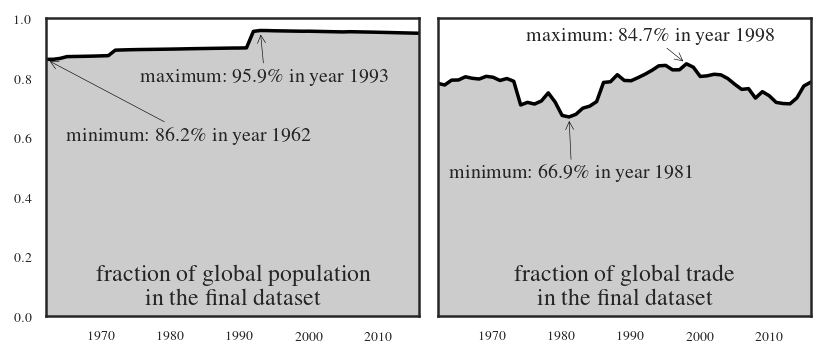

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH * .8), sharey=True)
for i, (ax, series) in enumerate(zip(axes, [frac_global_pop, frac_global_exports])):
    years = [y.year for y in series.index.values]
    values = series.values
    ax.plot(years, values, color='k')
    ax.set_ylim(0, 1)
    ax.set_xlim(min(years), max(years))
    ax.fill_between(years, values, color='.8')

    min_val, min_year = series.min(), series.idxmin().year
    ax.annotate(
        s=r'minimum: {:.1%} in year {}'.format(min_val, min_year).replace('%', '\%'),
        xy=(min_year, min_val),
        size=annotate_text_size + 2,
        xytext=(-60 if i else 10, -40 + 10 * i), textcoords='offset points',
        ha='left',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=30,rad=20,angleB=50", shrinkA=0))

    max_val, max_year = series.max(), series.idxmax().year
    ax.annotate(
        s=r'maximum: {:.1%} in year {}'.format(max_val, max_year).replace('%', '\%'),
        xy=(max_year, max_val),
        size=annotate_text_size + 2,
        xytext=(-80 if i else -60, 12 if i else -25), textcoords='offset points',
        ha='left',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc", shrinkA=0))

    ax.annotate(
        s='fraction of global {}\nin the final dataset'.format('trade' if i else 'population'),
        ha='center', va='center',
        xy=(0.5, .1), xycoords='axes fraction', size=annotate_text_size + 4)
fig.subplots_adjust(wspace=.05)
fig.savefig(os.path.join(path_manuscript_figures, 'frac_global_population_trade.pdf'), bbox_inches='tight')

#### plot the exponents in the normalization

* Exports (by a certain country of a certain product in a certain year) tends to grow like population to the 0.9 power.
* Global (in a certain product in a certain year) tends to grow like global population to the 5th power.

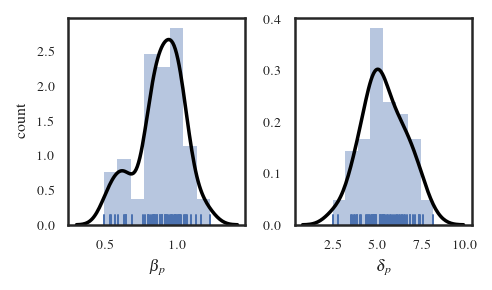

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(ONE_COL_WIDTH, ONE_COL_WIDTH * .6))
kws = dict(bins=8, rug=True, norm_hist=False, kde_kws=dict(color='k'))
sns.distplot(np.array(list(div_pop.exponents_a.values())), ax=ax[0], **kws)
sns.distplot(np.array(list(div_pop.exponents_b.values())), ax=ax[1], **kws)
ax[0].set_xlabel(r'$\beta_p$')
ax[1].set_xlabel(r'$\delta_p$')
ax[0].set_ylabel('count')
fig.subplots_adjust(wspace=.3)
plt.tight_layout()
fig.savefig(os.path.join(path_manuscript_figures, 'exponents_from_normalizing_Rpop_by_population.pdf'))

### Logarithmically scale the positive data

#### Illustration of the transformation:

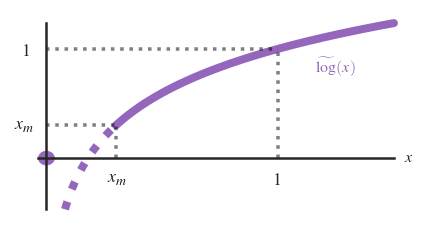

In [20]:
aspect_ratio = .55
fig, ax = plt.subplots(figsize=(ONE_COL_WIDTH, ONE_COL_WIDTH * aspect_ratio))
x_min_pos = 0.3
c = mpl.colors.TABLEAU_COLORS['tab:purple']

x = np.linspace(.08, x_min_pos, 100)
ax.plot(x, 1 + np.log(x) * (x_min_pos - 1.0) / np.log(x_min_pos), ls=':', lw=4, c=c)
x = np.linspace(x_min_pos, 1.5, 100)
ax.plot(x, 1 + np.log(x) * (x_min_pos - 1.0) / np.log(x_min_pos), ls='-', lw=4, c=c)

for v in [x_min_pos, 1]:
    ax.plot([v, v], [0, v], color='k', alpha=.5, ls=':')
    ax.plot([0, v], [v, v], color='k', alpha=.5, ls=':')
sns.despine(ax=ax, trim=False)
plt.xticks([x_min_pos, 1], ['$x_m$', 1])
plt.yticks([x_min_pos, 1], ['$x_m$', 1])
ax.tick_params(labelsize=9)
radius = .07
ax.add_patch(
    mpl.patches.Ellipse(xy=(0, 0), width=radius, height=radius / aspect_ratio, color=c)
#    mpl.patches.Circle((0, 0), 30, alpha=0.5, transform=None)
)
ax.annotate(s='$x$', xy=(.98, .28), xycoords='axes fraction')
ax.annotate(s='${\widetilde \log}(x)$', xy=(.75, .72), xycoords='axes fraction', color=c)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
fig.savefig(os.path.join(path_manuscript_figures, 'plot_of_log_transformation_function.pdf'), bbox_inches='tight')

#### Do the transformation

In [21]:
log_scaler = ScaledLogPositiveData(X_min_pos=None)
log_scaler.fit(rpop_df)
rpop_df_log_scaled = log_scaler.transform(rpop_df)

##### Compare transforming with `np.log1p` and `ScaledLogPositiveData`:

Transforming with `ScaledLogPositiveData` makes countries' trajectories more comparable (i.e., closer together) than transforming with `log1p`:

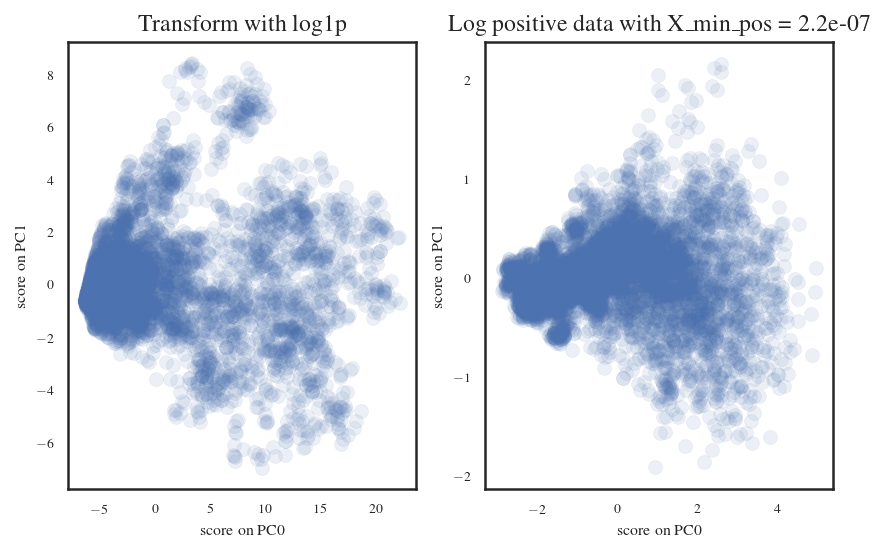

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH, TWO_COL_WIDTH * .6))
ax[0].scatter(*PCA(2).fit_transform(rpop_df.apply(np.log1p)).T, alpha=.1)
ax[0].set_xlabel('score on PC0')
ax[0].set_ylabel('score on PC1')
ax[0].set_title('Transform with log1p')
ax[1].scatter(*PCA(2).fit_transform(rpop_df_log_scaled).T, alpha=.1)
ax[1].set_xlabel('score on PC0')
ax[1].set_ylabel('score on PC1')
ax[1].set_title('Log positive data with X\_min\_pos = {:.2g}'.format(log_scaler.X_min_pos))
plt.show()

The histogram in the top-right corner looks the closest to a normal distribution, which was our goal in our preprocessing:

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))


for j in [0, 1, 2]:
    flattened_values = rpop_df.values.flatten()
    xlabel = 'X_{cpt} / P_{ct}^a / (\sum_c X_{pt} / (\sum_c P_{ct})^b)'
    
    if j == 1:
        flattened_values = np.log1p(flattened_values)
        xlabel = 'log \left (1 + {} \right )'.format(xlabel)
    if j == 2:
        scaler = ScaledLogPositiveData()
        flattened_values = scaler.fit_transform(flattened_values)
        xlabel = scaler._transformed_name('V') + ' with V = {}'.format(xlabel)
    ax[0, j].hist(flattened_values, bins=150);
    ax[0, j].set_yscale('log')
    ax[0, j].set_ylabel('count')
    ax[0, j].set_xlabel(r'$' + xlabel + '$')
    
    ax[1, j].set_xlabel('score on first principal component')
    ax[1, j].set_ylabel('score on second principal component')
    
ax[1, 0].scatter(*PCA(2).fit_transform(rpop_df.dropna(how='all').fillna(0.)).T, alpha=.4)
ax[1, 1].scatter(
    *PCA(2).fit_transform(rpop_df.dropna(how='all').fillna(0.).apply(np.log1p)).T,
    alpha=.4)
ax[1, 2].scatter(
    *PCA(2).fit_transform(ScaledLogPositiveData().fit_transform(rpop_df.dropna(how='all').fillna(0.))).T,
    alpha=.4)
ax[0, 0].set_title('no log transform', y=1.05)
ax[0, 1].set_title('transform with log1p', y=1.05)
ax[0, 2].set_title('transform $x[x > 0]$ to $(\log(x) + \min(x[x > 0])) / \min(x[x > 0])$', y=1.05)
plt.show()

##### make a figure for the paper that illustrates the difference

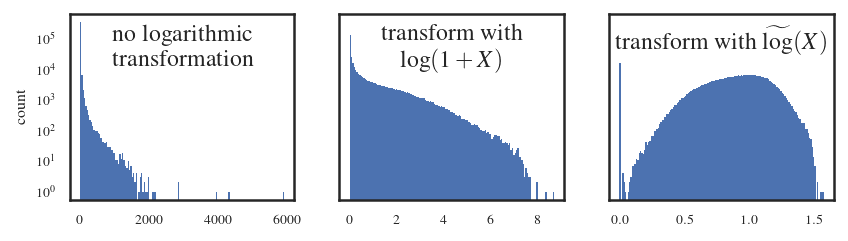

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH * .5), sharey=True)

for j in [0, 1, 2]:
    flattened_values = rpop_df.values.flatten()
    xlabel = 'X_{cpt} / (\alpha_p P_{ct}^{\beta_p} / (\sum_c X_{pt} / (\gamma (\sum_c P_{ct})^\delta_p))'
    
    if j == 1:
        flattened_values = np.log1p(flattened_values)
        xlabel = 'log \left (1 + {} \right )'.format(xlabel)
    if j == 2:
        scaler = ScaledLogPositiveData()
        flattened_values = scaler.fit_transform(flattened_values)
        xlabel = scaler._transformed_name('V') + ' with V = {}'.format(xlabel)
    ax[j].hist(flattened_values, bins=150);
    ax[j].set_yscale('log')
    if j == 0:
        ax[j].set_ylabel('count')
    #ax[j].set_xlabel(r'$' + xlabel + '$')

title_height = .88
ax[0].set_title('no logarithmic\ntransformation', y=title_height, va='top')
ax[1].set_title('transform with\n$\log(1 + X)$', y=title_height, va='top')
ax[2].set_title(r'transform with ${\widetilde \log}(X)$', y=title_height, va='top')
fig.savefig(os.path.join(path_manuscript_figures, 'histograms_log_transformations.pdf'), bbox_inches='tight')

## Fit GAM on yearly changes raised to the 1/2 power

In [27]:
def scale_to_pre1988(df, scaler):
    scaler.fit(slice_training_set_for_preprocessing(df))
    return pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns), scaler

def slice_training_set_for_preprocessing(df):
    return df.loc[(slice(None), slice('1962', '1988')), :]

In [28]:
log_scaler = ScaledLogPositiveData(X_min_pos=None)
log_scaler.fit(rpop_df)
rpop_df_logged = log_scaler.fit_transform(rpop_df)

rpop_df_logged_scaled, scaler = scale_to_pre1988(rpop_df_logged, StandardScaler())

#### Transform the target `y` to  `np.abs(y)**root * np.sign(y)`

In [29]:
def signed_root(x, root=0.5):
    return np.abs(x)**root * np.sign(x)


def inverse_of_signed_root(x, root=0.5):
    return np.abs(x)**(1 / root) * np.sign(x)


def signed_root_transformer(root=0.5):
    t = FunctionTransformer(
        func=signed_root,
        inverse_func=inverse_of_signed_root,
        kw_args={'root': root}, inv_kw_args={'root': root})
    name = 'signed_root_transformer_root={}'.format(root)
    t.name = name
    t.filename = name
    return t

In [30]:
rpop_df_logged_scaled.name = rpop_df_logged_scaled.filename = 'Rpop_ScalePopulationPowerLaw_ScaleLogPositive'
pca = PCAsomeColumns(
    n_components=2, exclude_columns='log10_gdp_per_capita_constant2010USD')

mtss = MultiTimeSeriesSplit(
    n_train_test_sets=5,
    first_split_fraction=.389891,  # chosen to make all data before 1988 in the first training set
    level_of_index_for_time_values='year')

def make_model():
    return create_random_search(
        MultiOutputRegressor(pygam.GAM()),
        [
            IntegerUniformDistribution(15, 60, 'estimator', 'n_splines'),
            LogUniformDistribution(-3.0, 10.0, 'estimator', 'lam'),
        ],
        n_iter=150,
        cv=mtss)

panel = multiindex_to_panel(append_gdppc(rpop_df_logged_scaled))
panel.name = rpop_df.name
panel.filename = rpop_df.filename

In [31]:
pm = SKLearnPanelModel(
    panel, make_model(),
    model_predicts_change=True,
    dim_reducer_preprocessing=pca,
    validate_on_full_dimensions=False,
    overwrite_existing_results=True,
    metric=mean_squared_error,
    metric_greater_is_better=False,
    target_transformer=signed_root_transformer(0.5),)

/Users/charliebrummitt/Dropbox/Identify laws and dynamical systems in socioeconomic data/machine_learned_patterns_in_economic_development/scripts/analyze_panel_data/models/DimensionReducingPanelModel.py:429: UserWarning: A directory already exists at the results path results/24b3f41a3f28b4ef3b480373cb2fe29d47686b6f9a57010b4ab2f78a05ffb444. Continuing anyway (and overwriting results) because `overwrite_existing_results` is `True`.  If you fit the model, it will overwrite the previously saved fit.
  warnings.warn(msg)


#### Examine the years in each of the train, test splits

Because there are different numbers of countries present in different years, we split based on quantiles of the distribution of years available (no matter the country). About 39% of the earliest observations (with ties broken arbitrarily) appear in the first training set, which spans from year 1962 to 1988 inclusive. We split the data into 5 roughly equal sized training and test sets that are nested. `MultiTimeSeriesSplit` is a generalization of sci-kit learn's [`TimeSeriesSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to multiple trajectories that do not all exactly overlap in time.

In [32]:
train_test_splitter = copy(mtss).split(pm.X, pm.y)
train_test_descriptions = []
for i, (train, test) in enumerate(train_test_splitter):
    train_years = pm.X.iloc[train].index.get_level_values('year')
    test_years = pm.X.iloc[test].index.get_level_values('year')
    print('Split {}'.format(i) + '\n' + '=' * 20)
    print('Train: predict year t from year t-1 for {} <= t <= {}'.format(train_years.min(), train_years.max()))
    print('Test: predict year t from year t-1 for {} <= t <= {}'.format(test_years.min(), test_years.max()), end='\n\n')
    train_test_descriptions.append([
        i,
        r'${} \leq t \leq {}$'.format(train_years.min(), train_years.max()),
        r'${} \leq t \leq {}$'.format(test_years.min(), test_years.max()),
    ])

Split 0
Train: predict year t from year t-1 for 1963 <= t <= 1988
Test: predict year t from year t-1 for 1989 <= t <= 1995

Split 1
Train: predict year t from year t-1 for 1963 <= t <= 1995
Test: predict year t from year t-1 for 1996 <= t <= 2001

Split 2
Train: predict year t from year t-1 for 1963 <= t <= 2001
Test: predict year t from year t-1 for 2002 <= t <= 2006

Split 3
Train: predict year t from year t-1 for 1963 <= t <= 2006
Test: predict year t from year t-1 for 2007 <= t <= 2011

Split 4
Train: predict year t from year t-1 for 1963 <= t <= 2011
Test: predict year t from year t-1 for 2012 <= t <= 2016



### Fit the GAM

#### Fit the model

Run the random hyperparameter search and re-fit the model on the entire dataset with the best parameters:

In [59]:
pm.fit_model_to_entire_dataset_and_save_best_model()

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

Fit time: 541.5645868778229 seconds = 0:09:01.564587


/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users

541.5645868778229

#### Load the fitted model from disk. Use this if you already fitted the model in a previous session and do not want to do the fit again.

Run this to load the already fitted model:

In [33]:
pm.load_best_model()

Loading the best model found in path results/24b3f41a3f28b4ef3b480373cb2fe29d47686b6f9a57010b4ab2f78a05ffb444/best_model/best_model.pkl


/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 0.18.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Split the model into a dimension reducer and predictor

Running the method below is needed to use visualization methods but, for this model, doesn't do anything significant because this model does not reduce dimensions as an intermediate step to making predictions. We also experimented with models that do reduce dimensions as an intermediate step to making a prediction (such as a neural network with a small "bottleneck" hidden layer).

In [34]:
pm.split_best_model_into_dimension_reducer_and_predictor()

##### smooting parameter `lam`

Surprisingly, the test score is better than the train score. This difference results from the facts that (1) the train set always contains years that precede those in the test set, and (2) more recent years are easier to predict.

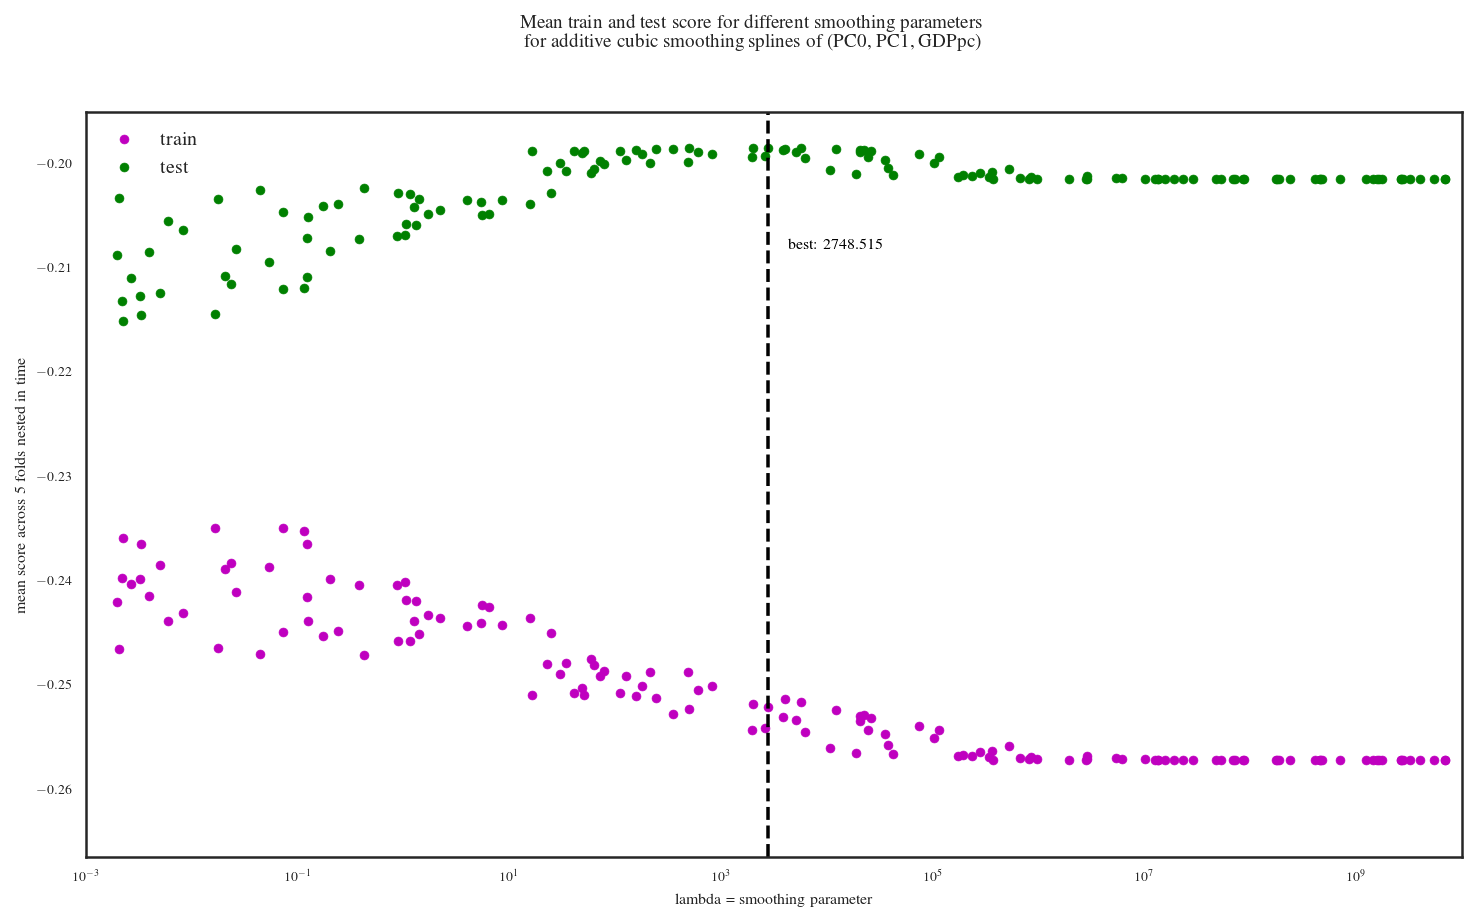

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(TWO_COL_WIDTH * 1.8, TWO_COL_WIDTH))

cv_df = pd.DataFrame(pm.cv_results)
cv_df.plot.scatter(
    x='param_estimator__lam',
    y='mean_train_score',
    color='m', label='train',
    ax=ax)
cv_df.plot.scatter(
    x='param_estimator__lam',
    y='mean_test_score',
    color='g', label='test',
    ax=ax)

best_value = pm.cv_results['param_estimator__lam'][pm.model.best_index_]
ax.axvline(x=best_value, color='k', ls='--')
ax.annotate(s='best: {:.3f}'.format(best_value), color='k', xy=(best_value, pm.cv_results['mean_test_score'][pm.model.best_index_]),
            xytext=(10, -50), textcoords='offset points')
#ax.set_title(pm.panel.name)
ax.set(xlabel='lambda = smoothing parameter',
       ylabel='mean score across 5 folds nested in time',
       xscale='log', xlim=(10**(-3), 10**10))

fig.suptitle('Mean train and test score for different smoothing parameters\nfor additive cubic smoothing splines of (PC0, PC1, GDPpc)')
fig.subplots_adjust(hspace=.3)
plt.show()

##### number of splines, `n_splines`

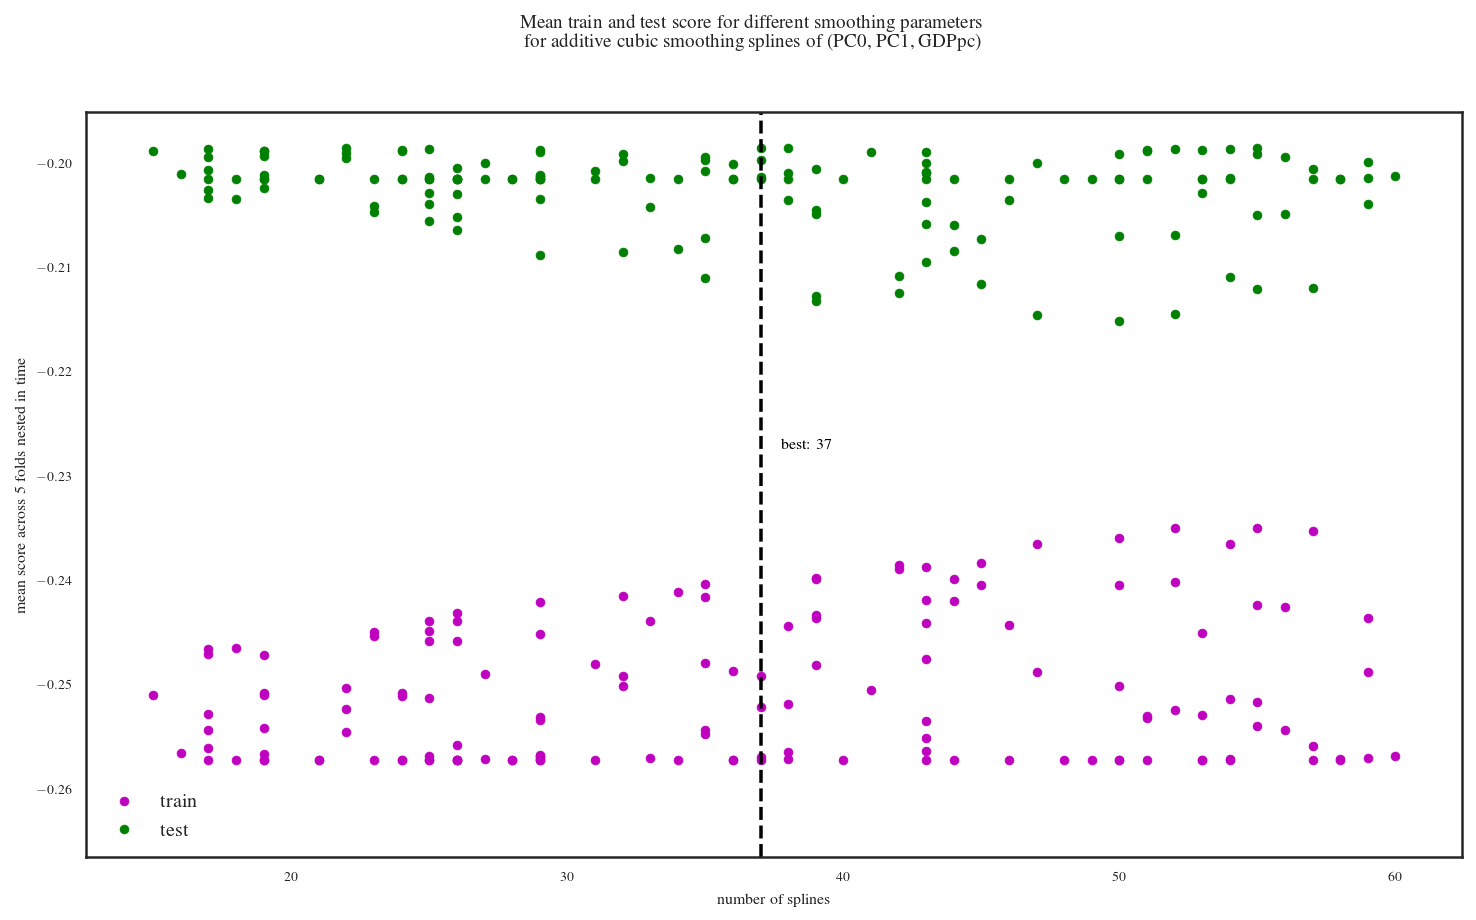

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(TWO_COL_WIDTH * 1.8, TWO_COL_WIDTH))

cv_df = pd.DataFrame(pm.cv_results)
cv_df.plot.scatter(
    x='param_estimator__n_splines',
    y='mean_train_score',
    color='m', label='train',
    ax=ax)
cv_df.plot.scatter(
    x='param_estimator__n_splines',
    y='mean_test_score',
    color='g', label='test',
    ax=ax)
best_value = pm.cv_results['param_estimator__n_splines'][pm.model.best_index_]
ax.axvline(x=best_value, color='k', ls='--')
ax.annotate(s='best: {}'.format(best_value), color='k',
            xy=(best_value, pm.cv_results['mean_test_score'][pm.model.best_index_]), xytext=(10, -150), textcoords='offset points')

ax.set(xlabel='number of splines',
       ylabel='mean score across 5 folds nested in time',
       xscale='linear')

fig.suptitle('Mean train and test score for different smoothing parameters\nfor additive cubic smoothing splines of (PC0, PC1, GDPpc)')
fig.subplots_adjust(hspace=.3)
plt.show()

#### investigate train and test scores

As the amount of training data increases (i.e., the fold index in the plot below increases), the training score drops, while the test score drops and then rises. The best test score is achieved when the training set is approximately all samples between 1962 to 2002 and the test set is 2002 to 2007.

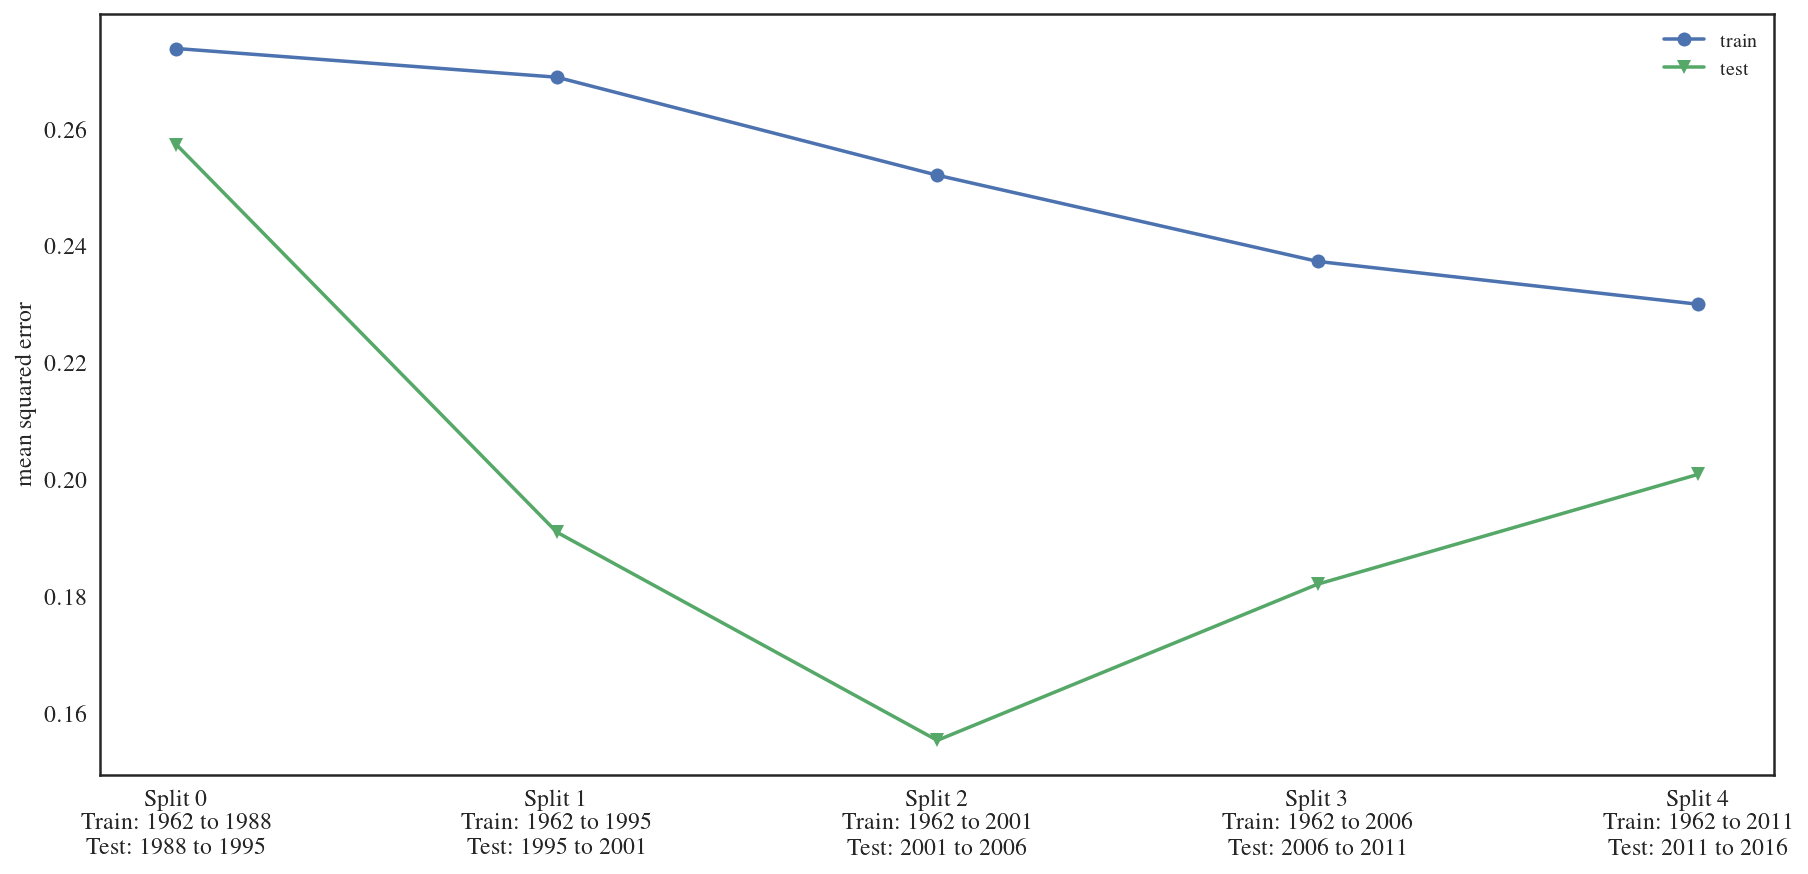

In [37]:
splitter = copy(mtss).split(pm.X, pm.y)

xticklabels = []
for i, (train, test) in enumerate(splitter):
    train_years = pm.X.iloc[train].index.get_level_values('year')
    test_years = pm.X.iloc[test].index.get_level_values('year')
    xticklabels.append(
        'Split {}\nTrain: {} to {}\nTest: {} to {}'.format(
            i,
            train_years.min() - 1, train_years.max(),
            test_years.min() - 1, test_years.max())
    )

train_scores = (
    pd.DataFrame(pm.cv_results)
    .query('rank_test_score == 1').iloc[0]
    .filter(regex=r'split[0-9]_train_score').sort_index().values)
test_scores = (
    pd.DataFrame(pm.cv_results)
    .query('rank_test_score == 1').iloc[0]
    .filter(regex=r'split[0-9]_test_score').sort_index().values)

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(range(5), -train_scores, label='train', marker='o')
ax.plot(range(5), -test_scores, label='test', marker='v')
ax.set_ylabel('mean squared error', fontsize=12)
ax.set_xlabel('')
plt.xticks(range(5), xticklabels, fontsize=12)
plt.yticks(fontsize=12)
ax.legend()
plt.show()

In [39]:
pd.DataFrame(pm.cv_results).sort_values('rank_test_score').head()

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
146       0.406385         0.022273        -0.198794         -0.252396   
9         0.430783         0.023443        -0.198796         -0.252040   
125       0.223955         0.016676        -0.198801         -0.252520   
80        0.615552         0.027586        -0.198807         -0.251892   
19        0.664191         0.030512        -0.198823         -0.252689   

    param_estimator__lam param_estimator__n_splines  \
146              2748.51                         37   
9                1972.48                         38   
125              497.154                         22   
80               5686.69                         55   
19               12015.6                         52   

                                                params  rank_test_score  \
146  {'estimator__n_splines': 37, 'estimator__lam':...                1   
9    {'estimator__n_splines': 38, 'estimator__lam':...                2   
125  {'estimator__n_splines': 22, 'estimator__lam':...                3   
80   {'estimator__n_splines': 55, 'estimator__lam':...                4   
19   {'estimator__n_splines': 52, 'estimator__lam':...                5   

     split0_test_score  split0_train_score       ...         \
146          -0.257320           -0.273771       ...          
9            -0.257384           -0.273262       ...          
125          -0.257315           -0.273928       ...          
80           -0.257428           -0.273054       ...          
19           -0.257340           -0.274188       ...          

     split2_test_score  split2_train_score  split3_test_score  \
146          -0.155286           -0.252072          -0.182039   
9            -0.155400           -0.251726          -0.182044   
125          -0.155256           -0.252200          -0.182046   
80           -0.155452           -0.251580          -0.182049   
19           -0.155211           -0.252354          -0.182054   

     split3_train_score  split4_test_score  split4_train_score  std_fit_time  \
146           -0.237307          -0.200849           -0.229975      0.085689   
9             -0.237021          -0.200713           -0.229726      0.088790   
125           -0.237414          -0.200856           -0.230072      0.041525   
80            -0.236901          -0.200697           -0.229620      0.135829   
19            -0.237542          -0.201029           -0.230179      0.157300   

     std_score_time  std_test_score  std_train_score  
146        0.001526        0.034138         0.017078  
9          0.001906        0.034135         0.016992  
125        0.001055        0.034141         0.017097  
80         0.001767        0.034140         0.016960  
19         0.002833        0.034164         0.017149  

[5 rows x 22 columns]

#### plot predictions in first two principal components

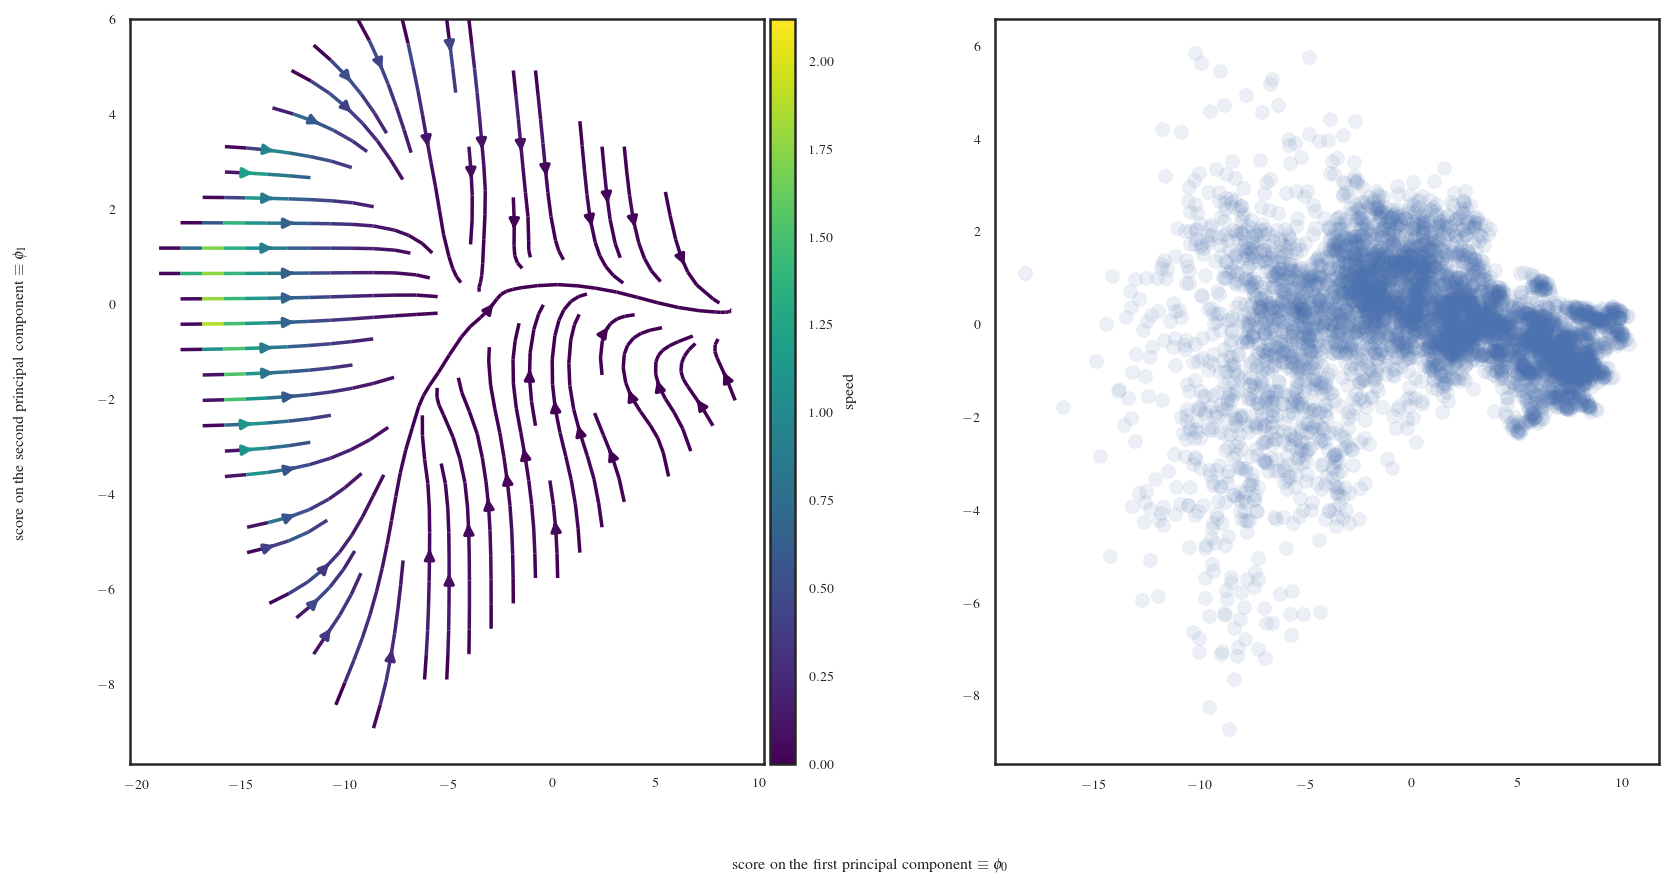

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH * 2, TWO_COL_WIDTH))
pm.plot_predictions_of_model_in_2D(ax=ax[0])
ax[1].scatter(*pm.df_dim_reduced.loc[:, ['component_0', 'component_1']].values.T, alpha=.1)
for i in range(2):
    ax[i].set(xlabel='', ylabel='')
fig.subplots_adjust(wspace=.3)
fig.text(s=r'score on the first principal component $\equiv {score_pc0}$'.format(**VARIABLE_NOTATION),
         x=.5, y=.02, ha='center', va='center')
fig.text(s=r'score on the second principal component $\equiv {score_pc1}$'.format(**VARIABLE_NOTATION),
         x=.07, y=.5, ha='center', va='center', rotation=90)
plt.show()

### Scatter and stream plots of two 2D projections of the data and model's predictions

In [41]:
highlight_countries_scatter = {
    'KOR': 'b',
    'USA': 'r',
    'THA': 'm',
    'MDG': 'g',
    'SAU': 'c',
    'URY': np.array([7, 60, 165]) / 256,#mpl.colors.TABLEAU_COLORS['tab:pink'],
    'NLD': mpl.colors.TABLEAU_COLORS['tab:orange'],
    'CHN': np.array([220, 44, 31]) / 256,
    'AGO': '#ef2a00',
    'THA': 'm',
    'LBR': (0., 0.14509804, 0.40784314),
    'NOR': (116 / 255., 171 / 255., 91 / 255.)#(0.5019607843137255, 0.6941176470588235, 0.8274509803921568)
}

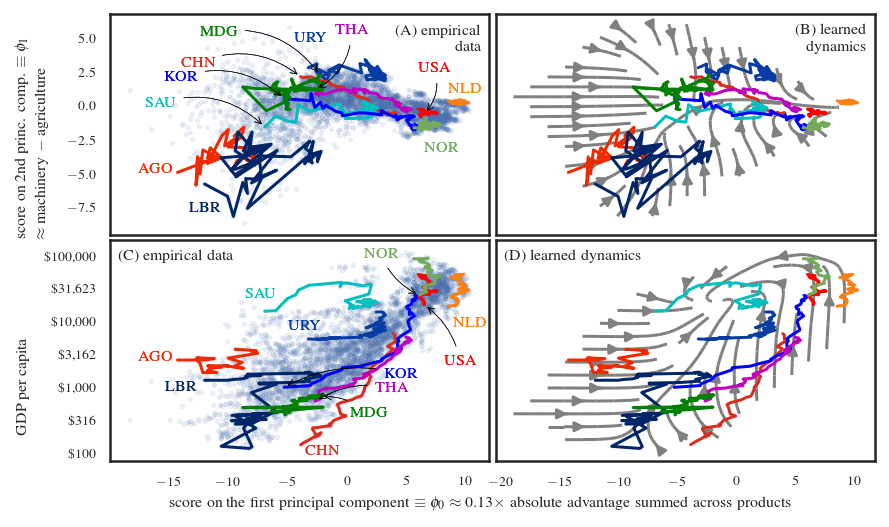

In [46]:
lw_trajectories = 1.5
stream_kws = dict(linewidth=1.5, density=0.75)

fig, ax = plt.subplots(2, 2, figsize=(TWO_COL_WIDTH, TWO_COL_WIDTH * .6), sharex='col', sharey='row')
pm.plot_predictions_of_model_in_2D(
    ax=ax[0, 1], dimensions_to_keep=(0, 1), colorbar_label='', show_colorbar=False, color_values='.5',
    plot_kws=stream_kws)
ax[0, 0].scatter(*pm.df_dim_reduced.loc[:, ['component_0', 'component_1']].values.T, alpha=.1, s=5)
for i in range(2):
    ax[0, i].set(xlabel='', ylabel='')

for i in [0, 1]:
    for c, color in highlight_countries_scatter.items():
        ax[0, i].plot(*pm.X.loc[c].iloc[:, [0, 1]].values.T, label=c, lw=lw_trajectories, color=color)
        ax[0, 0].annotate(
            xy=pm.X.loc[c].iloc[0, [0, 1]].values, s=c, color=color,
            xytext={
                'NLD': (0, 4), 'USA': (-3, 21),
                'NOR': (2, -14), 'URY': (-7, 13),
                'THA': (10, 28), 'CHN': (-60, 5),#(10, 25),
                'LBR': (-8, -14), 'AGO': (-20, 0),
                'KOR': (-60, 9), 'MDG': (-60, 20),#(0, 30),
                'SAU': (-60, 10), #(0, -5),
            }.get(c, (0, 0)),
            textcoords='offset points',
            size=annotate_text_size,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3") if c in ['THA', 'KOR', 'CHN', 'USA', 'MDG', 'SAU'] else None)

pm.plot_predictions_of_model_in_2D(
    ax=ax[1, 1], dimensions_to_keep=(0, 2), colorbar_label='', show_colorbar=False, color_values='.5',
    plot_kws=stream_kws)
ax[1, 0].scatter(*pm.df_dim_reduced.loc[:, ['component_0', 'log10_gdp_per_capita_constant2010USD']].values.T, alpha=.1, s=5)
for i in range(2):
    ax[1, i].set(xlabel='', ylabel='')
    
for axis, letter, description, xy, ha in zip(
        ax.flatten(),
        list('ABCD'),
        ['empirical\ndata', 'learned\ndynamics', 'empirical data', 'learned dynamics'],
        [(.98, .96), (.98, .96), (.02, .96), (.02, .96)],
        ['right', 'right', 'left', 'left']):
    axis.annotate(s='({}) {}'.format(letter, description),
                  xy=xy,
                  va='top',
                  ha=ha,
                  xycoords='axes fraction')

fig.subplots_adjust(wspace=.02, hspace=.02)
fig.text(s=(r'score on the first principal component'
            r' $\equiv {score_pc0} \approx 0.13 \times$ absolute advantage summed across products').format(**VARIABLE_NOTATION),
         x=.5, y=0.05, ha='center', va='center')
fig.text(s=r'GDP per capita'.format(**VARIABLE_NOTATION),
         x=0.035, y=.25, ha='center', va='center', rotation=90)
fig.text(s='score on 2nd princ. comp. ' + r'$\equiv {score_pc1}$'.format(**VARIABLE_NOTATION) + '\n' + r'$\approx$ machinery $-$ agriculture',
         x=0.03, y=.5, ha='left', va='bottom', rotation=90)

ax[1, 0].set_yticklabels(['\${:,.0f}'.format(10**d) for d in ax[1, 0].yaxis.get_majorticklocs()])

for i in [0, 1]:
    for c, color in highlight_countries_scatter.items():
        ax[1, i].plot(*pm.X.loc[c].iloc[:, [0, 2]].values.T, label=c, lw=lw_trajectories, color=color)
        ax[1, 0].annotate(
            xy=pm.X.loc[c].iloc[0, [0, 2]].values, s=c, color=color,
            xytext={
                'CHN': (2, -5), 'SAU': (-10, 7), 'AGO': (-20, 0), 'LBR': (-20, -5),
                'THA': (30, 5), 'NLD': (2.3, -10), 'NOR': (-28, 19), 'USA': (10, -30),
                'URY': (-10, 5), 'MDG': (15, -10), 'KOR': (50, 5) #(20, 5)
            }.get(c, (0, 0)),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2") if c in ['THA', 'USA', 'NOR', 'MDG', 'KOR'] else None,
            textcoords='offset points', size=annotate_text_size)

fig.savefig(os.path.join(path_manuscript_figures, 'streamplot_scatterplot_pc0_p1_and_pc0_gdppc.pdf'), dpi=300, bbox_inches='tight')

### Partial dependence plots

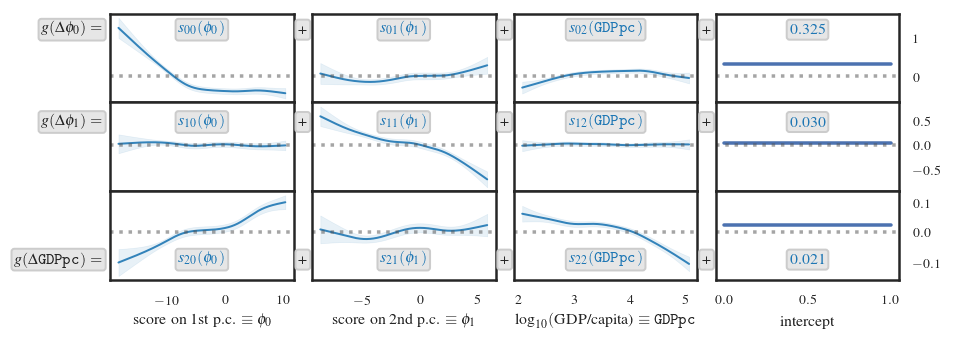

In [47]:
fig, ax = plt.subplots(3, 4, figsize=(TWO_COL_WIDTH, TWO_COL_WIDTH * .4), sharex='col', sharey='row')
handles = []

label_kws = dict(
    bbox=BBOX_LABELS,
    xycoords='axes fraction',
    ha='center', va='center')

terms = [
    VARIABLE_NOTATION['score_pc0'],
    VARIABLE_NOTATION['score_pc1'],
    VARIABLE_NOTATION['gdppc']]
pms = [pm]
symbol_heights = [.82, .78, .23]#[.82] * 3# [.7, .7, .88]
for pm_index, (pm, color, linestyle) in enumerate(zip(pms, list(mpl.colors.TABLEAU_COLORS.values())[:3], ['-', '--', ':'])):
    gams = pm.best_model.estimators_
    for i, gam in enumerate(gams):
        X_grid = generate_X_grid(gam)
        partial_dependence, confidence_interval = gam.partial_dependence(
            X_grid, width=.95)
        for j in range(4):
            if j < 3:
                lines, = ax[i, j].plot(X_grid[:, j], partial_dependence[:, j],
                                       color=color, lw=1, alpha=.9, linestyle=linestyle)
                ax[i, j].fill_between(X_grid[:, j], *confidence_interval[j].T, color=color, alpha=.1)
                title = '$s_{{{i}{j}}}({term})$'.format(i=i, j=j, term=terms[j])
                if pm_index == 0:
                    ax[i, j].annotate(s=title, xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)

            if i == 0 and j == 0:
                handles.append(lines)
            if j == 3:
                ax[i, j].plot([0, 1], [gam.coef_[0]] * 2, ls='-')
                ax[i, j].annotate(s='{:.3f}'.format(gam.coef_[0]), xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)
            ax[i, j].axhline(0, color='.3', alpha=.5, ls=':')

ylabel_kws = dict(rotation=0, size=12, x=-.1)
ax[2, 0].set_xlabel(r'score on 1st p.c. $\equiv {score_pc0}$'.format(**VARIABLE_NOTATION))
ax[2, 1].set_xlabel(r'score on 2nd p.c. $\equiv {score_pc1}$'.format(**VARIABLE_NOTATION))
ax[2, 2].set_xlabel(r'$\log_{{10}}($' + 'GDP/capita' + r') \equiv {gdppc}$'.format(**VARIABLE_NOTATION))
ax[2, 3].set_xlabel('intercept')

for i, term in enumerate(terms):
    ax[i, 0].annotate(s=r'$g(\Delta {}) =$'.format(term),
                      xy=(-.04, symbol_heights[i]), **{**label_kws, 'ha': 'right'})
for i in range(3):
    for j in range(3):
        ax[i, j].annotate(s='+', xy=(1.05, symbol_heights[i]), **label_kws)
fig.subplots_adjust(top=.8, left=.1, wspace=.1, hspace=0.0)

for i in range(3):
    ax[i, 0].tick_params(axis='y', left=True, labelleft=False)
    ax[i, 3].tick_params(axis='y', right=True, labelright=True)
fig.savefig(os.path.join(
    path_manuscript_figures,
    'partial_dependence.pdf'), dpi=300, bbox_inches='tight')

###### Little partial dependence plots that can be embedded in an equation or table environment:

In [48]:
os.makedirs(os.path.join(path_manuscript_figures, 'small_partial_dependence_plots'), exist_ok=True)

gams = pm.best_model.estimators_
for i, gam in enumerate(gams):
    X_grid = generate_X_grid(gam)
    partial_dependence, confidence_interval = gam.partial_dependence(
        X_grid, width=.95)
    for j in range(3):
        fig, ax = plt.subplots(figsize=(.3, .3))
        ax.plot(X_grid[:, j], partial_dependence[:, j], color='k', lw=2)
        ax.fill_between(X_grid[:, j], *confidence_interval[j].T, color='.8')
        #fig.patch.set_visible(False)
        ax.axis('off')
        fig.savefig(os.path.join(
            path_manuscript_figures, 'small_partial_dependence_plots',
            'partial_dependence_{}_{}_{}.pdf'.format(pm.panel.filename, i, j)), dpi=300)
        fig.clf()

### Streamplots at different GDPpc

In [49]:
gdp_per_capita_nonmissing = load_gdp_per_capita_nonmissing()
log10_gdp_per_capita_nonmissing = gdp_per_capita_nonmissing.apply(np.log10)
log10_gdp_per_capita_nonmissing.name = 'log10_gdp_per_capita_constant2010USD'

gdppc 511.943417868    speed_min -0.0377203309413     speed_max 0.0948326517746
gdppc 2764.41729517    speed_min -0.053836350502     speed_max 0.144684098831
gdppc 30576.941153    speed_min -0.0751256771647     speed_max 0.144684098831


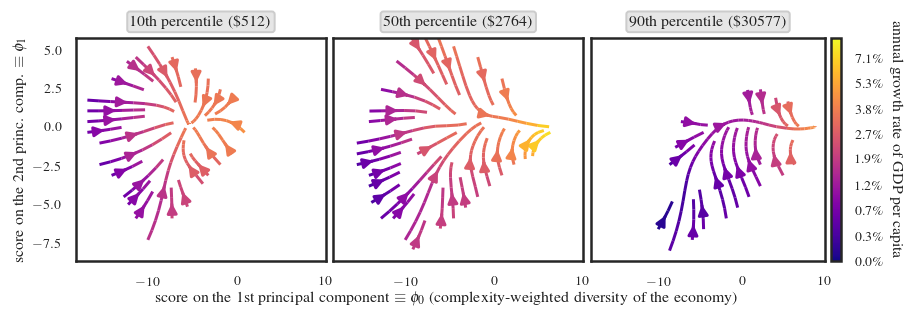

In [51]:
stream_kws = dict(linewidth=1.5, density=0.75)

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if mpl.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
percent_formatter = FuncFormatter(to_percent)


gdp_quantiles = gdp_per_capita_nonmissing.loc[(slice(None), '1988')].quantile(
    [.1, .5, .9])

eps = 0.15

pms = [pm]
fig, axes = plt.subplots(
    len(pms), len(gdp_quantiles), figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH * .6),
    sharex='row', sharey='row')

for i, (pm) in enumerate(pms):
    gam = pm.best_model.estimators_[2]
    X_grid = generate_X_grid(gam, n=200)
    partial_dependence, confidence_interval = gam.partial_dependence(X_grid, width=.95)
    X_grid_extra_point = np.vstack((X_grid, X_grid[-1] + np.diff(X_grid, axis=0)[-1]))
    y_spacing = 2
    x = X_grid_extra_point[:, 0]
    y = X_grid_extra_point[::y_spacing, 1]
    # C.shape should be (len(y), len(x)) (or 1 less than both of those)
    C = partial_dependence[:, 0].reshape(1, -1) + partial_dependence[::y_spacing, 1].reshape(-1, 1)

    X, Y = np.meshgrid(x, y, indexing='xy')

    UVWs = []
    speed_min, speed_max = np.inf, -1 * np.inf
    for j, (quantile, gdppc) in enumerate(gdp_quantiles.iteritems()):
        C_mask = np.empty(C.shape, dtype=bool)
        convex_hull = ConvexHull(
            pm.X[(np.log10(gdppc) * (1 - eps) <= pm.X.iloc[:, 2]) & (pm.X.iloc[:, 2] <= np.log10(gdppc) * (1 + eps))].iloc[:, :2])
        for y_index, y_value in enumerate(y[:-1]):
            for x_index, x_value in enumerate(x[:-1]):
                C_mask[y_index, x_index] = not vis_model.point_in_hull(
                    np.array([x_value, y_value]), convex_hull)

        gam_0 = pm.best_model.estimators_[0]
        gam_1 = pm.best_model.estimators_[1]
        gam_2 = pm.best_model.estimators_[2]
        
        gdppc_array = np.zeros(X[:-1, :-1].shape, dtype=float) + np.log10(gdppc)

        where_to_predict = np.hstack((
            X[:-1, :-1].reshape(-1, 1),
            Y[:-1, :-1].reshape(-1, 1),
            gdppc_array.reshape(-1, 1)))
        U = gam_0.predict(where_to_predict).reshape(X[:-1, :-1].shape)
        V = gam_1.predict(where_to_predict).reshape(X[:-1, :-1].shape)
        W = gam_2.predict(where_to_predict).reshape(X[:-1, :-1].shape)
        U = np.ma.masked_array(data=U, mask=C_mask)
        V = np.ma.masked_array(data=V, mask=C_mask)
        W = np.ma.masked_array(data=W, mask=C_mask)
        
        UVWs.append((U, V, W))
        
        speed_values = W
        speed_min = np.min([speed_min, np.min(speed_values)])
        speed_max = np.max([speed_max, np.max(speed_values)])
        print('gdppc', gdppc, '   speed_min', speed_min, '    speed_max', speed_max)
    
    norm = mpl.colors.Normalize(vmin=speed_min, vmax=speed_max)

    for j, ((quantile, gdppc), (U, V, W)) in enumerate(zip(gdp_quantiles.iteritems(), UVWs)):
        ax = axes[j]
        strm = ax.streamplot(
            x[:-1], y[:-1], U, V,
            color=W, cmap=mpl.cm.plasma, norm=norm, **stream_kws)
        divider = make_axes_locatable(ax)
        if j == len(gdp_quantiles) - 1:
            cax = divider.append_axes('right', size='4%', pad=0.04)
            cbar = fig.colorbar(mappable=strm.lines, cax=cax,
                                orientation='vertical')
            
            # Set the percent formatter
#            cax.yaxis.set_major_formatter(percent_formatter)
            cax.set_yticklabels(['{:3.1f}'.format((10**change_in_log10_gdppc - 1)) + r'\%' for change_in_log10_gdppc in cax.get_yticks()])

        if i == 0:
            ax.set_title(
                '{}th percentile (\${:0.0f})'.format(int(quantile * 100), gdppc),
                bbox=BBOX_LABELS, fontsize=plt.rcParams['axes.labelsize'],
                x=.5)
fig.text(s='annual growth rate of GDP per capita', x=.95, y=.9, rotation=270, fontsize=plt.rcParams['axes.labelsize'])
fig.text(s=r'score on the 1st principal component $\equiv {score_pc0}$'.format(**VARIABLE_NOTATION) + ' (complexity-weighted diversity of the economy)',
         x=.5, y=-.01, ha='center', va='center')
fig.text(s=r'score on the 2nd princ. comp. $\equiv {score_pc1}'.format(**VARIABLE_NOTATION),
         x=.07, y=.5, ha='center', va='center', rotation=90)

fig.subplots_adjust(wspace=.03)
fig.savefig(os.path.join(
    path_manuscript_figures,
    'streamplots_vary_gdppc.pdf'), bbox_inches='tight')

#### Hill climbing

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in sqrt


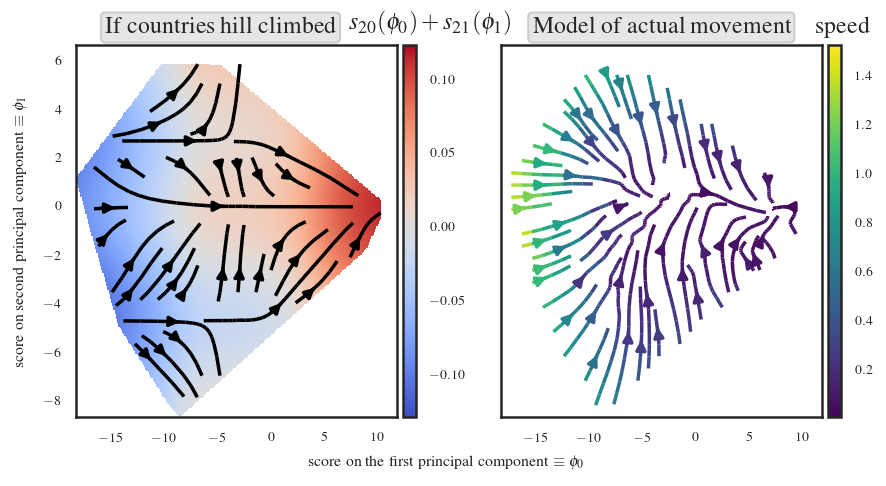

In [53]:
from analyze_panel_data.visualization.utils import shifted_color_map

fig, axes = plt.subplots(
    1, 2, figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH ),
    sharex='row', sharey='row')


gam = pm.best_model.estimators_[2]
X_grid = generate_X_grid(gam, n=250)
partial_dependence, confidence_interval = gam.partial_dependence(X_grid, width=.95)

X_grid_extra_point = np.vstack((X_grid, X_grid[-1] + np.diff(X_grid, axis=0)[-1]))

y_spacing = 1
x = X_grid_extra_point[:, 0]
y = X_grid_extra_point[::y_spacing, 1]
# C.shape should be (len(y), len(x)) (or 1 less than both of those)
C = partial_dependence[:, 0].reshape(1, -1) + partial_dependence[::y_spacing, 1].reshape(-1, 1)

C_mask = np.empty(C.shape, dtype=bool)
convex_hull = ConvexHull(pm.X.iloc[:, :2])
for y_index, y_value in enumerate(y[:-1]):
    for x_index, x_value in enumerate(x[:-1]):
        C_mask[y_index, x_index] = not vis_model.point_in_hull(
            np.array([x_value, y_value]), convex_hull)
X, Y = np.meshgrid(x, y, indexing='xy')
pcolor_output = axes[0].pcolor(
    X, Y,
    np.ma.masked_array(data=C, mask=C_mask),
    cmap=shifted_color_map(plt.get_cmap('coolwarm'), data=C),
    vmin=np.min(C), vmax=np.max(C),
    linewidth=0, rasterized=True)
pcolor_output.set_edgecolor('face')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='4%', pad=0.04)
cbar_label = (
    'change in $\log_{10}$(GDPpc) predicted by PC0 and PC1'
    #', i.e., $f_{20}(PC_0) + f_{21}(PC_1)$'
)
cbar = fig.colorbar(mappable=pcolor_output, cax=cax,
                    orientation='vertical', label='')
if i == 0:
    cbar.ax.set_title(
        r'${smooth_term}_{{20}}({score_pc0}) + {smooth_term}_{{21}}({score_pc1})$'.format(
            **VARIABLE_NOTATION), x=2.2)
#axes[i, 0].colorbar(label='change in $\log_{10}$(GDPpc) predicted by PC0 and PC1, i.e., $f_{20}(PC_0) + f_{21}(PC_1)$')

#     CS = axes[i, 0].contour(X[:-1, :-1], Y[:-1, :-1], np.ma.masked_array(data=C, mask=C_mask))
#     axes[i, 0].clabel(CS, inline=1, fontsize=10)

x_deriv = np.gradient(partial_dependence[:, 0])
y_deriv = np.gradient(partial_dependence[::y_spacing, 1])
U, V = np.meshgrid(x_deriv, y_deriv)

axes[0].streamplot(
    X[:-1, :-1], Y[:-1, :-1],
    np.ma.masked_array(data=U, mask=C_mask),
    np.ma.masked_array(data=V, mask=C_mask),
    density=.6,
    color='k')

# Streamplot like vis.gam
gdppc_of_closest_datum = np.empty(X[:-1, :-1].shape)

for y_index, y_value in enumerate(y[:-1]):
    for x_index, x_value in enumerate(x[:-1]):
        index_closest_sample = np.argmin(
            np.sum((pm.X.values[:, :2] - np.array([x_value, y_value]))**2, axis=1))
        gdppc_of_closest_datum[y_index, x_index] = pm.X.values[index_closest_sample, 2]

gam_0 = pm.best_model.estimators_[0]
gam_1 = pm.best_model.estimators_[1]

where_to_predict = np.hstack((
    X[:-1, :-1].reshape(-1, 1),
    Y[:-1, :-1].reshape(-1, 1),
    #np.zeros(Y[:-1, :-1].reshape(-1, 1).shape) + 5.0))
    gdppc_of_closest_datum.reshape(-1, 1)))
U = gam_0.predict(where_to_predict).reshape(gdppc_of_closest_datum.shape)
V = gam_1.predict(where_to_predict).reshape(gdppc_of_closest_datum.shape)
U = np.ma.masked_array(data=U, mask=C_mask)
V = np.ma.masked_array(data=V, mask=C_mask)

ax = axes[1]
strm = ax.streamplot(
    x[:-1], y[:-1], U, V,
    color=np.sqrt(U**2 + V**2), cmap=mpl.cm.viridis)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.04)
cbar = fig.colorbar(mappable=strm.lines, cax=cax,
                    orientation='vertical')
if i == 0:
    cbar.ax.set_title('speed', x=1.2)


axes[0].set_title(
    'If countries hill climbed',
    x=.45,
    bbox=BBOX_LABELS)
axes[1].set_title(
    'Model of actual movement',
#     x=.4,
    bbox=BBOX_LABELS)
fig.text(s=r'score on the first principal component $\equiv {score_pc0}'.format(**VARIABLE_NOTATION),
         x=.5, y=.03, ha='center', va='center')
fig.text(s=r'score on second principal component $\equiv {score_pc1}'.format(**VARIABLE_NOTATION),
         x=.07, y=.5, ha='center', va='center', rotation=90)

fig.subplots_adjust(wspace=.25, hspace=.14)
fig.savefig(os.path.join(
    path_manuscript_figures,
    'hill_climb.pdf'),
    bbox_inches='tight', dpi=300)

#### Cosine similarities over time

In [54]:
from pandas_datareader import wb

wb_data = wb.get_countries()
wb_data.assign(adminregion=wb_data.adminregion.apply(lambda x: x.replace('&', 'and')))

grad_Gs = [
    pd.DataFrame(
        gam.partial_dependence(pm.X),
        index=pm.X.index, columns=['dG_dpc0', 'dG_dpc1', 'dG_dG'])
    for pm in pms]

cosine_similarities_dataframes = [
    pd.merge(
        pd.Series([
            1.0 - cosine_distance(grad, actual_movement)
            for grad, actual_movement in zip(grad_G.values[:, :2], pm.y.loc[:, 0].values[:, :2])],
            index=grad_G.index, name='cosine_similarity').reset_index(),
        wb_data.rename(columns={'iso3c': 'country_code'}))
    for grad_G, pm in zip(grad_Gs, pms)]

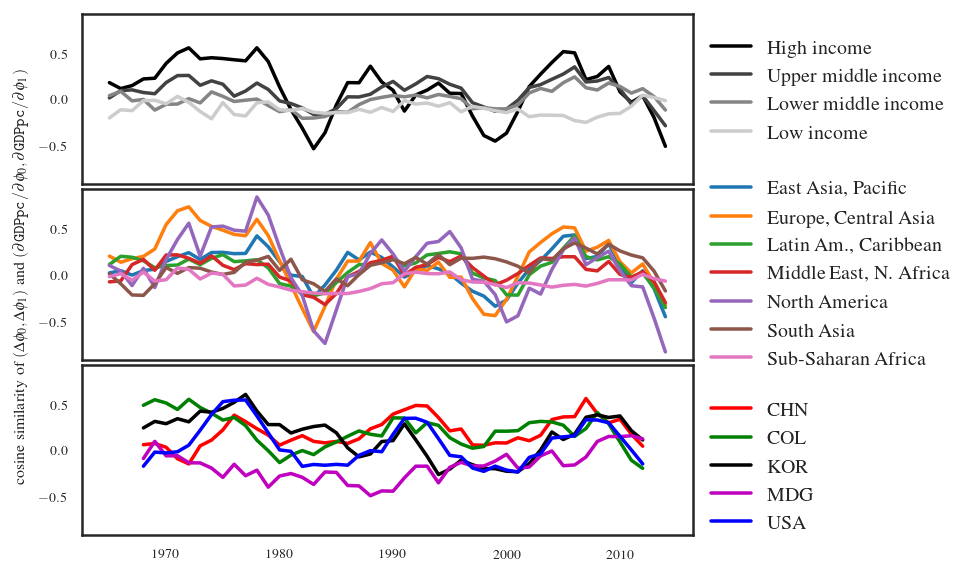

In [55]:
from collections import OrderedDict
import matplotlib.dates as dates

income_colors = OrderedDict((
    ('High income', '0.0'),
    ('Upper middle income', '.26'),
    ('Lower middle income', '.52'),
    ('Low income', '.8'),
))

pms = [pm]
fig, ax = plt.subplots(3, len(pms), figsize=(TWO_COL_WIDTH * .8, TWO_COL_WIDTH * .7), sharex=True, sharey=True)
window_size = 5

for j, (pm, cosine_similarities) in enumerate(zip(pms[:3], cosine_similarities_dataframes)):
    #ax[0, j].set_title(short_name_dict[pm.panel.name], bbox=BBOX_LABELS)

    by_income = (
        cosine_similarities.groupby(['incomeLevel', 'year'])['cosine_similarity']
        .mean().unstack(0).rolling(window=window_size, center=True).mean())
    
    for income_level in income_colors:
        lines, = ax[0].plot(
            by_income.index.to_timestamp(), by_income.loc[:, income_level],
            color=income_colors[income_level])
    if j == len(pms) - 1:
        ax[0].legend(list(income_colors.keys()), bbox_to_anchor=(1., .55), loc='center left')
    by_region = cosine_similarities.groupby(
        ['region', 'year'])['cosine_similarity'].mean().unstack(0).rolling(window=window_size, center=True).mean()
    by_region = by_region.rename(
        columns=dict(zip(
            by_region.columns,
            [(c.strip()
              .replace(' &', ',')
              .replace('North Africa', 'N. Africa').replace('Latin America', 'Latin Am.')
             )
             for c in by_region.columns])))
    for (region, color) in zip(by_region, mpl.colors.TABLEAU_COLORS.values()):
        ax[1].plot(by_region.index.to_timestamp(), by_region.loc[:, region], color=color)
        
    df = cosine_similarities[cosine_similarities.country_code.isin([
        'KOR', 'CHN', 'MDG', 'USA', 'COL'])]
    by_country = (
        df.groupby(['country_code', 'year'])['cosine_similarity']
        .mean().unstack(0).rolling(center=True, window=window_size*2).mean())
    for country in by_country:
        ax[2].plot(by_country.index.to_timestamp(), by_country.loc[:, country],
                      color={'KOR': 'k', 'CHN': 'r', 'MDG': 'm', 'USA': 'b', 'COL': 'g'}[country])

    ax[1].set_xlabel('')
    ax[1].xaxis.set_major_locator(dates.YearLocator(10))
    #ax[1, j].set_xlim(pd.Timestamp('1970-01-01'), pd.Timestamp('2014-01-01'))
    if j == len(pms) - 1:
        ax[1].legend(bbox_to_anchor=(1., .5), loc='center left')
        ax[2].legend(bbox_to_anchor=(1., .4), loc='center left')
title = ('cosine similarity of $(\Delta {score_pc0}, \Delta {score_pc1})$'
         ' and $(\partial {gdppc} / \partial {score_pc0}, \partial {gdppc} / \partial {score_pc1})$'
         #' and gradient of per-capita income'
         '').format(**VARIABLE_NOTATION)
fig.text(s=title, x=0.05, y=.5, ha='center', va='center', rotation=90)
# fig.suptitle(title.format(window_size=window_size, **VARIABLE_NOTATION))
#fig.text(s='\nrolling window of size {window_size}'.format(window_size=window_size), x=1, y=1)
fig.subplots_adjust(hspace=.03, wspace=.03)
fig.savefig(os.path.join(
    path_manuscript_figures,
    'cosine_similarity_by_income_and_region_and_country.pdf'),
    bbox_inches='tight', dpi=300)

### Predict into the future

In [56]:
iterated_predictions = pm.iterated_predictions(num_time_steps=51)

Export it:

In [58]:
it_pred_to_export = []

for c in iterated_predictions:
    
    initial_gdppc = iterated_predictions[c][0, -1]
    final_gdppc = iterated_predictions[c][-1, -1]
    change = final_gdppc - initial_gdppc # log base 10
    num_years = len(iterated_predictions[c] - 1)
    growth_rate = 100 * (-1 + 10**(change / num_years))
    
    it_pred_to_export.append({
        'pred_growth_rate_50_years': growth_rate,
        'score_first_pc_2016': iterated_predictions[c][0, 0],
        'score_second_pc_2016': iterated_predictions[c][0, 1],
        'gdppc_2016': iterated_predictions[c][0, 2],
        'total_absolute_advantage_2016': rpop_df.loc[c].iloc[0].sum(),
        'total_absolute_advantage_ge_1_2016': (rpop_df.loc[(c, '2016'), :] > 1).sum().sum(),
        'country_code': c,
    })
    
it_pred_to_export_df = pd.DataFrame(it_pred_to_export)
it_pred_to_export_df.to_csv(
    os.path.join(pm.results_path, 'iterated_predictions_data.csv'))

In [59]:
def add_subplot_axes(ax, rect, facecolor='w'):
    """Copied from:
    
    https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
    """
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height], facecolor=facecolor)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


def format_percent_tick_label(tick_val, tick_pos):
    return r'{}\%'.format(int(tick_val))

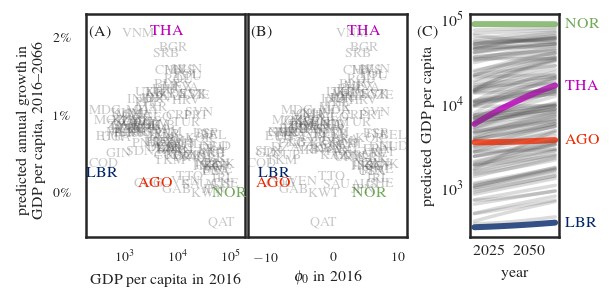

In [60]:
plt.figure(figsize=(ONE_COL_WIDTH, ONE_COL_WIDTH * .6))
gs1 = mpl.gridspec.GridSpec(1, 3)
gs1.update(left=0.02, right=1, wspace=0.02)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
gs2 = mpl.gridspec.GridSpec(1, 1)
gs2.update(left=0.8, right=0.98)
ax2 = plt.subplot(gs2[0])

size_not_highlighted = 7
size_highlighted = 8


end_year_index = 51
initial_year = rpop_df.index.get_level_values('year').max().year
highlight_certain_countries_growth = {
    'AGO': '#ef2a00',
#     'IND': '#ff9933',
    'THA': 'm',
    'LBR': (0., 0.14509804, 0.40784314),
    'NOR': (116 / 255., 171 / 255., 91 / 255.)#(0.5019607843137255, 0.6941176470588235, 0.8274509803921568)
}

#countries_to_highlight = ['LBR', 'NOR', 'IND', 'AGO']
it_pred_highlight = {c: iterated_predictions[c] for c in highlight_certain_countries_growth}
it_pred_gray = {c: iterated_predictions[c] for c in iterated_predictions if c not in highlight_certain_countries_growth}


for c in iterated_predictions:
    is_highlighted = c in highlight_certain_countries_growth
    color = highlight_certain_countries_growth[c] if is_highlighted else '.3'
    initial_gdppc = iterated_predictions[c][0, -1]
    final_gdppc = iterated_predictions[c][-1, -1]
    change = final_gdppc - initial_gdppc
    growth_rate = 100 * (-1 + 10**(change / len(iterated_predictions[c] - 1)))
    ax0.scatter(
        [10**initial_gdppc], [growth_rate],
        color=color, alpha=0.0)
    if not is_highlighted:
        ax0.text(s=c, x=10**initial_gdppc, y=growth_rate, color=color, ha='center', va='center', size=size_not_highlighted, alpha=.3)
    else:
        ax0.text(s=c, x=10**initial_gdppc, y=growth_rate, color=color,
                ha='center', va='center', size=size_highlighted, weight='bold')

    initial_score_pc0 = iterated_predictions[c][0, 0]
    ax1.scatter([initial_score_pc0], [growth_rate], color=color, alpha=0)
    if not is_highlighted:
        ax1.text(s=c, x=initial_score_pc0, y=growth_rate, color=color, ha='center', va='center', size=size_not_highlighted, alpha=.3)
    else:
        ax1.text(s=c, x=initial_score_pc0, y=growth_rate, color=color,
                ha='center', va='center', size=size_highlighted, weight='bold')
        
    gdppc_values = 10**iterated_predictions[c][:end_year_index, 2]
    years = np.arange(initial_year, initial_year + end_year_index)
    if is_highlighted:
        ax2.plot(years, gdppc_values, color=color, alpha=.8, lw=3)
        ax2.annotate(s=c, xy=(years[-1], gdppc_values[-1]), xycoords='data',
                     xytext=(5, 0), textcoords='offset points', color=color, va='center')
    else:
        ax2.plot(years, gdppc_values, color=color, alpha=.2)

ax1.get_yaxis().set_visible(False)
for i, axis in enumerate([ax0, ax1]):
    if i == 0:
        axis.set_xscale('log')
        axis.set_xlim(180, 180000)
    axis.yaxis.set_major_formatter(FuncFormatter(format_percent_tick_label))
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))

ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=8, pad=3)
ax2.set_xlabel('year')
ax2.set_ylabel('predicted GDP per capita'
#               + ' (constant 2010 USD / person / year)'
)

ax0.set_ylabel('predicted annual growth in\n' + r'GDP per capita, {}--{}'.format(
    initial_year, initial_year + end_year_index - 1), y=.48)
ax0.set_xlabel(r'GDP per capita' #+ ' (constant 2010 USD person$^{-1}$ year$^{-1}$)
                 + ' in ' + str(initial_year))#, x=-.1)
ax1.set_xlabel(r'${score_pc0}$ in '.format(**VARIABLE_NOTATION) + str(initial_year))#, x=-.1)
ax0.annotate(s='(A)', xy=(.02, .90), xycoords='axes fraction')
ax1.annotate(s='(B)', xy=(.02, .90), xycoords='axes fraction')
ax2.annotate(s='(C)', xy=(-.6, .90), xycoords='axes fraction')

path = os.path.join(path_manuscript_figures,
                    'predicted_growth_rates.pdf')

plt.gcf().savefig(path, bbox_inches='tight', dpi=300)

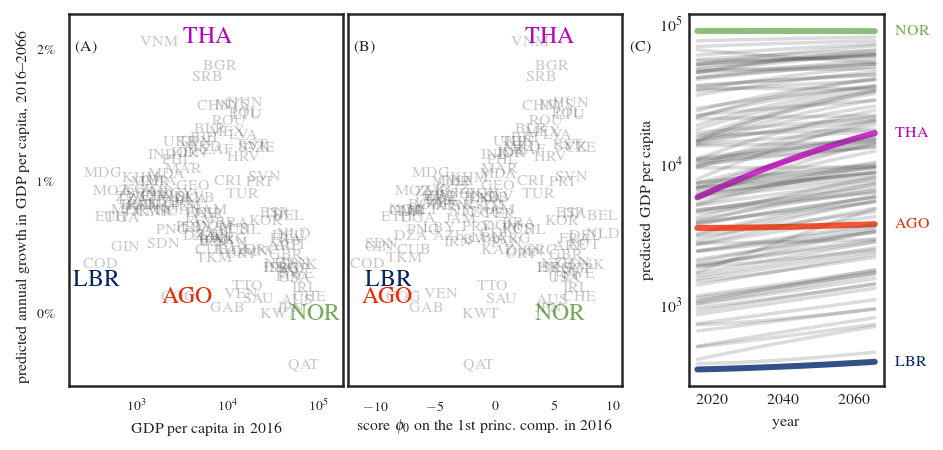

In [61]:
plt.figure(figsize=(TWO_COL_WIDTH * .86, ONE_COL_WIDTH))
gs1 = mpl.gridspec.GridSpec(1, 3)
gs1.update(left=0.02, right=1, wspace=0.02)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
gs2 = mpl.gridspec.GridSpec(1, 1)
gs2.update(left=0.75, right=0.98)
ax2 = plt.subplot(gs2[0])



end_year_index = 51
initial_year = rpop_df.index.get_level_values('year').max().year
highlight_certain_countries_growth = {
    'AGO': '#ef2a00',
#     'IND': '#ff9933',
    'THA': 'm',
    'LBR': (0., 0.14509804, 0.40784314),
    'NOR': (116 / 255., 171 / 255., 91 / 255.)#(0.5019607843137255, 0.6941176470588235, 0.8274509803921568)
}

#countries_to_highlight = ['LBR', 'NOR', 'IND', 'AGO']
it_pred_highlight = {c: iterated_predictions[c] for c in highlight_certain_countries_growth}
it_pred_gray = {c: iterated_predictions[c] for c in iterated_predictions if c not in highlight_certain_countries_growth}


for c in iterated_predictions:
    is_highlighted = c in highlight_certain_countries_growth
    color = highlight_certain_countries_growth[c] if is_highlighted else '.3'
    initial_gdppc = iterated_predictions[c][0, -1]
    final_gdppc = iterated_predictions[c][-1, -1]
    change = final_gdppc - initial_gdppc
    growth_rate = 100 * (-1 + 10**(change / len(iterated_predictions[c] - 1)))
    ax0.scatter(
        [10**initial_gdppc], [growth_rate],
        color=color, alpha=0.0)
    if not is_highlighted:
        ax0.text(s=c, x=10**initial_gdppc, y=growth_rate, color=color, ha='center', va='center', size=8, alpha=.3)
    else:
        ax0.text(s=c, x=10**initial_gdppc, y=growth_rate, color=color,
                ha='center', va='center', size=12, weight='bold')

    initial_score_pc0 = iterated_predictions[c][0, 0]
    ax1.scatter([initial_score_pc0], [growth_rate], color=color, alpha=0)
    if not is_highlighted:
        ax1.text(s=c, x=initial_score_pc0, y=growth_rate, color=color, ha='center', va='center', size=8, alpha=.3)
    else:
        ax1.text(s=c, x=initial_score_pc0, y=growth_rate, color=color,
                ha='center', va='center', size=12, weight='bold')
        
    gdppc_values = 10**iterated_predictions[c][:end_year_index, 2]
    years = np.arange(initial_year, initial_year + end_year_index)
    if is_highlighted:
        ax2.plot(years, gdppc_values, color=color, alpha=.8, lw=3)
        ax2.annotate(s=c, xy=(years[-1], gdppc_values[-1]), xycoords='data',
                     xytext=(10, 0), textcoords='offset points', color=color, va='center')
    else:
        ax2.plot(years, gdppc_values, color=color, alpha=.2)

ax1.get_yaxis().set_visible(False)
for i, axis in enumerate([ax0, ax1]):
    if i == 0:
        axis.set_xscale('log')
        axis.set_xlim(180, 180000)
    axis.yaxis.set_major_formatter(FuncFormatter(format_percent_tick_label))
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))

ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=8, pad=3)
ax2.set_xlabel('year')
ax2.set_ylabel('predicted GDP per capita'
#               + ' (constant 2010 USD / person / year)'
)

ax0.set_ylabel(r'predicted annual growth in GDP per capita, {}--{}'.format(
    initial_year, initial_year + end_year_index - 1), y=.48)
ax0.set_xlabel(r'GDP per capita' #+ ' (constant 2010 USD person$^{-1}$ year$^{-1}$)
                 + ' in ' + str(initial_year))#, x=-.1)
ax1.set_xlabel(r'score ${score_pc0}$ on the 1st princ.\ comp.\ in '.format(**VARIABLE_NOTATION) + str(initial_year))#, x=-.1)
ax0.annotate(s='(A)', xy=(.02, .90), xycoords='axes fraction')
ax1.annotate(s='(B)', xy=(.02, .90), xycoords='axes fraction')
ax2.annotate(s='(C)', xy=(-.3, .90), xycoords='axes fraction')

path = os.path.join(path_manuscript_figures,
                    'predicted_annual_growth_rates_highlight_GDPpc_and_pc0.pdf')

plt.gcf().savefig(path, bbox_inches='tight', dpi=300)

### Plots of errors

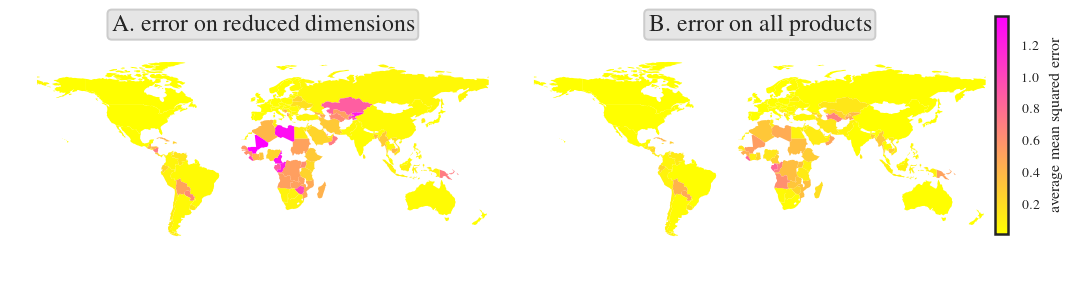

In [62]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

use_full_dimensions = False
cm = plt.get_cmap('spring_r')

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)

fig, axes = plt.subplots(
    1, 2,
    figsize=(TWO_COL_WIDTH * 1.3, TWO_COL_WIDTH * 1.3),
    subplot_kw=dict(projection=ccrs.PlateCarree()))

average_errors_by_country_reduced = (pm.compute_residuals(
    use_full_dimensions=False).fillna(0).apply(lambda x: x**2).mean(axis=1).mean(level=0).sort_values())

value_dict_reduced = {
        country.attributes['adm0_a3_is']: (
            country.geometry, average_errors_by_country_reduced[country.attributes['adm0_a3_is']])
        for country in shpreader.Reader(countries_shp).records()
        if country.attributes['adm0_a3_is'] in average_errors_by_country_reduced}

average_errors_by_country_full_dimensions = (pm.compute_residuals(
    use_full_dimensions=True).fillna(0).apply(lambda x: x**2).mean(axis=1).mean(level=0).sort_values())

value_dict_full_dimensions = {
        country.attributes['adm0_a3_is']: (
            country.geometry, average_errors_by_country_full_dimensions[country.attributes['adm0_a3_is']])
        for country in shpreader.Reader(countries_shp).records()
        if country.attributes['adm0_a3_is'] in average_errors_by_country_full_dimensions}

max_value = max([x[1] for value_dict in [value_dict_reduced, value_dict_full_dimensions] for x in value_dict.values()])
min_value = min([x[1] for value_dict in [value_dict_reduced, value_dict_full_dimensions] for x in value_dict.values()])

norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value)

for i, (ax, value_dict, label) in enumerate(zip(axes, [value_dict_reduced, value_dict_full_dimensions], ['A. error on reduced dimensions', 'B. error on all products'])):

    for country_code, (geom, value) in value_dict.items():
        facecolor = cm(norm(value))
        ax.add_geometries(geom, ccrs.PlateCarree(),
                          facecolor=facecolor,)

    if i == 1:
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm._A = []
        cbaxes = fig.add_axes([0.89, 0.45, 0.01, 0.17])  # left, bottom, width, height
        cb = plt.colorbar(sm, cax=cbaxes, label='average mean squared error')
#        cb = plt.colorbar(sm, ax=ax, )
    ax.outline_patch.set_visible(False)
    ax.set_title(label, bbox=BBOX_LABELS)
fig.subplots_adjust(wspace=0, hspace=-.5)
path = os.path.join(path_manuscript_figures,
                    'errors_averaged_by_country.pdf')
fig.savefig(path, bbox_inches='tight', dpi=300)

### Understand the principal components

In [64]:
pca_all = PCA(n_components=rpop_df_logged_scaled.shape[1])
pca_all.fit(slice_training_set_for_preprocessing(rpop_df_logged_scaled))

pca_all.components_[0] *= -1

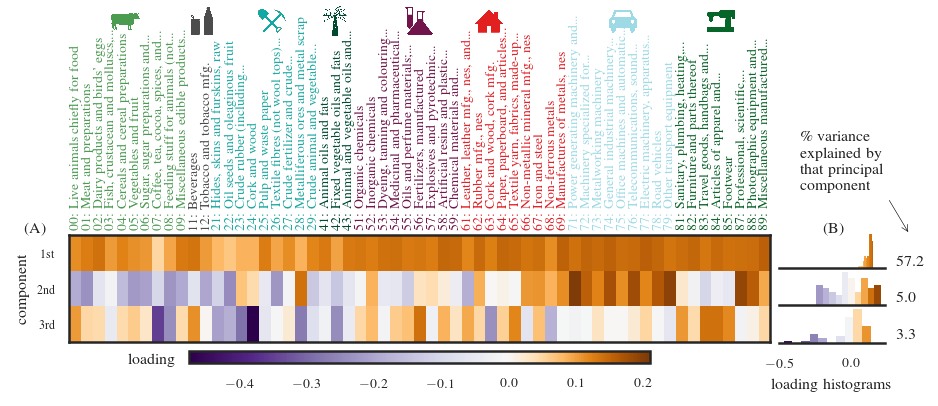

In [65]:
product_1digit_colors = [product_code_to_1digit_color[p] for p in rpop_df_logged_scaled.columns]

icon_path = os.path.join(
    os.pardir, 'data', 'raw', 'exports',
    'sitc_classifications_icons')

icon_height = 3.
icon_files_positions = [
    ('cow', 'dark_green_cow.png', (0.08, icon_height)),
    ('beverages', 'community_1000_gray.png', (0.19, icon_height)),
    ('crude_materials', 'community_2000_teal.png', (0.29, icon_height)),
    ('plant_oils', 'palm_tree_green.png', (0.38, icon_height)),
    ('chemicals', 'community_5000.png', (0.5, icon_height)),
    ('manufactured', 'community_6000.png', (0.60, icon_height)),
    ('car', 'community_7000.png', (0.79, icon_height)),
    ('sewing', 'community_60.png', (0.93, icon_height)),
]

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

product_names = ['{}: {}'.format(p, product_code_to_name[str(p)]).replace('manufactures', 'mfg.')
                 for p in rpop_df_logged_scaled.columns]
i = 0
labels = product_names if i == 0 else None
fig, ax = vis_dim_red.plot_loadings(
    pca_all.components_[:3], feature_labels=labels, feature_label_spacing=1,
    num_characters=38, 
    hist_bottom=0.2, hist_top=0.48,
    feature_label_colors=product_1digit_colors, xlabel='',
    A_label='(A)', B_label='(B)',
#    A_label=alphabet[i * 2], B_label=alphabet[i * 2 + 1],
    A_label_pos=(0.01, .48), B_label_pos=(.91, .48),
    figsize=(TWO_COL_WIDTH * .9, TWO_COL_WIDTH * .4), aspect=3)

# ax.annotate(
#     s='loadings of first 3 principal components on {} products'.format(rpop_df_logged_scaled.shape[1]),
#     xy=(.04, -.08), xycoords='axes fraction',
#     xytext=(.5, -0.18), textcoords='axes fraction',
#     ha='center', va='center',
# #     arrowprops=dict(arrowstyle="->", connectionstyle="arc,rad=-50"),
# )

for product, filename, xy in icon_files_positions:
    img = plt.imread(os.path.join(
        icon_path, filename))
    if filename == 'palm_tree_green.png':
        zoom = .012
    else:
        zoom=.07
    imagebox = OffsetImage(img, zoom=zoom)
    imagebox.image.axes = ax
    ab = AnnotationBbox(
        imagebox, xy,
        xycoords='axes fraction',
        frameon=False)
    ax.add_artist(ab)

ax.annotate(s='\% variance\nexplained by\nthat principal\ncomponent', xy=(1.2, 1),
            xycoords='axes fraction', ha='left',
            xytext=(-55, 23), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=30,armA=20,rad=10"))
for i, var_exp in enumerate((pca_all.explained_variance_ratio_)[:3]):
    ax.annotate(s='{:.1%}'.format(var_exp) + '\%', xy=(1.18, 0.72 - i * .34), xycoords='axes fraction')

path = os.path.join(path_manuscript_figures, 'pca_loadings.pdf')
fig.savefig(path, bbox_inches='tight', dpi=300)

#### averaged at 1-digit level

In [66]:
pca_components_df = pd.DataFrame(pca_all.components_, columns=rpop_df_logged_scaled.columns)

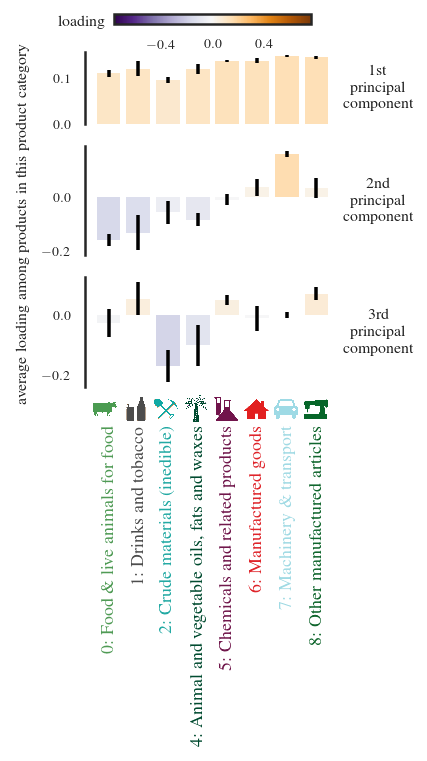

In [67]:
n_components = 3
pca_components_df_long = pca_components_df.T.reset_index()
pca_components_df_long['code_1digit'] = pca_components_df_long.product_code.str[0]
pca_components_df_long['code_2digit'] = pca_components_df_long.product_code.str[:2]

pca_components_df_long = pd.merge(
    pca_components_df_long,
    sitc_classifications.loc[:, ['code', 'name', 'name_short_en']].rename(
        columns={'code': 'product_code', 'name': 'name_4digit', 'name_short_en': 'name_short_4digit'}),
    on='product_code')

pca_components_df_long = pd.merge(
    pca_components_df_long,
    (sitc_classifications
     .loc[:, ['code', 'name', 'name_short_en', 'color_1digitlevel']]
     .rename(columns={'code': 'code_1digit', 'name': 'name_1digit', 'name_short_en': 'name_short_1digit'})),
    on='code_1digit', suffixes=('', '_1digit'))

pca_components_df_long = pd.merge(
    pca_components_df_long,
    (sitc_classifications
     .loc[:, ['code', 'name', 'name_short_en']]
     .rename(columns={'code': 'code_2digit', 'name': 'name_2digit', 'name_short_en': 'name_short_2digit'})),
    on='code_2digit', suffixes=('', '_1digit'))

mean_std_loading = pca_components_df_long.groupby(
    ['code_1digit', 'name_short_1digit'])[0,1,2].agg(['mean', 'std', 'size'])

#throwaway plot to get colormap
fig, ax = plt.subplots(figsize=(ONE_COL_WIDTH, ONE_COL_WIDTH))
cmap = mpl.cm.PuOr_r

loadings = pca_components_df.values
vmin = np.min(loadings)
vmax = np.max(loadings)
midpoint = 1 - vmax / (vmax + np.abs(vmin))
cmap = shifted_color_map(cmap, midpoint=midpoint)

axim = ax.matshow(loadings, cmap=cmap)
plt.clf()

fig, axes = plt.subplots(n_components, 1, figsize=(ONE_COL_WIDTH * 2/3, ONE_COL_WIDTH), sharex=True)
loadings_flat = pca_components_df.values.flatten()
vmin = np.min(loadings_flat)
vmax = np.max(loadings_flat)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for i in range(n_components):
    tick_labels = [
        '{}: {}'.format(code, name).replace('&', '\&')
        for (code, name) in mean_std_loading.index.values]
    pos = np.arange(len(tick_labels))

    mean_std = mean_std_loading.loc[:, i]
    x = range(len(mean_std.index))
    y = mean_std.loc[:, 'mean']
    col = norm(y)

    ax = axes[i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    barplot = ax.bar(
        x, y,
        color=cmap(col),
        yerr=mean_std.loc[:, 'std'] / mean_std.loc[:, 'size']**.5, align='center',
        tick_label=tick_labels)

cax, kwargs = mpl.colorbar.make_axes(
    [axes[0]], location='top', fraction=0.09,
    aspect=20,
    pad=.25)
cax.text(-0.04, 0.25, 'loading', ha='right', va='center', fontsize=8)
cb = plt.colorbar(axim, cmap=cmap, norm=norm, cax=cax,
                  orientation='horizontal', ticks=[-.8, -.4, 0, 0.4, 0.8])#, **kwargs)
# cb1 = mpl.colorbar.ColorbarBase(
#     axes[0], cmap=cmap, norm=norm, orientation='horizontal',)

axes[-1].set_xticklabels(tick_labels, fontsize=9, y=-.23)
# for xtick, color in zip(axes[-1].get_xticklabels(), sitc_colors.values()):
#     xtick.set_color(color)    

for xtick in axes[-1].get_xticklabels():
    color = product_code_to_1digit_color[xtick.get_text()[0]]
    xtick.set_color(color)
for tick in axes[-1].get_xticklabels():
    tick.set_rotation(90)
axes[-2].set(xlabel='')
#if dataset_id == 0:
fig.text(s='average loading among products in this product category', x=-.09, y=.8, rotation=90, fontsize=8)
for i, ordinal in enumerate(['1st', '2nd', '3rd']):
    axes[i].annotate(s=ordinal + '\nprincipal\ncomponent', xy=(1.15, .5), ha='center', va='center', xycoords='axes fraction', fontsize=8)


icon_height = 0.
icon_files_positions = [
    ('cow', 'dark_green_cow.png', (0.08, icon_height)),
    ('beverages', 'community_1000_gray.png', (0.19, icon_height)),
    ('crude_materials', 'community_2000_teal.png', (0.29, icon_height)),
    ('plant_oils', 'palm_tree_green.png', (0.38, icon_height)),
    ('chemicals', 'community_5000.png', (0.54, icon_height)),
    ('manufactured', 'community_6000.png', (0.68, icon_height)),
    ('car', 'community_7000.png', (0.84, icon_height)),
    ('sewing', 'community_60.png', (0.95, icon_height)),
]

for i, (product, filename, xy) in enumerate(icon_files_positions):
    img = plt.imread(os.path.join(
        icon_path, filename))
    if filename == 'palm_tree_green.png':
        zoom = .011
    else:
        zoom=.06
    imagebox = OffsetImage(img, zoom=zoom)
    imagebox.image.axes = ax
    xy = (0.08 + .118 * i, -.2)
    ab = AnnotationBbox(
        imagebox, xy,
        xycoords='axes fraction',
        frameon=False)
    ax.add_artist(ab)

path = os.path.join(path_manuscript_figures, 'PCA_loadings_grouped_1digit.pdf')
fig.savefig(path, bbox_inches='tight', dpi=300)

#### least, most loaded products

In [68]:
def plot_most_least_weighted(ax, loadings, vmin, vmax, cmap, include_xaxis_label=True):
    y_pos = np.arange(len(loadings))
    color_list = [
        cmap(v)
        for v in mpl.colors.Normalize(vmin=vmin, vmax=vmax)(loadings.values)]
    ax.barh(y_pos, loadings.values,
            color=color_list)
    if include_xaxis_label:
        ax.set_xlabel('loading')
    else:
        ax.spines['bottom'].set_visible(False)
    for i, (label, y) in enumerate(zip(loadings.index, y_pos)):
        x_pos = -.004 if i >= len(loadings) / 2 else .004
        ax.annotate(product_code_to_name[label], xy=(x_pos, y), xytext=(x_pos, y),
                    va='center', color=color_list[i],
                    ha=('right' if i >= len(loadings) / 2 else 'left'))
    ax.tick_params(
        axis='y', labelleft='off')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

def convert_to_nth(i, capitalize=False):
    first_ten = {
        1: 'first', 2: 'second', 3: 'third', 4: 'fourth', 5: 'fifth',
        6: 'sixth', 7: 'seventh', 8: 'eight', 9: 'ninth', 10: 'tenth'}
    if i in first_ten:
        result = first_ten[i]
    else:
        result = '{}th'.format(i)
    return capitalize_first_letter(result) if capitalize else result

    
def capitalize_first_letter(s):
    return s[0].upper() + s[1:]
    
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

def make_most_least_weighted_figure(
        pca_components_df, filename, n_top_bottom=10, components=[1, 2],
        pca_all=None, cmap=mpl.cm.PuOr_r, width=TWO_COL_WIDTH, increase_height_factor=1,
        alphabet_shift=0):
    pca_components_df = pca_components_df.iloc[components]
    
    vmin = pca_components_df.loc[components].min().min()
    vmax = pca_components_df.loc[components].max().max()
    
    components_top_bottom = [
        pd.concat([
            pca_components_df.loc[c].sort_values().iloc[:n_top_bottom],
            pca_components_df.loc[c].sort_values().iloc[-n_top_bottom:]])
        for c in components]

    fig, axes = plt.subplots(len(components), 1,
                             figsize=(width,
                                      width * increase_height_factor * len(components)),
                             sharex=True)
    fig.subplots_adjust(left=.2, right=.8, hspace=.1)
    ax = axes[0]
    plot_most_least_weighted(axes[0], components_top_bottom[0], vmin, vmax, cmap, include_xaxis_label=False)
    for i, comp in enumerate(components_top_bottom[1:]):
        plot_most_least_weighted(axes[i + 1], comp, vmin, vmax, cmap)

    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, component_number in enumerate(components):
        title = '{}. {} principal component'.format(
            alphabet[i + alphabet_shift], convert_to_nth(component_number + 1, True))
        axes[i].set_title(title, weight='bold', y=.98, fontsize=10)

    if filename:
        path = os.path.join(path_manuscript_figures, filename)
        fig.savefig(path, bbox_inches='tight')
    plt.show()

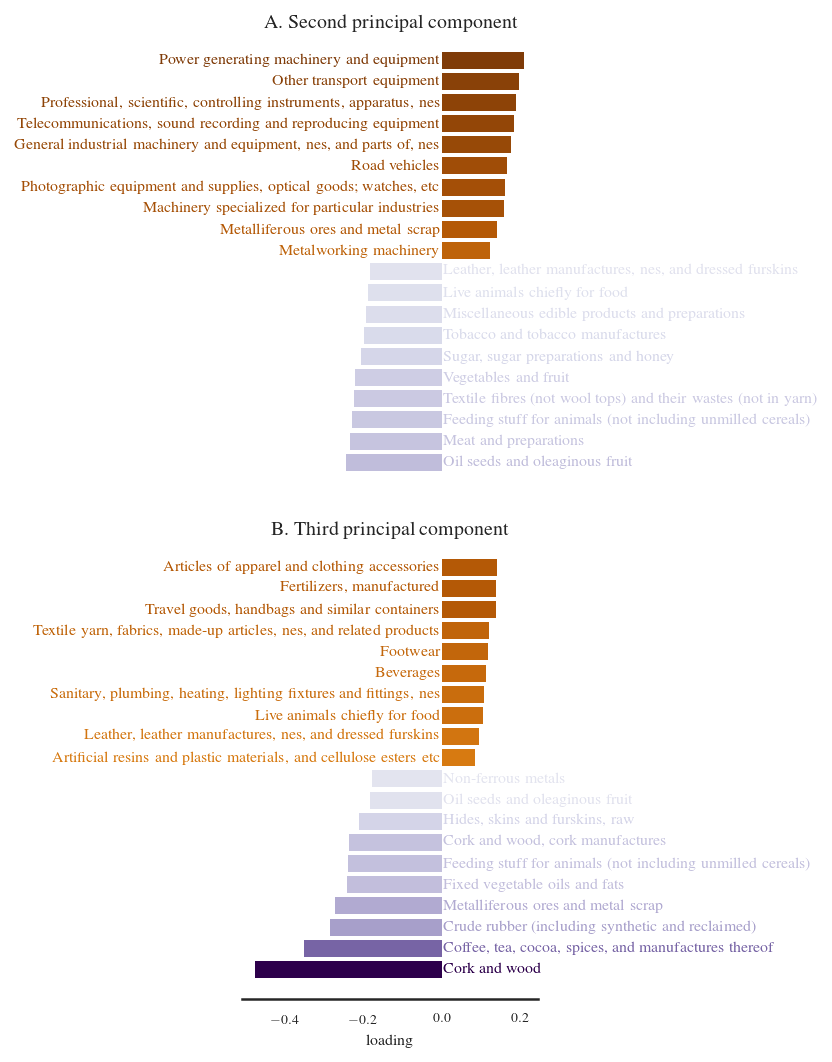

In [69]:
make_most_least_weighted_figure(
    pca_components_df, 'most_least_loaded.pdf',
    width=ONE_COL_WIDTH, components=[1, 2],
    increase_height_factor=1.3)

## Compare PCA and complexity indices 

### Compute revealed comparative advantage

First we compute revealed comparative advantage (RCA), which is the share of a product in a country's export basket divided by the share of that product in the global export basket.

In [70]:
def compute_revealed_comparative_advantage(panel):
    """Compute Revealed Comparative Advantage in a panel of export values.

    Given a panel dataset of export values, with items as countries,
    time as major_axis, and products as minor_axis, create a new panel
    containing the revealed comparative advantage.
    """
    export_rca_panel = panel.copy()

    # Sum exports over all countries (sum_c X_cpt)
    export_market_size_by_year_and_product = panel.sum(axis='items')

    # Series of the total global exports each year (sum_cp X_cpt)
    export_market_size_by_year = panel.sum(axis='items').sum(axis='columns')

    for country in panel.items:
        export_rca_panel.loc[country] = (
            panel.loc[country]
                 # Divide by the size of the export basket of this country
                 .div(panel.loc[country].sum(axis='columns'), axis=0)
                 # Multiply by the size of the global exports in each year
                 .mul(export_market_size_by_year, axis=0)
                 # Divide by the size of the product market size in each year
                 .div(export_market_size_by_year_and_product))

    return export_rca_panel

In [71]:
rca_panel_2digits = compute_revealed_comparative_advantage(panel_export_value)

### Plot countries' score on the first principal component against diversification (number of products that the country exports with RCA > 1), log(export value per capita), Economic Complexity Index

First, compute diversification:

In [72]:
diversification_2digits = pd.DataFrame((rca_panel_2digits > 1).sum(axis='minor_axis').stack(), columns=['diversification_RCA'])

pc0_score_series = pm.X.loc[:, (1, 'component_0')]
pc0_score_series.names = None
pc0_score_series.name = 'pc0_score'

diversification_and_pc0_score = pd.merge(
    diversification_2digits.reset_index(),
    pd.DataFrame(pc0_score_series).reset_index(),
    on=['country_code', 'year'])

Next, the extract the complexity index, and compute export value per capita:

In [73]:
# Economic Complexity Index
pc0_score_df = pd.DataFrame(pc0_score_series).reset_index()
pc0_score_df = pc0_score_df.assign(year=pc0_score_df.year.apply(lambda t: t.year))

pc0_eci = pd.merge(
    data_from_CID.groupby(['country_code', 'year'])['eci'].first().reset_index(),
    pc0_score_df,
    on=['country_code', 'year'])

# Export value per capita
total_export_value_per_capita_wide = panel_export_value.sum('minor_axis').div(population_data, axis=1)

total_export_value_per_capita_long = (
    total_export_value_per_capita_wide
    .stack().reset_index()
    .rename(columns={0: 'export_value_per_capita'})
    .query('export_value_per_capita > 0'))

pc0_export_per_capita = pd.merge(
    pc0_score_df,
    total_export_value_per_capita_long.assign(
        year=total_export_value_per_capita_long.year.apply(lambda t: t.year),
        log10_export_value_per_capita=total_export_value_per_capita_long.export_value_per_capita.apply(np.log10)),
    on=['country_code', 'year'])

Merge them into one dataframe:

In [74]:
pc0_eci_export_per_capita_diversification = pd.merge(pc0_eci, pc0_export_per_capita, how='inner').merge(
    diversification_and_pc0_score.assign(year=diversification_and_pc0_score.year.apply(lambda y: y.year)))

Make figure SI-6:

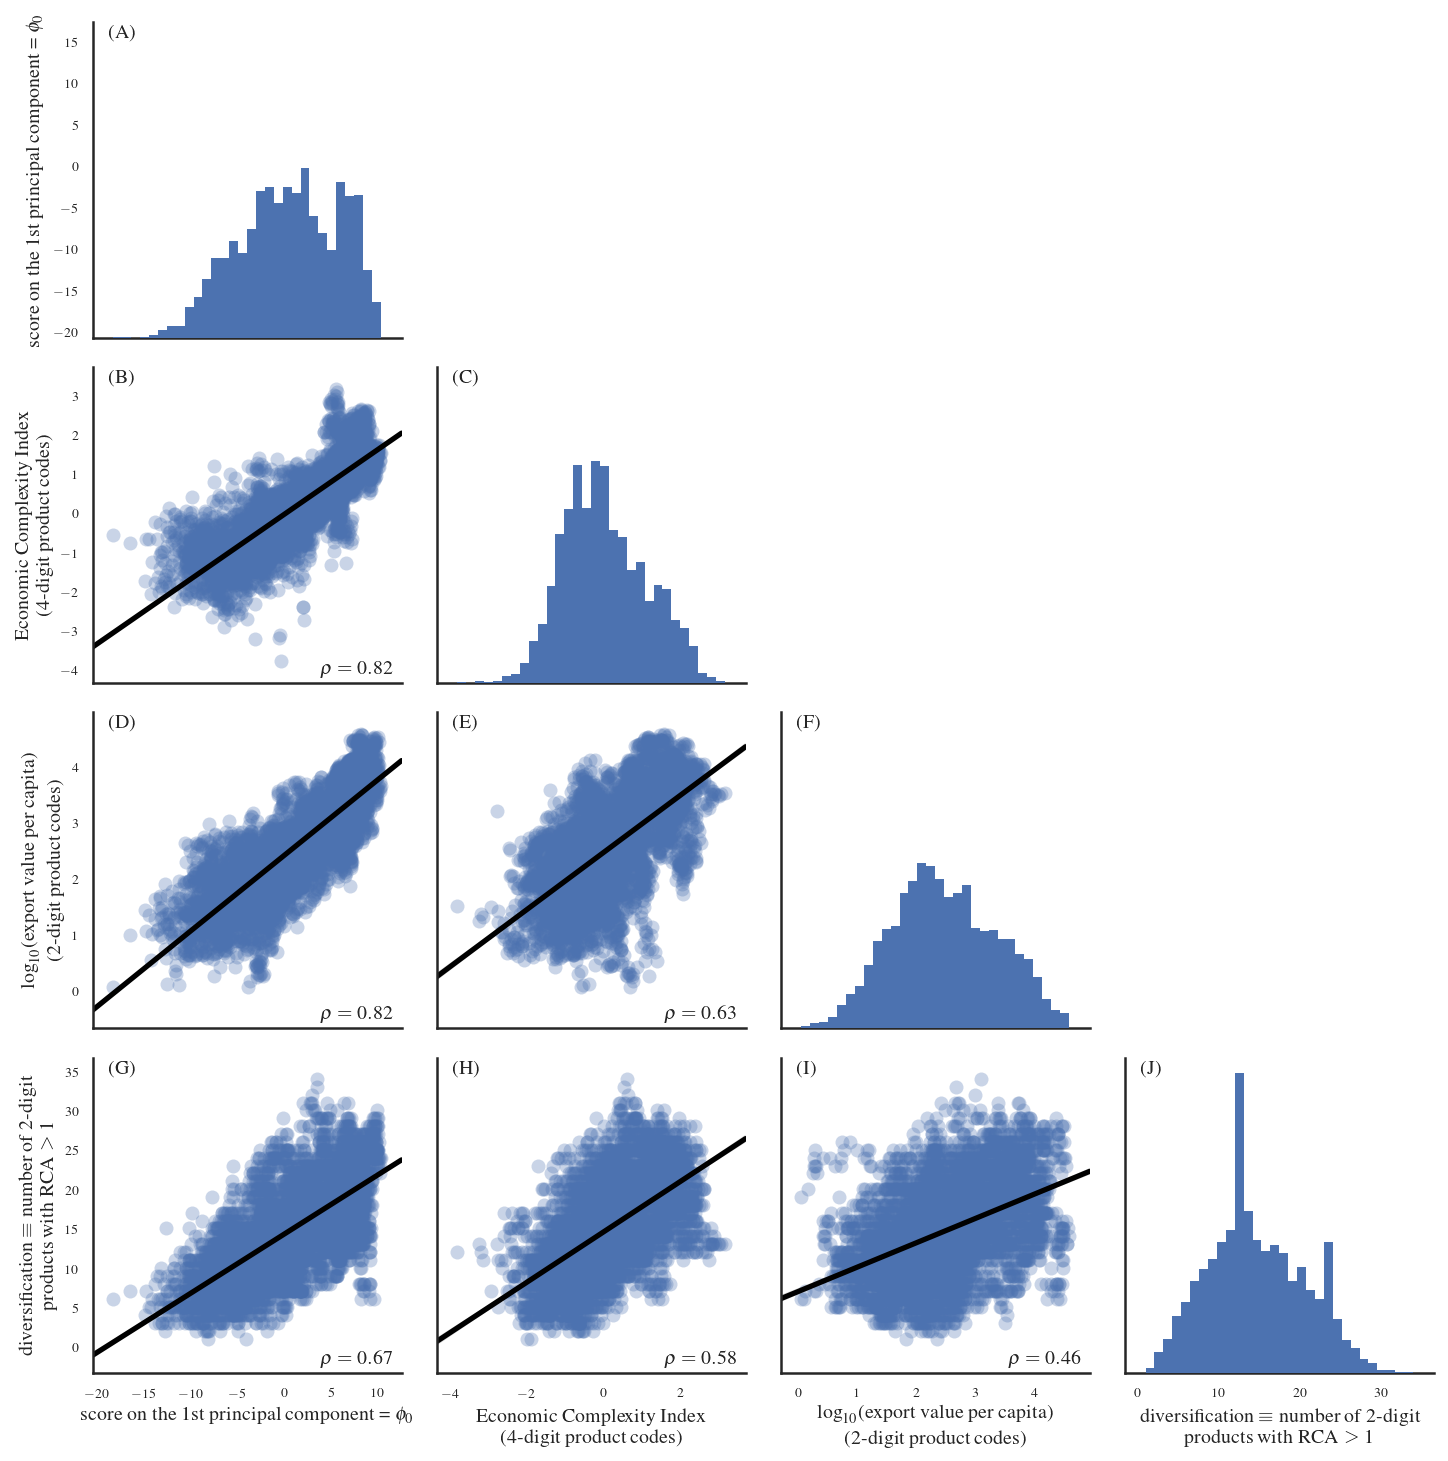

In [77]:
variables = ['pc0_score', 'eci', 'log10_export_value_per_capita', 'diversification_RCA']
g = sns.pairplot(
    pc0_eci_export_per_capita_diversification, kind='reg',
    vars=variables,
    diag_kws=dict(bins=30),
    plot_kws=dict(scatter_kws=dict(alpha=.3), line_kws=dict(color='k')))
labels = ['score on the 1st principal component = ${score_pc0}$'.format(**VARIABLE_NOTATION),
          'Economic Complexity Index \n(4-digit product codes)',
          r'$\log_{10}$(export value per capita) ' + '\n(2-digit product codes)',
          r'diversification $\equiv$ number of 2-digit' + '\n' + r'products with RCA $> 1$']
for ax, label in zip(g.axes[:, 0], labels):
    ax.set_ylabel(label, fontsize=annotate_text_size + 2)
for ax, label in zip(g.axes[-1], labels):
    ax.set_xlabel(label, fontsize=annotate_text_size + 2)
for i, var_x in enumerate(variables):
    for j, var_y in enumerate(variables):
#         if i == 3:
#             ax.set_xlabel(var_x)
#         elif j == 0:
#             ax.set_ylabel(var_y)
        if i != j:
            rho, __ = pearsonr(
                pc0_eci_export_per_capita_diversification.loc[:, var_x],
                pc0_eci_export_per_capita_diversification.loc[:, var_y])
            g.axes[i, j].annotate(s=r'$\rho = {:.2f}$'.format(rho), xy=(.97, 0),
                                  xytext=(0, 3), textcoords='offset points',
                                  xycoords='axes fraction', ha='right', va='bottom', fontsize=annotate_text_size + 2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
for (i, j), letter in zip(zip(*np.tril_indices_from(g.axes, 0)), 'ABCDEFGHIJ'):
    g.axes[i, j].annotate(s='({})'.format(letter), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=annotate_text_size + 2)
path = os.path.join(path_manuscript_figures, 'correlate_score_first_pc_with_others.pdf')
g.fig.savefig(path, bbox_inches='tight', dpi=300)

### Compare product complexity index (PCI) and with PCA loadings

#### compute PCI at 2-digit level

Create a timeseries of Product Complexity Index (PCI) of each product:

In [78]:
from scipy.linalg import eig

def compute_complexity_index(df):
    # drop rows and columns with all missing values
    df_missing_dropped = df.dropna(axis=0, how='all').dropna(axis=1, how='all')
    
    # threshold at 1
    df_missing_dropped = (df_missing_dropped > 1).astype(float)

    row_sums = df_missing_dropped.sum(1)
    col_sums = df_missing_dropped.sum(0)

    df_row_stochastic = df_missing_dropped.div(row_sums, axis=0)
    df_col_stochastic = df_missing_dropped.div(col_sums, axis=1)

    dotted = df_col_stochastic.dot(df_row_stochastic.T)

    return compute_left_eigenvector_of_second_largest_eigenvalue(dotted)


def compute_left_eigenvector_of_second_largest_eigenvalue(df):
    eigenvalues, left_eigenvectors = eig(df, left=True, right=False)
    index_of_second_largest_real_part_of_eigenvalue = eigenvalues.real.argsort()[-2]
    left_eigenvector_of_second_largest_eigenvalue = left_eigenvectors[:, index_of_second_largest_real_part_of_eigenvalue]

    return pd.Series(left_eigenvector_of_second_largest_eigenvalue.real, df.index)

product_ubiquity_timeseries = (rca_panel_2digits > 1).sum(axis='items')

pci_each_year = []

for year in rca_panel_2digits.major_axis:
    pci = compute_complexity_index(rca_panel_2digits.loc[:, year])
    product_ubiquities = product_ubiquity_timeseries.loc[year]
    
    # standardize the sign of PCI so that it's negatively correlated with ubiquity
    pci = pci * np.sign(-1 * np.corrcoef(product_ubiquities, pci)[0, 1])

    pci_single_year = pd.DataFrame(
        {
            'pci': pci,
            'pci_zscore': (pci - pci.mean()) / pci.std(),
            'ubiquity': product_ubiquities,
        }
    ).assign(year=pd.Period(year, freq='A'))

    pci_each_year.append(pci_single_year.reset_index())

pci_timeseries = pd.concat(pci_each_year)

The PCI value is the column `'pci_zscore'`:

In [79]:
pci_timeseries.head()

product_code       pci  pci_zscore  ubiquity year
0           00 -0.069529   -0.987083        26 1962
1           01 -0.059043   -0.900560        22 1962
2           02  0.041720   -0.069142        16 1962
3           03 -0.055262   -0.869361        38 1962
4           04 -0.085342   -1.117560        20 1962

#### Plot PCI (averaged across all years) versus loading on the first and second principal components:

In [80]:
loadings_pre1988 = pd.DataFrame(
    {
        'pc0_loading': pca_all.components_[0],
        'pc1_loading': pca_all.components_[1]
    },
    index=rpop_df_logged_scaled.columns, )

In [81]:
PCA_loadings_and_mean_PCI = loadings_pre1988.assign(
    mean_pci=pci_timeseries.groupby('product_code')['pci_zscore'].mean(),
    mean_pci_pre_1989=pci_timeseries[pci_timeseries.year < pd.Period('1989')].groupby('product_code')['pci_zscore'].mean()
)

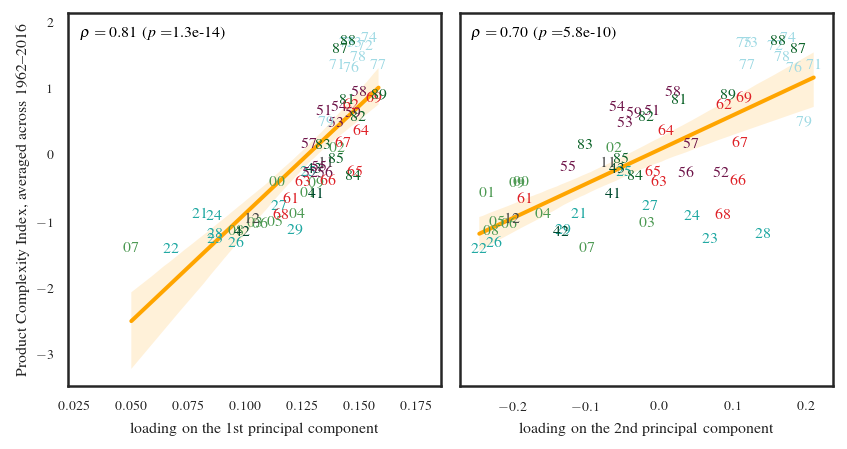

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH), sharey=True)

y = 'mean_pci'
df = PCA_loadings_and_mean_PCI

for ax, x in zip(axes, ['pc0_loading', 'pc1_loading']):
    sns.regplot(data=df, x=x, y=y, ci=95, line_kws=dict(color='orange', lw=2), scatter_kws=dict(alpha=0), ax=ax, truncate=True)
    pearson_corr_coef, pvalue = pearsonr(
        df.loc[:, x],
        df.loc[:, y])
    ax.annotate(
        s=r'$\rho = {:.2f}$ ($p = ${:.2g})'.format(pearson_corr_coef, pvalue),
        xy=(.03, .95), ha='left', va='center', xycoords='axes fraction', color='k')
    for product_code, row in df.iterrows():
        x_val = row[x]
        y_val = row[y]
        ax.annotate(s=product_code, xy=(x_val, y_val), color=product_code_to_1digit_color[product_code],
                    ha='center', va='center')
    ax.set_xlabel('loading on the {} principal component'.format('1st' if x == 'pc0_loading' else '2nd'))

axes[0].set_ylabel('Product Complexity Index, averaged across 1962--2016')
axes[1].set_ylabel('')
fig.subplots_adjust(wspace=.05)
path = os.path.join(path_manuscript_figures, 'mean_product_complexity_index_vs_PCA_loadings_OLS.pdf')
#fig.savefig(path, bbox_inches='tight', dpi=300)

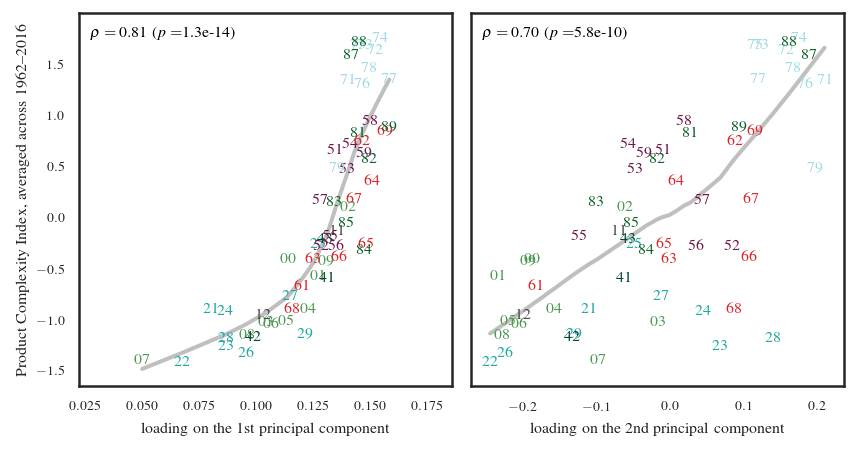

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH), sharey=True)

y = 'mean_pci'
df = PCA_loadings_and_mean_PCI

for ax, x in zip(axes, ['pc0_loading', 'pc1_loading']):
    sns.regplot(data=df, x=x, y=y, ci=95, lowess=True, line_kws=dict(color='.5', alpha=.5, lw=2), scatter_kws=dict(alpha=0), ax=ax, truncate=True)
    pearson_corr_coef, pvalue = pearsonr(
        df.loc[:, x],
        df.loc[:, y])
    ax.annotate(
        s=r'$\rho = {:.2f}$ ($p = ${:.2g})'.format(pearson_corr_coef, pvalue),
        xy=(.03, .95), ha='left', va='center', xycoords='axes fraction', color='k')
    for product_code, row in df.iterrows():
        x_val = row[x]
        y_val = row[y]
        ax.annotate(s=product_code, xy=(x_val, y_val), color=product_code_to_1digit_color[product_code],
                    ha='center', va='center')
    ax.set_xlabel('loading on the {} principal component'.format('1st' if x == 'pc0_loading' else '2nd'))

axes[0].set_ylabel('Product Complexity Index, averaged across 1962--2016')
axes[1].set_ylabel('')
fig.subplots_adjust(wspace=.05)
path = os.path.join(path_manuscript_figures, 'pci_vs_loading_on_pc0.pdf')
fig.savefig(path, bbox_inches='tight', dpi=300)

Check whether the results are robust to slicing only PCI values for years < 1989 (they are):

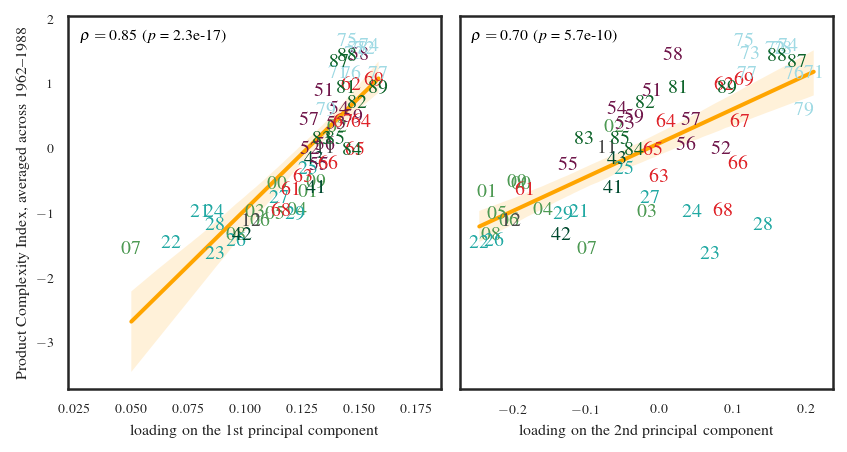

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH), sharey=True)

y = 'mean_pci_pre_1989'
df = PCA_loadings_and_mean_PCI

for ax, x in zip(axes, ['pc0_loading', 'pc1_loading']):
    sns.regplot(data=df, x=x, y=y, ci=95, line_kws=dict(color='orange', lw=2), scatter_kws=dict(alpha=0), ax=ax, truncate=True)
    pearson_corr_coef, pvalue = pearsonr(
        df.loc[:, x],
        df.loc[:, y])
    ax.annotate(
        s=r'$\rho = {:.2f}$ ($p$ = {:.2g})'.format(pearson_corr_coef, pvalue),
        xy=(.03, .95), ha='left', va='center', xycoords='axes fraction', color='k')
    for product_code, row in df.iterrows():
        x_val = row[x]
        y_val = row[y]
        ax.annotate(s=product_code, xy=(x_val, y_val), color=product_code_to_1digit_color[product_code], size=10,
                    ha='center', va='center')
    ax.set_xlabel('loading on the {} principal component'.format('1st' if x == 'pc0_loading' else '2nd'))

axes[0].set_ylabel('Product Complexity Index, averaged across 1962--1988')
axes[1].set_ylabel('')
fig.subplots_adjust(wspace=.05)

### export data for analysis in R

The script `Use mgcv to determine how to transform the target.R` (in the folder `notebooks/data_for_use_with_mgcv_in_R`) uses the [R package `mgcv`](https://cran.r-project.org/web/packages/mgcv/index.html) to determine whether and how to transform the target to make the response variable closer to normally distributed. In this case, we find that taking the square root of the target (while retaining the sign) makes it closer to normally distributed.

Below, we export data with the response variable **not** transformed by `target_transformer` (which took the sign-preserving square root) so that we can load the original data into R.

In [86]:
data_df = pm.X.copy()
data_df.columns = ['pc0_last_year', 'pc1_last_year', 'log10_gdp_per_capita_constant2010USD_last_year']
# target_df = pm.y.copy()
# target_df.columns = ['change_in_pc0', 'change_in_pc1', 'change_in_log10_gdp_per_capita_constant2010USD']
target_df = pd.DataFrame(
    pm.target_transformer.inverse_transform(pm.y),
    index=pm.y.index,
    columns=['change_in_pc0', 'change_in_pc1', 'change_in_log10_gdp_per_capita_constant2010USD'])

path_data_for_R = path_to_processed_data / 'data_for_use_with_mgcv_in_R'
path_data_for_R.mkdir(exist_ok=True)

pd.concat([data_df, target_df], axis=1).to_csv(str(
    path_data_for_R / 'Rpop__data_target__pca_2__target_is_difference_True.csv'))

## Robustness checks

### Compare with dummy models that predict the mean, median, or another quantile

Do a gridsearch over several dummy models to find the best one:

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [88]:
dummy_search = GridSearchCV(
    estimator=MultiOutputRegressor(DummyRegressor()),
    param_grid=[
        {'estimator__strategy': ['mean', 'median']},
        {'estimator__strategy': ['quantile'], 'estimator__quantile': np.linspace(.1, .9, 12)}
    ],
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=MultiTimeSeriesSplit(
        n_train_test_sets=5, first_split_fraction=.46,
        level_of_index_for_time_values='year'),
    verbose=1)

In [89]:
dummy_search.fit(pm.X, pm.y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.7s finished


GridSearchCV(cv=MultiTimeSeriesSplit(first_split_fraction=0.46,
           level_of_index_for_time_values='year', n_train_test_sets=5,
           times=PeriodIndex(['1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
             '1994', '1995',
             ...
             '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
             '2015', '2016'],
            dtype='period[A-DEC]', name='year', length=5323, freq='A-DEC'),
           verbose=0),
       error_score='raise',
       estimator=MultiOutputRegressor(estimator=DummyRegressor(constant=None, quantile=None, strategy='mean'),
           n_jobs=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'estimator__strategy': ['mean', 'median']}, {'estimator__quantile': array([ 0.1    ,  0.17273,  0.24545,  0.31818,  0.39091,  0.46364,
        0.53636,  0.60909,  0.68182,  0.75455,  0.82727,  0.9    ]), 'estimator__strategy': ['quantile']}],
       pre_dispatch='2*n_jobs', refit=True, return_

In [90]:
dummy_search.best_params_

{'estimator__strategy': 'mean'}

In [91]:
dummy_cv_results = pd.DataFrame(dummy_search.cv_results_).sort_values('rank_test_score')

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users

Compare the train and test scores of the GAM model and this dummy model:

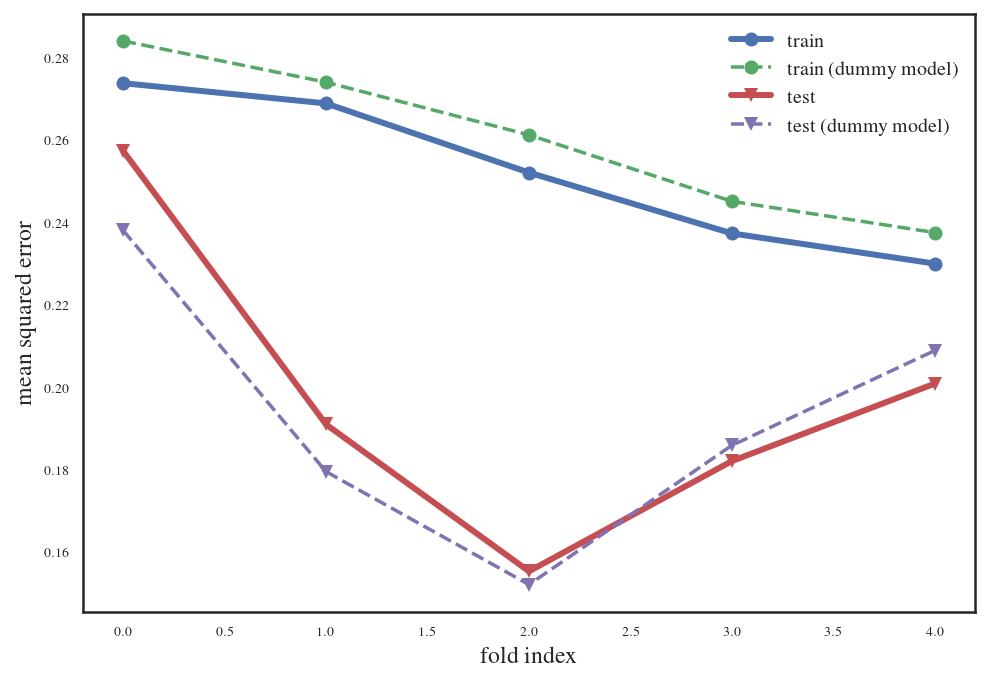

In [92]:
dummy_train_scores = pd.DataFrame(dummy_cv_results).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_train_score').sort_index().values
dummy_test_scores = pd.DataFrame(dummy_cv_results).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_test_score').sort_index().values

plt.plot(range(5), -train_scores, label='train', marker='o', lw=3)
plt.plot(range(5), -dummy_train_scores, label='train (dummy model)', marker='o', ls='--')
plt.plot(range(5), -test_scores, label='test', marker='v', lw=3)
plt.plot(range(5), -dummy_test_scores, label='test (dummy model)', marker='v', ls='--')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('fold index', fontsize=12)
plt.legend()
plt.show()

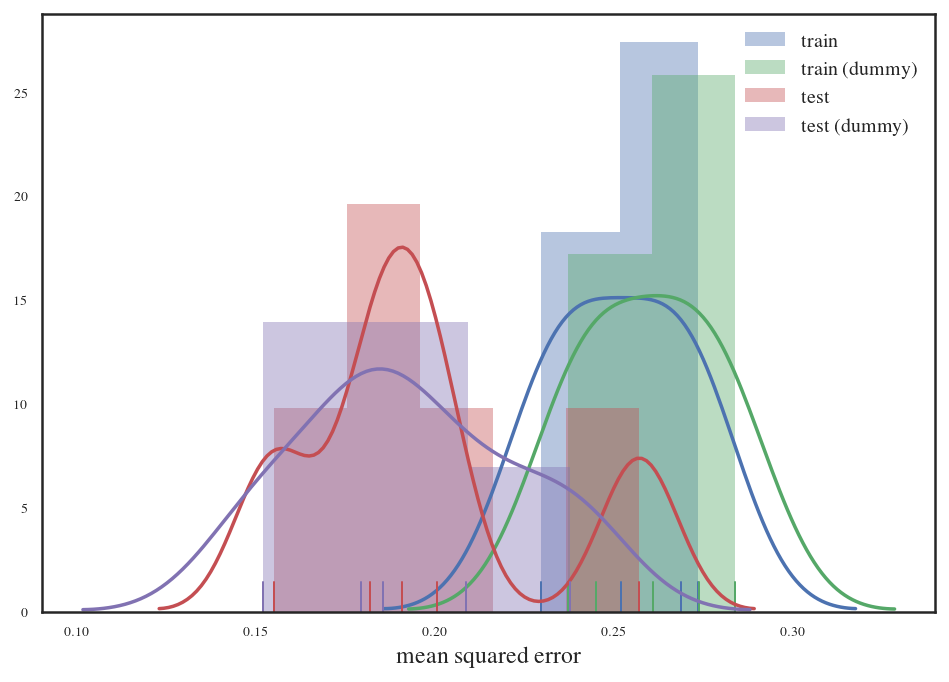

In [93]:
sns.distplot(
    pd.DataFrame(pm.cv_results).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_train_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='train')

sns.distplot(
    pd.DataFrame(dummy_cv_results).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_train_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='train (dummy)')

sns.distplot(
    pd.DataFrame(pm.cv_results).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_test_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='test')

sns.distplot(
    pd.DataFrame(dummy_cv_results).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_test_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='test (dummy)')

plt.xlabel('mean squared error', fontsize=12)
plt.legend()
plt.show()

#### Compare train and test scores

The GAM-based model's training scores are 0.46 standard deviations better (p-value 0.32) and test scores are 0.13 standard deviations better (p-value 0.55), so there is not strong evidence in favor of the GAM-based model.

##### compare train scores

In [98]:
-train_scores.mean(), -dummy_train_scores.mean()

(0.25239633434261799, 0.26036738659438619)

In [108]:
num_std_difference_train = (-train_scores.mean() - (-dummy_train_scores.mean())) / train_scores.std()
num_std_difference_train

-0.46673790130734583

In [109]:
norm_rv.cdf(num_std_difference_train)

0.32034370475089247

##### compare test scores

In [87]:
-test_scores.mean(), -dummy_test_scores.mean()

(0.19728555919610186, 0.19285880994118093)

In [106]:
num_std_difference_test = (-test_scores.mean() - (-dummy_test_scores.mean())) / test_scores.std()
num_std_difference_test

0.13164643914941052

In [107]:
norm_rv.cdf(num_std_difference_test)

0.55236802398716589

#### Compare coefficient of determination

In [110]:
splitter = copy(mtss).split(pm.X, pm.y)

dummy_r2_train, dummy_r2_test, gam_r2_train, gam_r2_test, xticklabels = [], [], [], [], []
for i, (train, test) in enumerate(splitter):
    train_years = pm.X.iloc[train].index.get_level_values('year')
    test_years = pm.X.iloc[test].index.get_level_values('year')
    xticklabels.append(
        'Split {}\nTrain: {}--{}\nTest: {}--{}'.format(
            i,
            train_years.min() - 1, train_years.max(),
            test_years.min() - 1, test_years.max()))
    dummy_r2_train.append(r2_score(
        pm.y.iloc[train].values,
        dummy_search.best_estimator_.predict(pm.X.iloc[train]),
        multioutput='raw_values'))
    dummy_r2_test.append(r2_score(
        pm.y.iloc[test].values,
        dummy_search.best_estimator_.predict(pm.X.iloc[test]),
        multioutput='raw_values'))
    gam_r2_train.append(r2_score(
        pm.y.iloc[train].values,
        pm.best_model.predict(pm.X.iloc[train]),
        multioutput='raw_values'))
    gam_r2_test.append(r2_score(
        pm.y.iloc[test].values,
        pm.best_model.predict(pm.X.iloc[test]),
        multioutput='raw_values'))
    
dummy_r2_train = np.array(dummy_r2_train)
dummy_r2_test = np.array(dummy_r2_test)
gam_r2_train = np.array(gam_r2_train)
gam_r2_test = np.array(gam_r2_test)

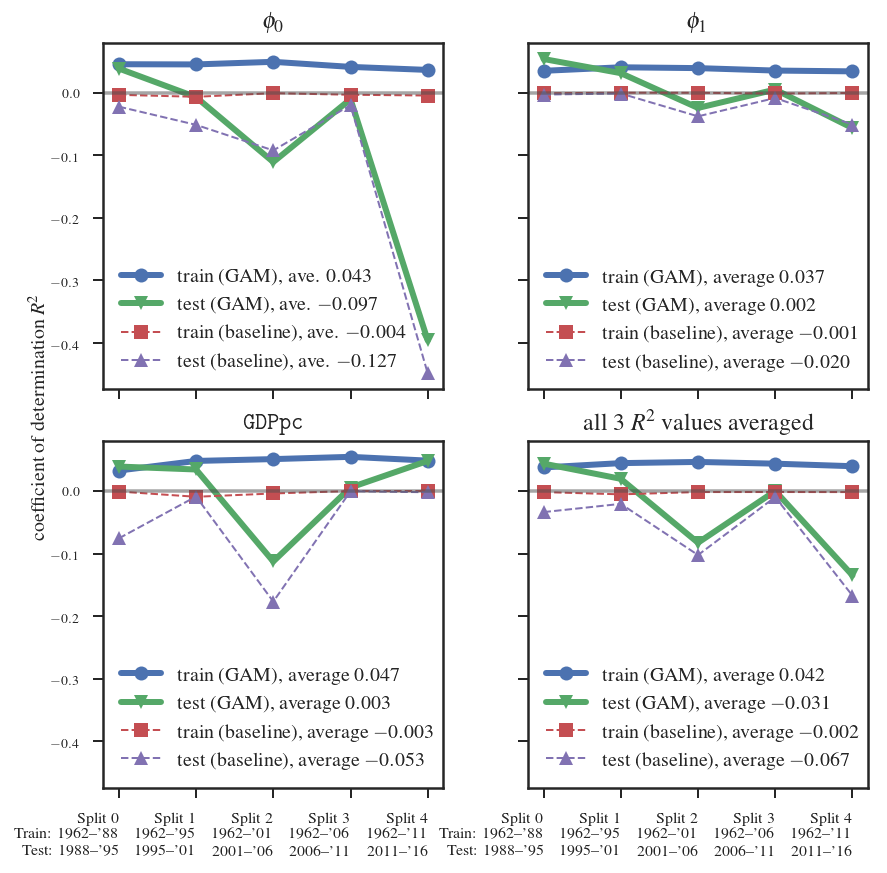

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(TWO_COL_WIDTH, TWO_COL_WIDTH), sharex=True, sharey=True)

labels = [VARIABLE_NOTATION[x] for x in ['score_pc0', 'score_pc1', 'gdppc']] + [r'all 3 $R^2$ values averaged']
for i, (ax, label) in enumerate(zip(axes.flatten(), labels)):
    if i <= 2:
        yvalue_fn = lambda x: x[:, i]
    else:
        yvalue_fn = lambda x: x.mean(1)
    ax.set_title(label)
    ax.plot(yvalue_fn(gam_r2_train), lw=3, marker='o', label=r'train (GAM), {} ${:.3f}$'.format('average' if i else 'ave.', yvalue_fn(gam_r2_train).mean()))
    ax.plot(yvalue_fn(gam_r2_test), lw=3, marker='v', label=r'test (GAM), {} ${:.3f}$'.format('average' if i else 'ave.', yvalue_fn(gam_r2_test).mean()))
    ax.plot(yvalue_fn(dummy_r2_train), lw=1, marker='s', ls='--', label=r'train (baseline), {} ${:.3f}$'.format('average' if i else 'ave.', yvalue_fn(dummy_r2_train).mean()))
    ax.plot(yvalue_fn(dummy_r2_test), lw=1, marker='^', ls='--', label=r'test (baseline), {} ${:.3f}$'.format('average' if i else 'ave.', yvalue_fn(dummy_r2_test).mean()))
    ax.axhline(0, alpha=.5, color='.3')
    ax.set_xticks([i for i in range(5)])
    ax.tick_params(axis='both', length=5)
    ax.legend()
    ax.set_xticklabels([
        l.replace('--19', '--\'').replace('--20', '--\'').replace('Train: ', 'Train: ' if not j else '').replace('Test: ', 'Test: ' if not j else '')
        for j, l in enumerate(xticklabels)], ha='right', fontsize=annotate_text_size)
fig.subplots_adjust(wspace=.25, hspace=.15)
fig.text(s=r'coefficient of determination $R^2$', rotation=90, x=.06, y=.5, ha='center', va='center', fontsize=annotate_text_size + 2)
fig.savefig(os.path.join(path_manuscript_figures, 'R2.pdf'), bbox_inches='tight')

In [113]:
mean_r2 = pd.DataFrame(
    np.array([
        gam_r2_train.mean(1),
        gam_r2_test.mean(1),
        dummy_r2_train.mean(1),
        dummy_r2_test.mean(1)
    ]).T,
    columns=pd.MultiIndex.from_tuples([
        ('gam', '1. train'),
        ('gam', '2. test'),
        ('baseline', '1. train'),
        ('baseline', '2. test'),    
    ])).stack().loc[:, ['gam', 'baseline']]
mean_r2

gam  baseline
0 1. train  0.037691 -0.001731
  2. test   0.043816 -0.033680
1 1. train  0.044576 -0.005298
  2. test   0.019474 -0.020528
2 1. train  0.046487 -0.001646
  2. test  -0.082629 -0.102262
3 1. train  0.043696 -0.001582
  2. test   0.000066 -0.009615
4 1. train  0.039641 -0.001699
  2. test  -0.134771 -0.167150

In [114]:
print(mean_r2.round(3).to_latex())

\begin{tabular}{llrr}
\toprule
  &          &    gam &  baseline \\
\midrule
0 & 1. train &  0.038 &    -0.002 \\
  & 2. test &  0.044 &    -0.034 \\
1 & 1. train &  0.045 &    -0.005 \\
  & 2. test &  0.019 &    -0.021 \\
2 & 1. train &  0.046 &    -0.002 \\
  & 2. test & -0.083 &    -0.102 \\
3 & 1. train &  0.044 &    -0.002 \\
  & 2. test &  0.000 &    -0.010 \\
4 & 1. train &  0.040 &    -0.002 \\
  & 2. test & -0.135 &    -0.167 \\
\bottomrule
\end{tabular}



In [115]:
print(mean_r2.mean(level=1).round(3).to_latex())

\begin{tabular}{lrr}
\toprule
{} &    gam &  baseline \\
\midrule
1. train &  0.042 &    -0.002 \\
2. test  & -0.031 &    -0.067 \\
\bottomrule
\end{tabular}



Without the last split (for which the score on the 1st principal component is badly predicted by both models in the test set), the average R^2 in the test set is still slightly negative:

In [116]:
gam_r2_test[:-1].mean(1).mean()

-0.0048184233866030513

### Fit the GAM model with 10 train–test splits nested in time, without putting the first half of the data into every training set

In the constructor of `MultiTimeSeriesSplit`, we increase `n_train_test_sets` from `5` to `10`, and we change `first_split_fraction` from `0.46` to `None`. That way, the `i`th training sets are the first `i/11` of the samples (ordered by time), and the `i`th testing set is the `(i + 1)/11`th samples (ordered by time).

In [117]:
mtss_10 = MultiTimeSeriesSplit(
    n_train_test_sets=10, first_split_fraction=None,
    level_of_index_for_time_values='year')
splitter = mtss_10.split(pm.X, pm.y)

for i, (train, test) in enumerate(splitter):
    train_years = pm.X.iloc[train].index.get_level_values('year')
    test_years = pm.X.iloc[test].index.get_level_values('year')
    print('Split {}'.format(i) + '\n' + '=' * 20)
    print('Train: {} to {}'.format(train_years.min() - 1, train_years.max()))
    print('Test: {} to {}'.format(test_years.min() - 1, test_years.max()), end='\n\n')

Split 0
Train: 1962 to 1969
Test: 1969 to 1976

Split 1
Train: 1962 to 1976
Test: 1976 to 1982

Split 2
Train: 1962 to 1982
Test: 1982 to 1987

Split 3
Train: 1962 to 1987
Test: 1987 to 1992

Split 4
Train: 1962 to 1992
Test: 1992 to 1997

Split 5
Train: 1962 to 1997
Test: 1997 to 2001

Split 6
Train: 1962 to 2001
Test: 2001 to 2005

Split 7
Train: 1962 to 2005
Test: 2005 to 2009

Split 8
Train: 1962 to 2009
Test: 2009 to 2012

Split 9
Train: 1962 to 2012
Test: 2012 to 2016



In [118]:
random_search = create_random_search(
        MultiOutputRegressor(pygam.GAM()),
        [
            IntegerUniformDistribution(15, 60, 'estimator', 'n_splines'),
            LogUniformDistribution(-3.0, 10.0, 'estimator', 'lam'),
        ],
        n_iter=60,
        scoring='neg_mean_squared_error',
        cv=mtss_10)

In [119]:
random_search.verbose = 1

In [120]:
random_search.cv

MultiTimeSeriesSplit(first_split_fraction=None,
           level_of_index_for_time_values='year', n_train_test_sets=10,
           times=PeriodIndex(['1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
             '1994', '1995',
             ...
             '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
             '2015', '2016'],
            dtype='period[A-DEC]', name='year', length=5323, freq='A-DEC'),
           verbose=0)

Run the random hyperparameter search:

In [121]:
random_search.fit(pm.X, pm.y)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could no

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix 

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could no

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and S

RandomizedSearchCV(cv=MultiTimeSeriesSplit(first_split_fraction=None,
           level_of_index_for_time_values='year', n_train_test_sets=10,
           times=PeriodIndex(['1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
             '1994', '1995',
             ...
             '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
             '2015', '2016'],
            dtype='period[A-DEC]', name='year', length=5323, freq='A-DEC'),
           verbose=0),
          error_score=nan,
          estimator=MultiOutputRegressor(estimator=GAM(callbacks=['deviance', 'diffs'], constraints=None,
   distribution='normal', dtype='auto', fit_intercept=True,
   fit_linear=False, fit_splines=True, lam=0.6, link='identity',
   max_iter=100, n_splines=25, penalties='auto', spline_order=3,
   tol=0.0001),
           n_jobs=1),
          fit_params=None, iid=True, n_iter=60, n_jobs=1,
          param_distributions={'estimator__n_splines': [15, 16, 17, 18, 19, 20, 21, 22, 23, 2

In [122]:
rs_cv_results_df = pd.DataFrame(random_search.cv_results_)

In [123]:
rs_cv_results_df.query('rank_test_score == 1').iloc[0].params

{'estimator__lam': 2872.4321503268675, 'estimator__n_splines': 53}

Create a `SKLearnPanelModel` object in order to make visualizations:

In [124]:
skpm = SKLearnPanelModel(
    panel, random_search, 
    model_predicts_change=True,
    dim_reducer_preprocessing=pca,
    validate_on_full_dimensions=False,
    overwrite_existing_results=True,
    metric=mean_squared_error,
    metric_greater_is_better=False,
    target_transformer=signed_root_transformer(0.5),)

In [125]:
skpm.best_model = random_search.best_estimator_

skpm.split_best_model_into_dimension_reducer_and_predictor()

The stream plots look very similor to those of the model with the 5 train-test splits and `first_split_fraction=0.46`:

(<matplotlib.figure.Figure at 0x1c251ae828>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2c0f3be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c233b3b38>], dtype=object))

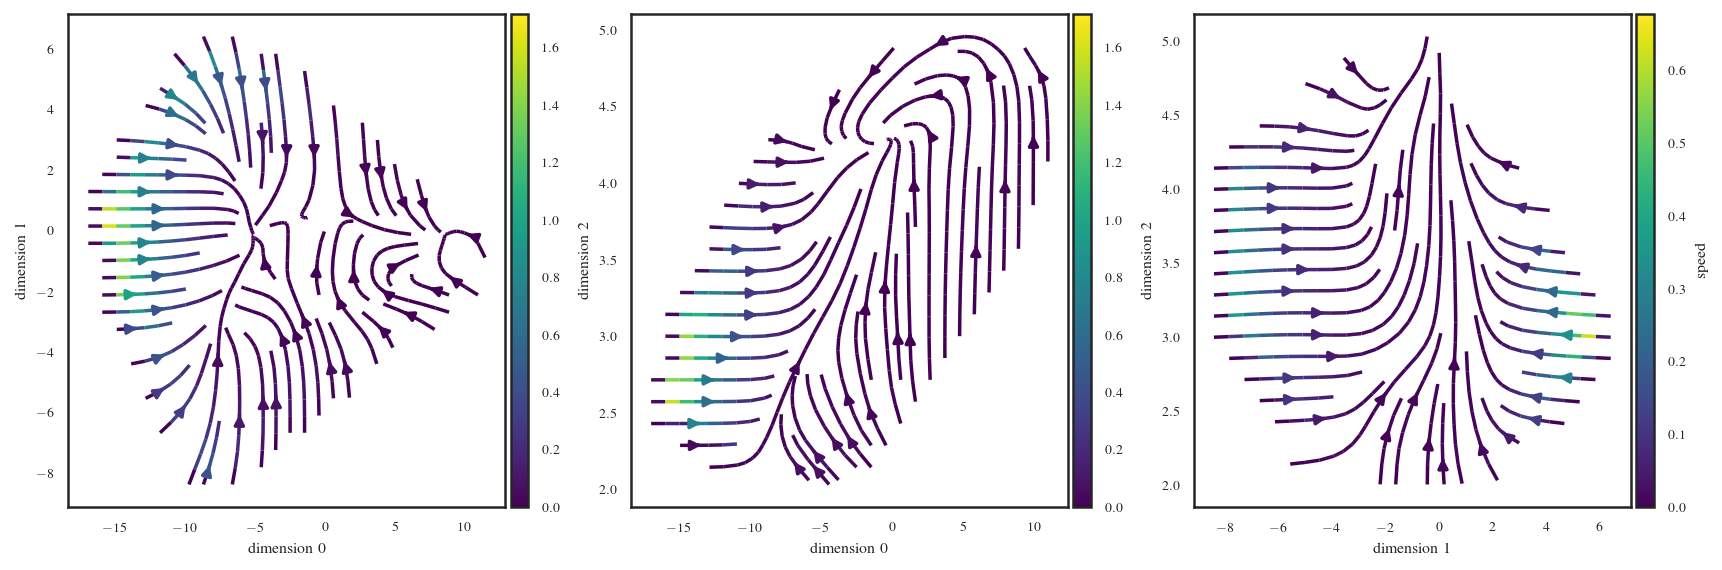

In [126]:
skpm.plot_predictions_of_model_in_2D_all_pairs()

##### plot train and test scores and compare them with those of a dummy model

Do a grid search over dummy models with the same cross validation splitter (with 10 splits):

In [127]:
dummy_search_10splits = GridSearchCV(
    estimator=MultiOutputRegressor(DummyRegressor()),
    param_grid=[
        {'estimator__strategy': ['mean', 'median']},
        {'estimator__strategy': ['quantile'], 'estimator__quantile': np.linspace(.1, .9, 12)}
    ],
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=mtss_10,
    verbose=1).fit(pm.X, pm.y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.6s finished


The GAM-based model has consistently lower training error and lower test error for the earlier data only:

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users

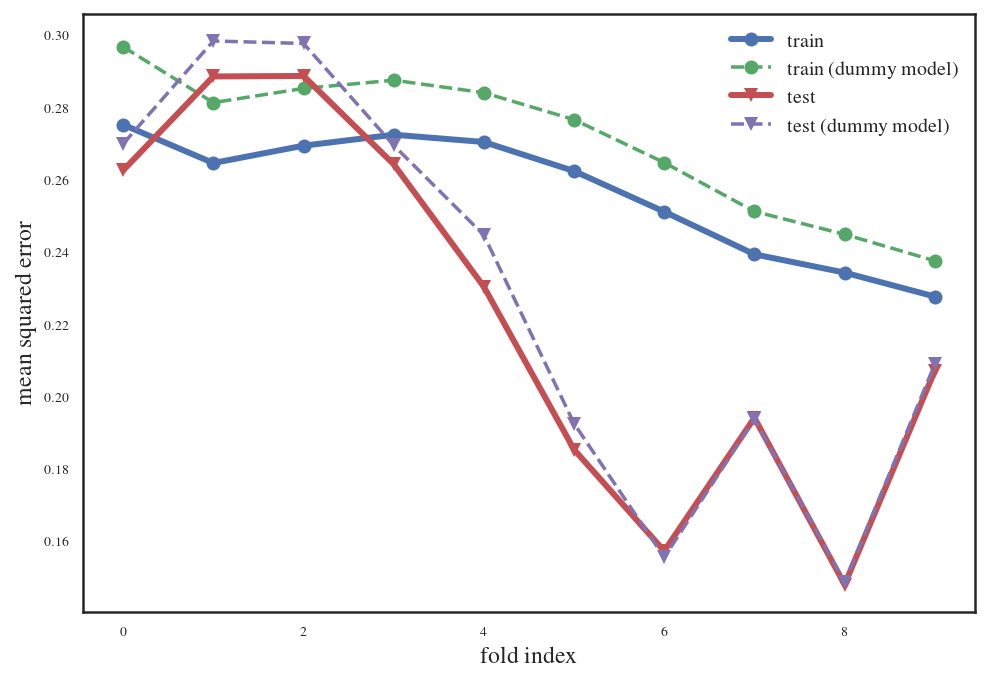

In [128]:
train_scores_10splits = rs_cv_results_df.query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_train_score').sort_index().values
test_scores_10splits = rs_cv_results_df.query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_test_score').sort_index().values
train_scores_dummy_10splits = (
    pd.DataFrame(dummy_search_10splits.cv_results_)
    .query('rank_test_score == 1').iloc[0]
    .filter(regex=r'split[0-9]_train_score').sort_index().values)
test_scores_dummy_10splits = (
    pd.DataFrame(dummy_search_10splits.cv_results_)
    .query('rank_test_score == 1').iloc[0]
    .filter(regex=r'split[0-9]_test_score').sort_index().values)

plt.plot(range(10), -train_scores_10splits, label='train', marker='o', lw=3)
plt.plot(range(10), -train_scores_dummy_10splits, label='train (dummy model)', marker='o', ls='--')
plt.plot(range(10), -test_scores_10splits, label='test', marker='v', lw=3)
plt.plot(range(10), -test_scores_dummy_10splits, label='test (dummy model)', marker='v', ls='--')
plt.ylabel('mean squared error', fontsize=12)
plt.xlabel('fold index', fontsize=12)
plt.legend()
plt.show()

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecati

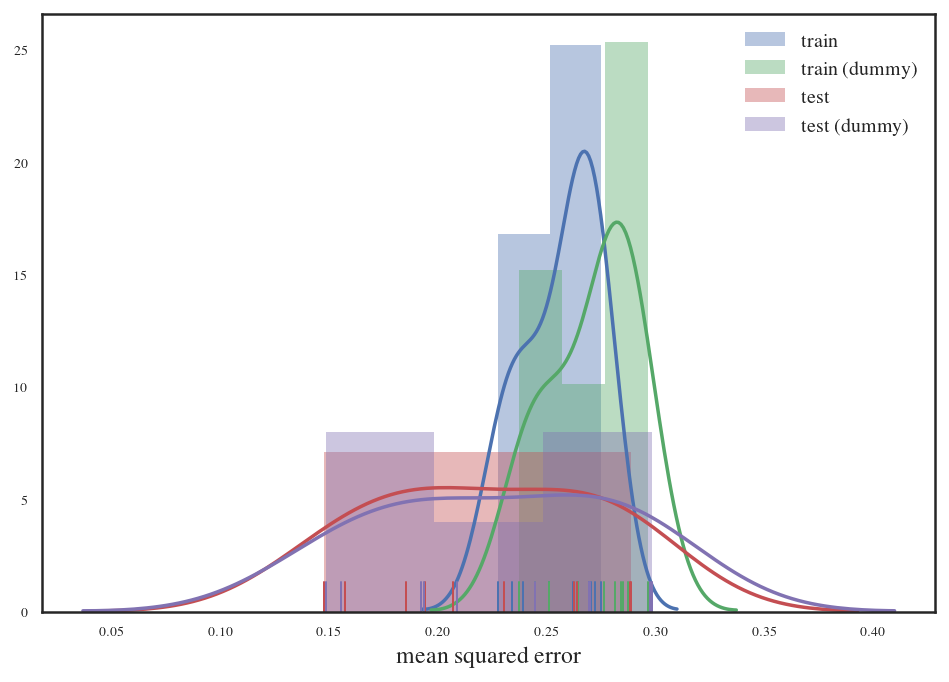

In [129]:
sns.distplot(
    rs_cv_results_df.query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_train_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='train')

sns.distplot(
    pd.DataFrame(dummy_search_10splits.cv_results_).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_train_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='train (dummy)')

sns.distplot(
    rs_cv_results_df.query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_test_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='test')

sns.distplot(
    pd.DataFrame(dummy_search_10splits.cv_results_).query('rank_test_score == 1').iloc[0].filter(regex=r'split[0-9]_test_score') * -1,
    rug=True, norm_hist=True, axlabel='mean squared error', label='test (dummy)')

plt.xlabel('mean squared error', fontsize=12)
plt.legend()
plt.show()

#### stream plots at different GDPpc

In [130]:
stream_kws = dict(linewidth=1.5, density=0.75)

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if mpl.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
percent_formatter = FuncFormatter(to_percent)


gdp_quantiles = gdp_per_capita_nonmissing.loc[(slice(None), '1988')].quantile(
    [.1, .5, .9])

eps = 0.15

pms = [skpm]
fig, axes = plt.subplots(
    len(pms), len(gdp_quantiles), figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH * .6),
    sharex='row', sharey='row')

for i, (pm) in enumerate(pms):
    gam = pm.best_model.estimators_[2]
    X_grid = generate_X_grid(gam, n=200)
    partial_dependence, confidence_interval = gam.partial_dependence(X_grid, width=.95)
    X_grid_extra_point = np.vstack((X_grid, X_grid[-1] + np.diff(X_grid, axis=0)[-1]))
    y_spacing = 2
    x = X_grid_extra_point[:, 0]
    y = X_grid_extra_point[::y_spacing, 1]
    # C.shape should be (len(y), len(x)) (or 1 less than both of those)
    C = partial_dependence[:, 0].reshape(1, -1) + partial_dependence[::y_spacing, 1].reshape(-1, 1)

    X, Y = np.meshgrid(x, y, indexing='xy')

    UVWs = []
    speed_min, speed_max = np.inf, -1 * np.inf
    for j, (quantile, gdppc) in enumerate(gdp_quantiles.iteritems()):
        C_mask = np.empty(C.shape, dtype=bool)
        convex_hull = ConvexHull(
            pm.X[(np.log10(gdppc) * (1 - eps) <= pm.X.iloc[:, 2]) & (pm.X.iloc[:, 2] <= np.log10(gdppc) * (1 + eps))].iloc[:, :2])
        for y_index, y_value in enumerate(y[:-1]):
            for x_index, x_value in enumerate(x[:-1]):
                C_mask[y_index, x_index] = not vis_model.point_in_hull(
                    np.array([x_value, y_value]), convex_hull)

        gam_0 = pm.best_model.estimators_[0]
        gam_1 = pm.best_model.estimators_[1]
        gam_2 = pm.best_model.estimators_[2]
        
        gdppc_array = np.zeros(X[:-1, :-1].shape, dtype=float) + np.log10(gdppc)

        where_to_predict = np.hstack((
            X[:-1, :-1].reshape(-1, 1),
            Y[:-1, :-1].reshape(-1, 1),
            gdppc_array.reshape(-1, 1)))
        U = gam_0.predict(where_to_predict).reshape(X[:-1, :-1].shape)
        V = gam_1.predict(where_to_predict).reshape(X[:-1, :-1].shape)
        W = gam_2.predict(where_to_predict).reshape(X[:-1, :-1].shape)
        U = np.ma.masked_array(data=U, mask=C_mask)
        V = np.ma.masked_array(data=V, mask=C_mask)
        W = np.ma.masked_array(data=W, mask=C_mask)
        
        UVWs.append((U, V, W))
        
        speed_values = W
        speed_min = np.min([speed_min, np.min(speed_values)])
        speed_max = np.max([speed_max, np.max(speed_values)])
        print('gdppc', gdppc, '   speed_min', speed_min, '    speed_max', speed_max)
    
    norm = mpl.colors.Normalize(vmin=speed_min, vmax=speed_max)

    for j, ((quantile, gdppc), (U, V, W)) in enumerate(zip(gdp_quantiles.iteritems(), UVWs)):
        ax = axes[j]
        strm = ax.streamplot(
            x[:-1], y[:-1], U, V,
            color=W, cmap=mpl.cm.plasma, norm=norm, **stream_kws)
        divider = make_axes_locatable(ax)
        if j == len(gdp_quantiles) - 1:
            cax = divider.append_axes('right', size='4%', pad=0.04)
            cbar = fig.colorbar(mappable=strm.lines, cax=cax,
                                orientation='vertical')
            
            # Set the percent formatter
#            cax.yaxis.set_major_formatter(percent_formatter)
            cax.set_yticklabels(['{:3.1f}'.format((10**change_in_log10_gdppc - 1)) + r'\%' for change_in_log10_gdppc in cax.get_yticks()])

        if i == 0:
            ax.set_title(
                '{}th percentile (\${:0.0f})'.format(int(quantile * 100), gdppc),
                bbox=BBOX_LABELS,
                x=.5)
fig.text(s='annual growth rate of GDP per capita', x=.95, y=.9, rotation=270, fontsize=plt.rcParams['axes.labelsize'])
fig.text(s=r'score on the 1st principal component $\equiv {score_pc0}'.format(**VARIABLE_NOTATION),
         x=.5, y=-.01, ha='center', va='center')
fig.text(s=r'score on the 2nd princ. comp. $\equiv {score_pc1}'.format(**VARIABLE_NOTATION),
         x=.07, y=.5, ha='center', va='center', rotation=90)

fig.subplots_adjust(wspace=.03)
# fig.savefig(os.path.join(
#     path_manuscript_figures,
#     'streamplots_vary_GDPpc.pdf'), bbox_inches='tight')

gdppc 511.943417868    speed_min -0.0410252020504     speed_max 0.106213148403
gdppc 2764.41729517    speed_min -0.0488072486237     speed_max 0.153370253587
gdppc 30576.941153    speed_min -0.0752278206294     speed_max 0.153370253587


RuntimeError: LaTeX was not able to process the following string:
b'score on the 1st principal component $\\\\equiv \\\\phi_0'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./301fb628d1a4f9b875e0247fb7454349.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 301fb628d1a4f9b875e0247fb7454349.aux.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/ot1ptm.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/ot1ztmcm.fd)
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/omlztmcm.fd)
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/omsztmcm.fd)
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/omxztmcm.fd)
! Extra }, or forgotten $.
l.12 ...he 1st principal component $\equiv \phi_0}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./301fb628d1a4f9b875e0247fb7454349.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 301fb628d1a4f9b875e0247fb7454349.dvi (1 page, 440 bytes).
Transcript written on 301fb628d1a4f9b875e0247fb7454349.log.


#### hill climbing plot

/Users/charliebrummitt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in sqrt


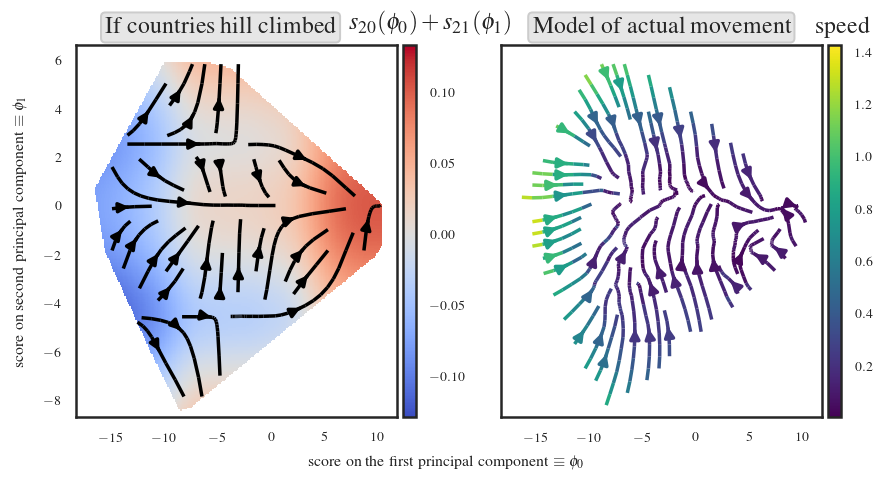

In [131]:
fig, axes = plt.subplots(
    1, 2, figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH ),
    sharex='row', sharey='row')


gam = skpm.best_model.estimators_[2]
X_grid = generate_X_grid(gam, n=250)
partial_dependence, confidence_interval = gam.partial_dependence(X_grid, width=.95)

X_grid_extra_point = np.vstack((X_grid, X_grid[-1] + np.diff(X_grid, axis=0)[-1]))

y_spacing = 1
x = X_grid_extra_point[:, 0]
y = X_grid_extra_point[::y_spacing, 1]
# C.shape should be (len(y), len(x)) (or 1 less than both of those)
C = partial_dependence[:, 0].reshape(1, -1) + partial_dependence[::y_spacing, 1].reshape(-1, 1)

C_mask = np.empty(C.shape, dtype=bool)
convex_hull = ConvexHull(skpm.X.iloc[:, :2])
for y_index, y_value in enumerate(y[:-1]):
    for x_index, x_value in enumerate(x[:-1]):
        C_mask[y_index, x_index] = not vis_model.point_in_hull(
            np.array([x_value, y_value]), convex_hull)
X, Y = np.meshgrid(x, y, indexing='xy')
pcolor_output = axes[0].pcolor(
    X, Y,
    np.ma.masked_array(data=C, mask=C_mask),
    cmap=shifted_color_map(plt.get_cmap('coolwarm'), data=C),
    vmin=np.min(C), vmax=np.max(C),
    linewidth=0, rasterized=True)
pcolor_output.set_edgecolor('face')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='4%', pad=0.04)
cbar_label = (
    'change in $\log_{10}$(GDPpc) predicted by PC0 and PC1'
    #', i.e., $f_{20}(PC_0) + f_{21}(PC_1)$'
)
cbar = fig.colorbar(mappable=pcolor_output, cax=cax,
                    orientation='vertical', label='')
if i == 0:
    cbar.ax.set_title(
        r'${smooth_term}_{{20}}({score_pc0}) + {smooth_term}_{{21}}({score_pc1})$'.format(
            **VARIABLE_NOTATION), x=2.2)
#axes[i, 0].colorbar(label='change in $\log_{10}$(GDPpc) predicted by PC0 and PC1, i.e., $f_{20}(PC_0) + f_{21}(PC_1)$')

#     CS = axes[i, 0].contour(X[:-1, :-1], Y[:-1, :-1], np.ma.masked_array(data=C, mask=C_mask))
#     axes[i, 0].clabel(CS, inline=1, fontsize=10)

x_deriv = np.gradient(partial_dependence[:, 0])
y_deriv = np.gradient(partial_dependence[::y_spacing, 1])
U, V = np.meshgrid(x_deriv, y_deriv)

axes[0].streamplot(
    X[:-1, :-1], Y[:-1, :-1],
    np.ma.masked_array(data=U, mask=C_mask),
    np.ma.masked_array(data=V, mask=C_mask),
    density=.6,
    color='k')

# Streamplot like vis.gam
gdppc_of_closest_datum = np.empty(X[:-1, :-1].shape)

for y_index, y_value in enumerate(y[:-1]):
    for x_index, x_value in enumerate(x[:-1]):
        index_closest_sample = np.argmin(
            np.sum((skpm.X.values[:, :2] - np.array([x_value, y_value]))**2, axis=1))
        gdppc_of_closest_datum[y_index, x_index] = skpm.X.values[index_closest_sample, 2]

gam_0 = skpm.best_model.estimators_[0]
gam_1 = skpm.best_model.estimators_[1]

where_to_predict = np.hstack((
    X[:-1, :-1].reshape(-1, 1),
    Y[:-1, :-1].reshape(-1, 1),
    #np.zeros(Y[:-1, :-1].reshape(-1, 1).shape) + 5.0))
    gdppc_of_closest_datum.reshape(-1, 1)))
U = gam_0.predict(where_to_predict).reshape(gdppc_of_closest_datum.shape)
V = gam_1.predict(where_to_predict).reshape(gdppc_of_closest_datum.shape)
U = np.ma.masked_array(data=U, mask=C_mask)
V = np.ma.masked_array(data=V, mask=C_mask)

ax = axes[1]
strm = ax.streamplot(
    x[:-1], y[:-1], U, V,
    color=np.sqrt(U**2 + V**2), cmap=mpl.cm.viridis)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.04)
cbar = fig.colorbar(mappable=strm.lines, cax=cax,
                    orientation='vertical')
if i == 0:
    cbar.ax.set_title('speed', x=1.2)


axes[0].set_title(
    'If countries hill climbed',
    x=.45,
    bbox=BBOX_LABELS)
axes[1].set_title(
    'Model of actual movement',
#     x=.4,
    bbox=BBOX_LABELS)
fig.text(s=r'score on the first principal component $\equiv {score_pc0}'.format(**VARIABLE_NOTATION),
         x=.5, y=.03, ha='center', va='center')
fig.text(s=r'score on second principal component $\equiv {score_pc1}'.format(**VARIABLE_NOTATION),
         x=.07, y=.5, ha='center', va='center', rotation=90)

fig.subplots_adjust(wspace=.25, hspace=.14)
# fig.savefig(os.path.join(
#     path_manuscript_figures,
#     'hill_climb_GDPpc_and_model_of_actual_movement_3_normalizations_no_contour_lines_k.pdf'),
#     bbox_inches='tight', dpi=300)

#### iterated predictions

In [132]:
iterated_predictions_10fold = skpm.iterated_predictions(num_time_steps=51)

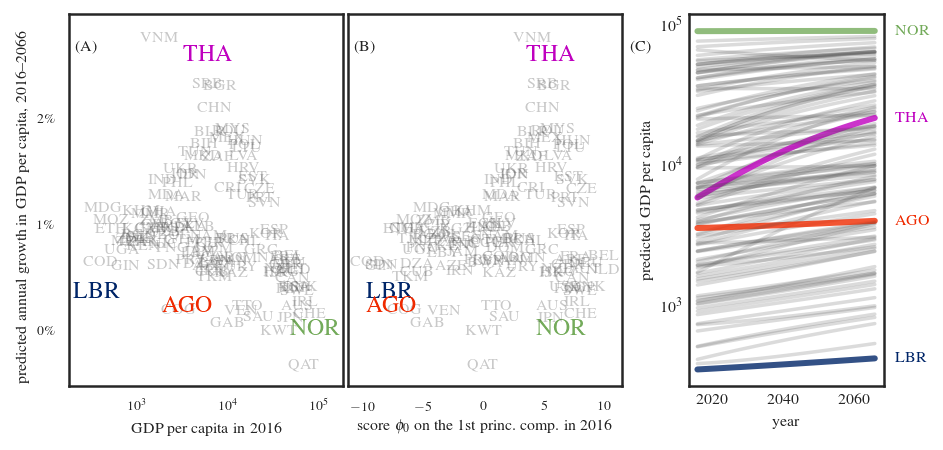

In [133]:
plt.figure(figsize=(TWO_COL_WIDTH * .86, ONE_COL_WIDTH))
gs1 = mpl.gridspec.GridSpec(1, 3)
gs1.update(left=0.02, right=1, wspace=0.02)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
gs2 = mpl.gridspec.GridSpec(1, 1)
gs2.update(left=0.75, right=0.98)
ax2 = plt.subplot(gs2[0])



end_year_index = 51
initial_year = rpop_df.index.get_level_values('year').max().year
highlight_certain_countries_growth = {
    'AGO': '#ef2a00',
#     'IND': '#ff9933',
    'THA': 'm',
    'LBR': (0., 0.14509804, 0.40784314),
    'NOR': (116 / 255., 171 / 255., 91 / 255.)#(0.5019607843137255, 0.6941176470588235, 0.8274509803921568)
}

#countries_to_highlight = ['LBR', 'NOR', 'IND', 'AGO']
it_pred_highlight = {c: iterated_predictions_10fold[c] for c in highlight_certain_countries_growth}
it_pred_gray = {c: iterated_predictions_10fold[c] for c in iterated_predictions_10fold if c not in highlight_certain_countries_growth}


for c in iterated_predictions_10fold:
    is_highlighted = c in highlight_certain_countries_growth
    color = highlight_certain_countries_growth[c] if is_highlighted else '.3'
    initial_gdppc = iterated_predictions_10fold[c][0, -1]
    final_gdppc = iterated_predictions_10fold[c][-1, -1]
    change = final_gdppc - initial_gdppc
    growth_rate = 100 * (-1 + 10**(change / len(iterated_predictions_10fold[c] - 1)))
    ax0.scatter(
        [10**initial_gdppc], [growth_rate],
        color=color, alpha=0.0)
    if not is_highlighted:
        ax0.text(s=c, x=10**initial_gdppc, y=growth_rate, color=color, ha='center', va='center', size=8, alpha=.3)
    else:
        ax0.text(s=c, x=10**initial_gdppc, y=growth_rate, color=color,
                ha='center', va='center', size=12, weight='bold')

    initial_score_pc0 = iterated_predictions_10fold[c][0, 0]
    ax1.scatter([initial_score_pc0], [growth_rate], color=color, alpha=0)
    if not is_highlighted:
        ax1.text(s=c, x=initial_score_pc0, y=growth_rate, color=color, ha='center', va='center', size=8, alpha=.3)
    else:
        ax1.text(s=c, x=initial_score_pc0, y=growth_rate, color=color,
                ha='center', va='center', size=12, weight='bold')
        
    gdppc_values = 10**iterated_predictions_10fold[c][:end_year_index, 2]
    years = np.arange(initial_year, initial_year + end_year_index)
    if is_highlighted:
        ax2.plot(years, gdppc_values, color=color, alpha=.8, lw=3)
        ax2.annotate(s=c, xy=(years[-1], gdppc_values[-1]), xycoords='data',
                     xytext=(10, 0), textcoords='offset points', color=color, va='center')
    else:
        ax2.plot(years, gdppc_values, color=color, alpha=.2)

ax1.get_yaxis().set_visible(False)
for i, axis in enumerate([ax0, ax1]):
    if i == 0:
        axis.set_xscale('log')
        axis.set_xlim(180, 180000)
    axis.yaxis.set_major_formatter(FuncFormatter(format_percent_tick_label))
    axis.yaxis.set_major_locator(MaxNLocator(integer=True))

ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=8, pad=3)
ax2.set_xlabel('year')
ax2.set_ylabel('predicted GDP per capita'
#               + ' (constant 2010 USD / person / year)'
)

ax0.set_ylabel(r'predicted annual growth in GDP per capita, {}--{}'.format(
    initial_year, initial_year + end_year_index - 1), y=.48)
ax0.set_xlabel(r'GDP per capita' #+ ' (constant 2010 USD person$^{-1}$ year$^{-1}$)
                 + ' in ' + str(initial_year))#, x=-.1)
ax1.set_xlabel(r'score ${score_pc0}$ on the 1st princ.\ comp.\ in '.format(**VARIABLE_NOTATION) + str(initial_year))#, x=-.1)
ax0.annotate(s='(A)', xy=(.02, .90), xycoords='axes fraction')
ax1.annotate(s='(B)', xy=(.02, .90), xycoords='axes fraction')
ax2.annotate(s='(C)', xy=(-.3, .90), xycoords='axes fraction')

path = os.path.join(path_manuscript_figures,
                    'predicted_annual_growth_rates_highlight_GDPpc_and_pc0.pdf')

#plt.gcf().savefig(path, bbox_inches='tight', dpi=300)

## Illustrate the steps (Figure 1)

##### Version that is shorter in height:

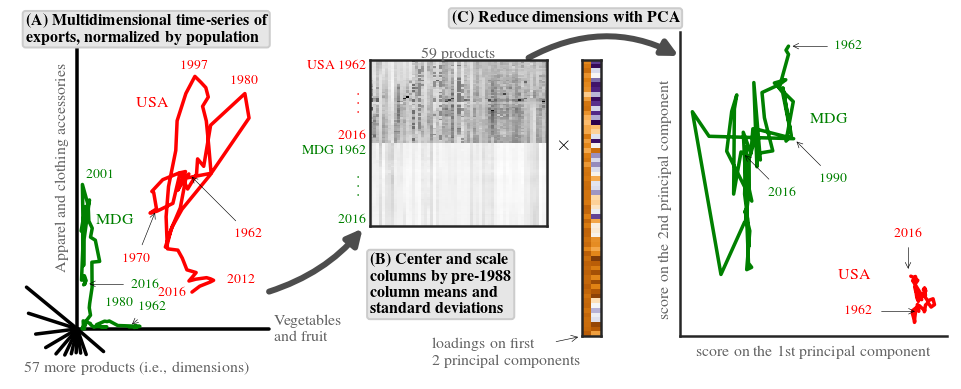

In [159]:
highlight_countries = {
    'USA': 'r',
    'MDG': 'g',
}

year_font_size = plt.rcParams['xtick.labelsize']

fig = plt.figure(figsize=(TWO_COL_WIDTH * .9, ONE_COL_WIDTH * .7))

plot_label_kws = dict(color='.4')
boxed_kws = dict(color='k', weight='bold',)

many_dim_rect = (
    0.0, # left
    0.0, # bottom
    0.3, # width
    1.0, # height
)

two_dim_rect = (
    1 - 0.25, # left
    0.1, # bottom
    0.3, # width
    .88, # height
)

countries = ['USA', 'MDG']
products = ['05', '84']

max_value = rpop_df.loc[countries, products].max().max()


ax_many = fig.add_axes(many_dim_rect, frameon=False)
ax_many.plot([0, 1], [0, 0], color='k')#color=product_code_to_1digit_color[products[0]])
ax_many.plot([0, 0], [0, .97], color='k')#color=product_code_to_1digit_color[products[1]])


angle = -.45
angle_delta = np.pi * 1.03 / (len(rpop_df.columns) - 2)
for i, product_code in enumerate(rpop_df.columns):
    angle -= angle_delta
    if (product_code not in products) and (i % 5 == 0):
        radius = .23 + np.sin(angle) * .15
        ax_many.plot([0, np.cos(angle) * radius], [0, np.sin(angle) * radius],
                     color='k')
                     #color=product_code_to_1digit_color[product_code])


x_normalizer = (rpop_df.loc[countries, products[0]].max() + .1)
y_normalizer = (rpop_df.loc[countries, products[1]].max() + .1)

for c in countries:
    ax_many.plot(
        rpop_df.loc[c, products[0]] / x_normalizer,
        rpop_df.loc[c, products[1]] / y_normalizer,
        color=highlight_countries[c])
#     for y in ['1962', '1989', '2016']:
#         ax_many.annotate(xy=rpop_df.loc[(c, y), products].values[0], s='{}{}'.format(c, y), ha='center', va='center', color=highlight_countries[c])
  
ax_many.annotate(s='USA', xy=rpop_df.loc[('USA', '2000'), products].values[0] / np.array([x_normalizer, y_normalizer]),
                 color=highlight_countries['USA'], xytext=(-20, 22), textcoords='offset points')
for y, xytext in [('1962', (30, -30)), ('1970', (-10, -25)), ('1980', (0, 6)), ('2012', (15, 0)), ('1997', (0, 5)), ('2016', (-10, 0))]:
    ax_many.annotate(
        xy=rpop_df.loc[('USA', y), products].values[0] / np.array([x_normalizer, y_normalizer]),
        color=highlight_countries['USA'], 
        s=y, ha='center', va='center', fontsize=year_font_size,
        xytext=xytext,
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '1970', '1990'] else None,
    )

ax_many.annotate(s='MDG', xy=rpop_df.loc[('MDG', '1980'), products].values[0] / np.array([x_normalizer, y_normalizer]),
                 color=highlight_countries['MDG'], xytext=(3, 50), textcoords='offset points')
for y, xytext in [('1962', (12, 10)), ('1980', (15, 10)), ('2001', (9, 5)), ('2016', (30, 0))]:
    ax_many.annotate(
        xy=rpop_df.loc[('MDG', y), products].values[0] / np.array([x_normalizer, y_normalizer]),
        color=highlight_countries['MDG'], 
        s=y, ha='center', va='center', fontsize=year_font_size,
        xytext=xytext,
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '2016'] else None,
    )
    
ax_many.annotate(
    s='Vegetables\nand fruit',
#     s='Fish, crustaceans',
    xy=(1.03, 0), ha='left', va='center', **plot_label_kws)#color=product_code_to_1digit_color[products[0]])
ax_many.annotate(
#    s=product_code_to_name[products[1]],
    s='Apparel and clothing accessories',
    xy=(-.05, .9), ha='right', va='top', rotation=90, **plot_label_kws)#color=product_code_to_1digit_color[products[1]])
ax_many.annotate(
    s='{} more products (i.e., dimensions)'.format(rpop_df_logged_scaled.shape[1] - 2),
    xy=(-.28, -.13), ha='left', va='center', **plot_label_kws)

ax_2 = fig.add_axes(two_dim_rect, frameon=True)
# ax_2.plot([0, 1], [0, 0], color='k')
# ax_2.plot([0, 0], [0, 1], color='k')
for country in countries:
    ax_2.plot(
        pm.X.loc[(country, slice(None)), (1, 'component_0')],
        pm.X.loc[(country, slice(None)), (1, 'component_1')],
        color=highlight_countries[country])
sns.despine(ax=ax_2, trim=False,)


ax_ts = fig.add_axes((.40, .36, .2, .6))  # l,b,w,h
ax_ts.matshow(rpop_df_logged_scaled.loc[(countries, slice(None)), slice(None)], aspect=.5, cmap=mpl.cm.Greys_r)
ax_ts.annotate(s='{} products'.format(rpop_df_logged_scaled.shape[1]), xy=(0.5, 1), xycoords='axes fraction', ha='center', va='bottom', **plot_label_kws)
ax_ts.annotate(s='USA 1962', xy=(-.02, 1), xycoords='axes fraction', ha='right', va='top', fontsize=year_font_size, color=highlight_countries['USA'])
ax_ts.annotate(s='. . .', xy=(-.04, .75), rotation=90, xycoords='axes fraction', ha='right', va='center', fontsize=8, color=highlight_countries['USA'])
ax_ts.annotate(s='2016', xy=(-.02, .51), xycoords='axes fraction', ha='right', va='bottom', fontsize=year_font_size, color=highlight_countries['USA'])
ax_ts.annotate(s='MDG 1962', xy=(-.02, .49), xycoords='axes fraction', ha='right', va='top', fontsize=year_font_size, color=highlight_countries['MDG'])
ax_ts.annotate(s='. . .', xy=(-.04, .25), rotation=90, xycoords='axes fraction', ha='right', va='center', fontsize=8, color=highlight_countries['MDG'])
ax_ts.annotate(s='2016', xy=(-.02, 0.0), xycoords='axes fraction', ha='right', va='bottom', fontsize=year_font_size, color=highlight_countries['MDG'])
ax_ts.annotate(s=r'$\times$', xy=(1.06, 0.5), xycoords='axes fraction', ha='left', va='center', fontsize=10, color='k')

ax_many.annotate(r'\textbf{(A)} ' + r'\textbf{Multidimensional time-series of}' + '\n' + r'\textbf{exports, normalized by population}',
                 xy=(-.27, .97), bbox=BBOX_LABELS, **boxed_kws)
#ax_ts.set_title('B. Center and scale columns, and\nreduce dimensions with PCA', y=1.2, bbox=BBOX_LABELS)

big_arrow_kws = dict(lw=3, color="0.3", patchB=None, shrinkB=0, arrowstyle="<|-, head_width=.4, head_length=.8")
ax_many.annotate("",
            xy=(.28, .25), xycoords='figure fraction',
            xytext=(.38, .42), textcoords='figure fraction',
            arrowprops=dict(**big_arrow_kws, connectionstyle="arc3,rad=-0.15"))
ax_many.annotate(
    s=r'\textbf{(B)} \textbf{Center and scale}' + '\n' + r'\textbf{columns by pre-1988}' + '\n' + r'\textbf{column means and}' + '\n' + r'\textbf{standard deviations}',
    bbox=BBOX_LABELS,
    xy=(.385, .35), ha='left', va='top', xycoords='figure fraction', **boxed_kws)

ax_2.annotate("",
            xy=(.55, .85), xycoords='figure fraction',
            xytext=(.71, .85), textcoords='figure fraction',
            arrowprops=dict(**big_arrow_kws, connectionstyle="arc3,rad=0.27"))
ax_2.annotate(
    s=r'\textbf{(C)} ' + r'\textbf{Reduce dimensions with PCA}',
    bbox=BBOX_LABELS,
    xy=(.47, .97), ha='left', va='top', xycoords='figure fraction', **boxed_kws)

ax_2.annotate(
    s='USA', color=highlight_countries['USA'],
    xy=pm.df_dim_reduced.loc[('USA', '2016'), ('component_0', 'component_1')].values[0],
    xytext=(-35, -3), textcoords='offset points')
ax_2.annotate(
    s='MDG', color=highlight_countries['MDG'],
    xy=pm.df_dim_reduced.loc[('MDG', '1990'), ('component_0', 'component_1')].values[0],
    xytext=(8, 8), textcoords='offset points')

for y, xytext in [('2016', (0, 20)), ('1962', (-30, 0))]:
    ax_2.annotate(
            xy=pm.df_dim_reduced.loc[('USA', y), ('component_0', 'component_1')].values[0],
            color=highlight_countries['USA'], 
            s=y, ha='center', va='center', fontsize=year_font_size,
            xytext=xytext,
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '2016'] else None,
        )
    
for y, xytext in [('2016', (20, -20)), ('1990', (20, -20)), ('1962', (30, 0))]:
    ax_2.annotate(
            xy=pm.df_dim_reduced.loc[('MDG', y), ('component_0', 'component_1')].values[0],
            color=highlight_countries['MDG'], 
            s=y, ha='center', va='center', fontsize=year_font_size,
            xytext=xytext,
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '1990', '2016'] else None,
        )



ax_pca = fig.add_axes((.55, .1, .2, .8)) #l, b, w, h
ax_pca.matshow(pca_all.components_[:2].T, cmap=mpl.cm.PuOr_r, aspect=.5)
ax_pca.xaxis.set_ticklabels([])
ax_pca.yaxis.set_ticklabels([])

ax_pca.annotate(
    s='loadings on first\n2 principal components',
    xy=(0, 0), xycoords='axes fraction',
    xytext=(-8, -.1), textcoords='axes fraction',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=30,rad=20,angleB=50", shrinkA=25),
    **plot_label_kws
)


for ax in [ax_pca, ax_2, ax_many, ax_ts]:
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
#ax_2.plot(*pm.X.loc['USA'].iloc[:2].T)

ax_2.annotate(
    s='score on the 1st principal component', xycoords='axes fraction',
    xy=(.5, -.05), ha='center', va='center', **plot_label_kws)
ax_2.annotate(
    s='score on the 2nd principal component', xycoords='axes fraction',
    xy=(-.06, .45), ha='center', va='center', rotation=90, **plot_label_kws)

fig.savefig(os.path.join(path_manuscript_figures, 'overview.pdf'),
            pad_inches=0.1, bbox_inches='tight')

##### Version that is taller:

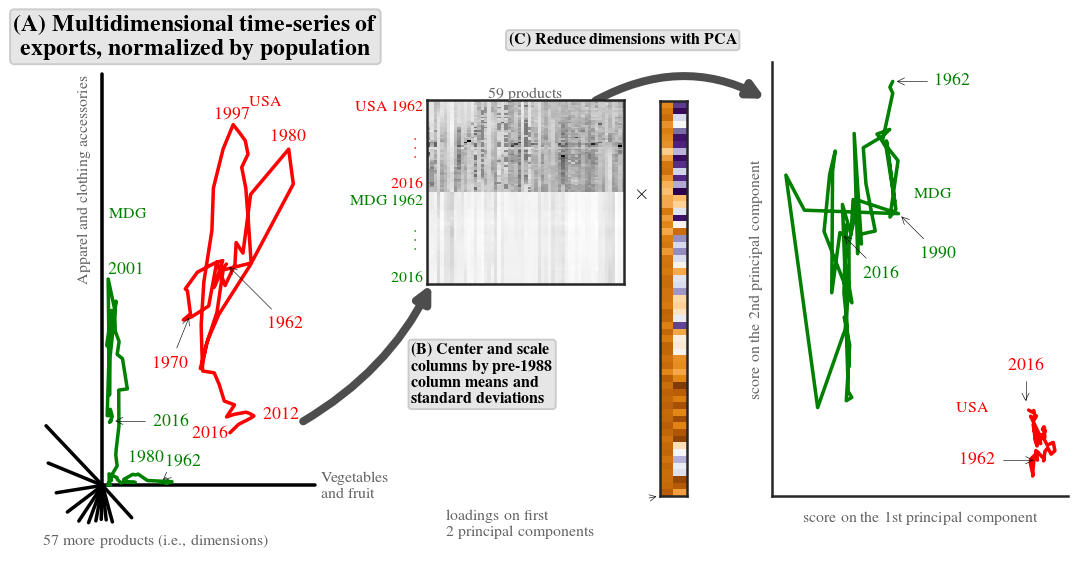

In [108]:
highlight_countries = {
    'USA': 'r',
    'MDG': 'g',
}

fig = plt.figure(figsize=(TWO_COL_WIDTH, ONE_COL_WIDTH))

plot_label_kws = dict(color='.4')
boxed_kws = dict(color='k', weight='bold',)

many_dim_rect = (
    0.0, # left
    0.0, # bottom
    0.3, # width
    1.0, # height
)

two_dim_rect = (
    1 - 0.25, # left
    0.1, # bottom
    0.3, # width
    .88, # height
)

countries = ['USA', 'MDG']
products = ['05', '84']

max_value = rpop_df.loc[countries, products].max().max()


ax_many = fig.add_axes(many_dim_rect, frameon=False)
ax_many.plot([0, 1], [0, 0], color='k')#color=product_code_to_1digit_color[products[0]])
ax_many.plot([0, 0], [0, .97], color='k')#color=product_code_to_1digit_color[products[1]])


angle = -.45
angle_delta = np.pi * 1.03 / (len(rpop_df.columns) - 2)
for i, product_code in enumerate(rpop_df.columns):
    angle -= angle_delta
    if (product_code not in products) and (i % 5 == 0):
        radius = .23 + np.sin(angle) * .15
        ax_many.plot([0, np.cos(angle) * radius], [0, np.sin(angle) * radius],
                     color='k')
                     #color=product_code_to_1digit_color[product_code])


x_normalizer = (rpop_df.loc[countries, products[0]].max() + .1)
y_normalizer = (rpop_df.loc[countries, products[1]].max() + .1)

for c in countries:
    ax_many.plot(
        rpop_df.loc[c, products[0]] / x_normalizer,
        rpop_df.loc[c, products[1]] / y_normalizer,
        color=highlight_countries[c])
#     for y in ['1962', '1989', '2016']:
#         ax_many.annotate(xy=rpop_df.loc[(c, y), products].values[0], s='{}{}'.format(c, y), ha='center', va='center', color=highlight_countries[c])
  
ax_many.annotate(s='USA', xy=rpop_df.loc[('USA', '1980'), products].values[0] / np.array([x_normalizer, y_normalizer]), color=highlight_countries['USA'], xytext=(-20, 22), textcoords='offset points')
for y, xytext in [('1962', (30, -30)), ('1970', (-10, -25)), ('1980', (0, 6)), ('2012', (15, 0)), ('1997', (0, 5)), ('2016', (-10, 0))]:
    ax_many.annotate(
        xy=rpop_df.loc[('USA', y), products].values[0] / np.array([x_normalizer, y_normalizer]),
        color=highlight_countries['USA'], 
        s=y, ha='center', va='center', fontsize=9,
        xytext=xytext,
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '1970', '1990'] else None,
    )

ax_many.annotate(s='MDG', xy=rpop_df.loc[('MDG', '1980'), products].values[0] / np.array([x_normalizer, y_normalizer]), color=highlight_countries['MDG'], xytext=(-4, 130), textcoords='offset points')
for y, xytext in [('1962', (12, 10)), ('1980', (15, 10)), ('2001', (9, 5)), ('2016', (30, 0))]:
    ax_many.annotate(
        xy=rpop_df.loc[('MDG', y), products].values[0] / np.array([x_normalizer, y_normalizer]),
        color=highlight_countries['MDG'], 
        s=y, ha='center', va='center', fontsize=9,
        xytext=xytext,
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '2016'] else None,
    )
    
ax_many.annotate(
    s='Vegetables\nand fruit',
#     s='Fish, crustaceans',
    xy=(1.03, 0), ha='left', va='center', **plot_label_kws)#color=product_code_to_1digit_color[products[0]])
ax_many.annotate(
#    s=product_code_to_name[products[1]],
    s='Apparel and clothing accessories',
    xy=(-.06, .97), ha='right', va='top', rotation=90, **plot_label_kws)#color=product_code_to_1digit_color[products[1]])
ax_many.annotate(
    s='{} more products (i.e., dimensions)'.format(rpop_df_logged_scaled.shape[1] - 2),
    xy=(-.28, -.13), ha='left', va='center', **plot_label_kws)

ax_2 = fig.add_axes(two_dim_rect, frameon=True)
# ax_2.plot([0, 1], [0, 0], color='k')
# ax_2.plot([0, 0], [0, 1], color='k')
for country in countries:
    ax_2.plot(
        pm.X.loc[(country, slice(None)), (1, 'component_0')],
        pm.X.loc[(country, slice(None)), (1, 'component_1')],
        color=highlight_countries[country])
sns.despine(ax=ax_2, trim=False,)




ax_ts = fig.add_axes((.40, .4, .2, .63))
ax_ts.matshow(rpop_df_logged_scaled.loc[(countries, slice(None)), slice(None)], aspect=.5, cmap=mpl.cm.Greys_r)
ax_ts.annotate(s='{} products'.format(rpop_df_logged_scaled.shape[1]), xy=(0.5, 1), xycoords='axes fraction', ha='center', va='bottom', **plot_label_kws)
ax_ts.annotate(s='USA 1962', xy=(-.02, 1), xycoords='axes fraction', ha='right', va='top', fontsize=8, color=highlight_countries['USA'])
ax_ts.annotate(s='. . .', xy=(-.04, .75), rotation=90, xycoords='axes fraction', ha='right', va='center', fontsize=8, color=highlight_countries['USA'])
ax_ts.annotate(s='2016', xy=(-.02, .51), xycoords='axes fraction', ha='right', va='bottom', fontsize=8, color=highlight_countries['USA'])
ax_ts.annotate(s='MDG 1962', xy=(-.02, .49), xycoords='axes fraction', ha='right', va='top', fontsize=8, color=highlight_countries['MDG'])
ax_ts.annotate(s='. . .', xy=(-.04, .25), rotation=90, xycoords='axes fraction', ha='right', va='center', fontsize=8, color=highlight_countries['MDG'])
ax_ts.annotate(s='2016', xy=(-.02, 0.0), xycoords='axes fraction', ha='right', va='bottom', fontsize=8, color=highlight_countries['MDG'])
ax_ts.annotate(s=r'$\times$', xy=(1.06, 0.5), xycoords='axes fraction', ha='left', va='center', fontsize=10, color='k')

ax_many.set_title(r'\textbf{(A)} ' + r'\textbf{Multidimensional time-series of}' + '\n' + r'\textbf{exports, normalized by population}',
                  x=.55, y=.97, bbox=BBOX_LABELS, **boxed_kws)
#ax_ts.set_title('B. Center and scale columns, and\nreduce dimensions with PCA', y=1.2, bbox=BBOX_LABELS)

big_arrow_kws = dict(lw=4, color="0.3", patchB=None, shrinkB=0, arrowstyle="<|-, head_width=.4, head_length=.8")
ax_many.annotate("",
            xy=(.28, .25), xycoords='figure fraction',
            xytext=(.4, .5), textcoords='figure fraction',
            arrowprops=dict(**big_arrow_kws, connectionstyle="arc3,rad=-0.15"))
ax_many.annotate(
    s=r'\textbf{(B)} \textbf{Center and scale}' + '\n' + r'\textbf{columns by pre-1988}' + '\n' + r'\textbf{column means and}' + '\n' + r'\textbf{standard deviations}',
    bbox=BBOX_LABELS,
    xy=(.38, .39), ha='left', va='top', xycoords='figure fraction', **boxed_kws)

ax_2.annotate("",
            xy=(.55, .82), xycoords='figure fraction',
            xytext=(.71, .82), textcoords='figure fraction',
            arrowprops=dict(**big_arrow_kws, connectionstyle="arc3,rad=0.27"))
ax_2.annotate(
    s=r'\textbf{(C)} ' + r'\textbf{Reduce dimensions with PCA}',
    bbox=BBOX_LABELS,
    xy=(.47, .94), ha='left', va='top', xycoords='figure fraction', **boxed_kws)

ax_2.annotate(
    s='USA', color=highlight_countries['USA'],
    xy=pm.df_dim_reduced.loc[('USA', '2016'), ('component_0', 'component_1')].values[0],
    xytext=(-35, -3), textcoords='offset points')
ax_2.annotate(
    s='MDG', color=highlight_countries['MDG'],
    xy=pm.df_dim_reduced.loc[('MDG', '1990'), ('component_0', 'component_1')].values[0],
    xytext=(8, 8), textcoords='offset points')

for y, xytext in [('2016', (0, 20)), ('1962', (-30, 0))]:
    ax_2.annotate(
            xy=pm.df_dim_reduced.loc[('USA', y), ('component_0', 'component_1')].values[0],
            color=highlight_countries['USA'], 
            s=y, ha='center', va='center', fontsize=9,
            xytext=xytext,
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '2016'] else None,
        )
    
for y, xytext in [('2016', (20, -20)), ('1990', (20, -20)), ('1962', (30, 0))]:
    ax_2.annotate(
            xy=pm.df_dim_reduced.loc[('MDG', y), ('component_0', 'component_1')].values[0],
            color=highlight_countries['MDG'], 
            s=y, ha='center', va='center', fontsize=9,
            xytext=xytext,
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc") if y in ['1962', '1990', '2016'] else None,
        )



ax_pca = fig.add_axes((.55, .1, .2, .8)) #l, b, w, h
ax_pca.matshow(pca_all.components_[:2].T, cmap=mpl.cm.PuOr_r, aspect=.5)
ax_pca.xaxis.set_ticklabels([])
ax_pca.yaxis.set_ticklabels([])

ax_pca.annotate(
    s='loadings on first\n2 principal components',
    xy=(0, 0), xycoords='axes fraction',
    xytext=(-8, -.1), textcoords='axes fraction',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc,angleA=30,rad=20,angleB=50", shrinkA=25),
    **plot_label_kws
)


for ax in [ax_pca, ax_2, ax_many, ax_ts]:
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
#ax_2.plot(*pm.X.loc['USA'].iloc[:2].T)

ax_2.annotate(
    s='score on the 1st principal component', xycoords='axes fraction',
    xy=(.5, -.05), ha='center', va='center', **plot_label_kws)
ax_2.annotate(
    s='score on the 2nd principal component', xycoords='axes fraction',
    xy=(-.06, .5), ha='center', va='center', rotation=90, **plot_label_kws)

fig.savefig(os.path.join(path_manuscript_figures, 'illustrate_dimension_reduction.pdf'), bbox_inches='tight', pad_inches=.3)

## Check whether the loadings in the first principal component are proportional to the standard deviations used to scale the columns

In [19]:
log_scaler = ScaledLogPositiveData(X_min_pos=None)
log_scaler.fit(rpop_df)
rpop_df_logged = log_scaler.fit_transform(rpop_df)

rpop_df_logged_scaled, scaler = scale_to_pre1988(rpop_df_logged, StandardScaler())

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [34]:
mod = smf.ols(formula='loadings ~ sigma', data=pd.DataFrame({'sigma': scaler.scale_, 'loadings': pca.components_[0]}))
res = mod.fit()

In [36]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               loadings   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                  0.001764
Date:                Sat, 25 Aug 2018   Prob (F-statistic):              0.967
Time:                        10:53:38   Log-Likelihood:                 128.49
No. Observations:                  59   AIC:                            -253.0
Df Residuals:                      57   BIC:                            -248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1277      0.012     10.661      0.000       0.104       0.152
sigma         -0.0017      0.040     -0.042      0.967      -0.081       0.077
==============================================================================
Omnibus:                       10.829   Durbin-Watson:                   0.851
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.800
Skew:                          -0.997   Prob(JB):                      0.00452
Kurtosis:                       3.645   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

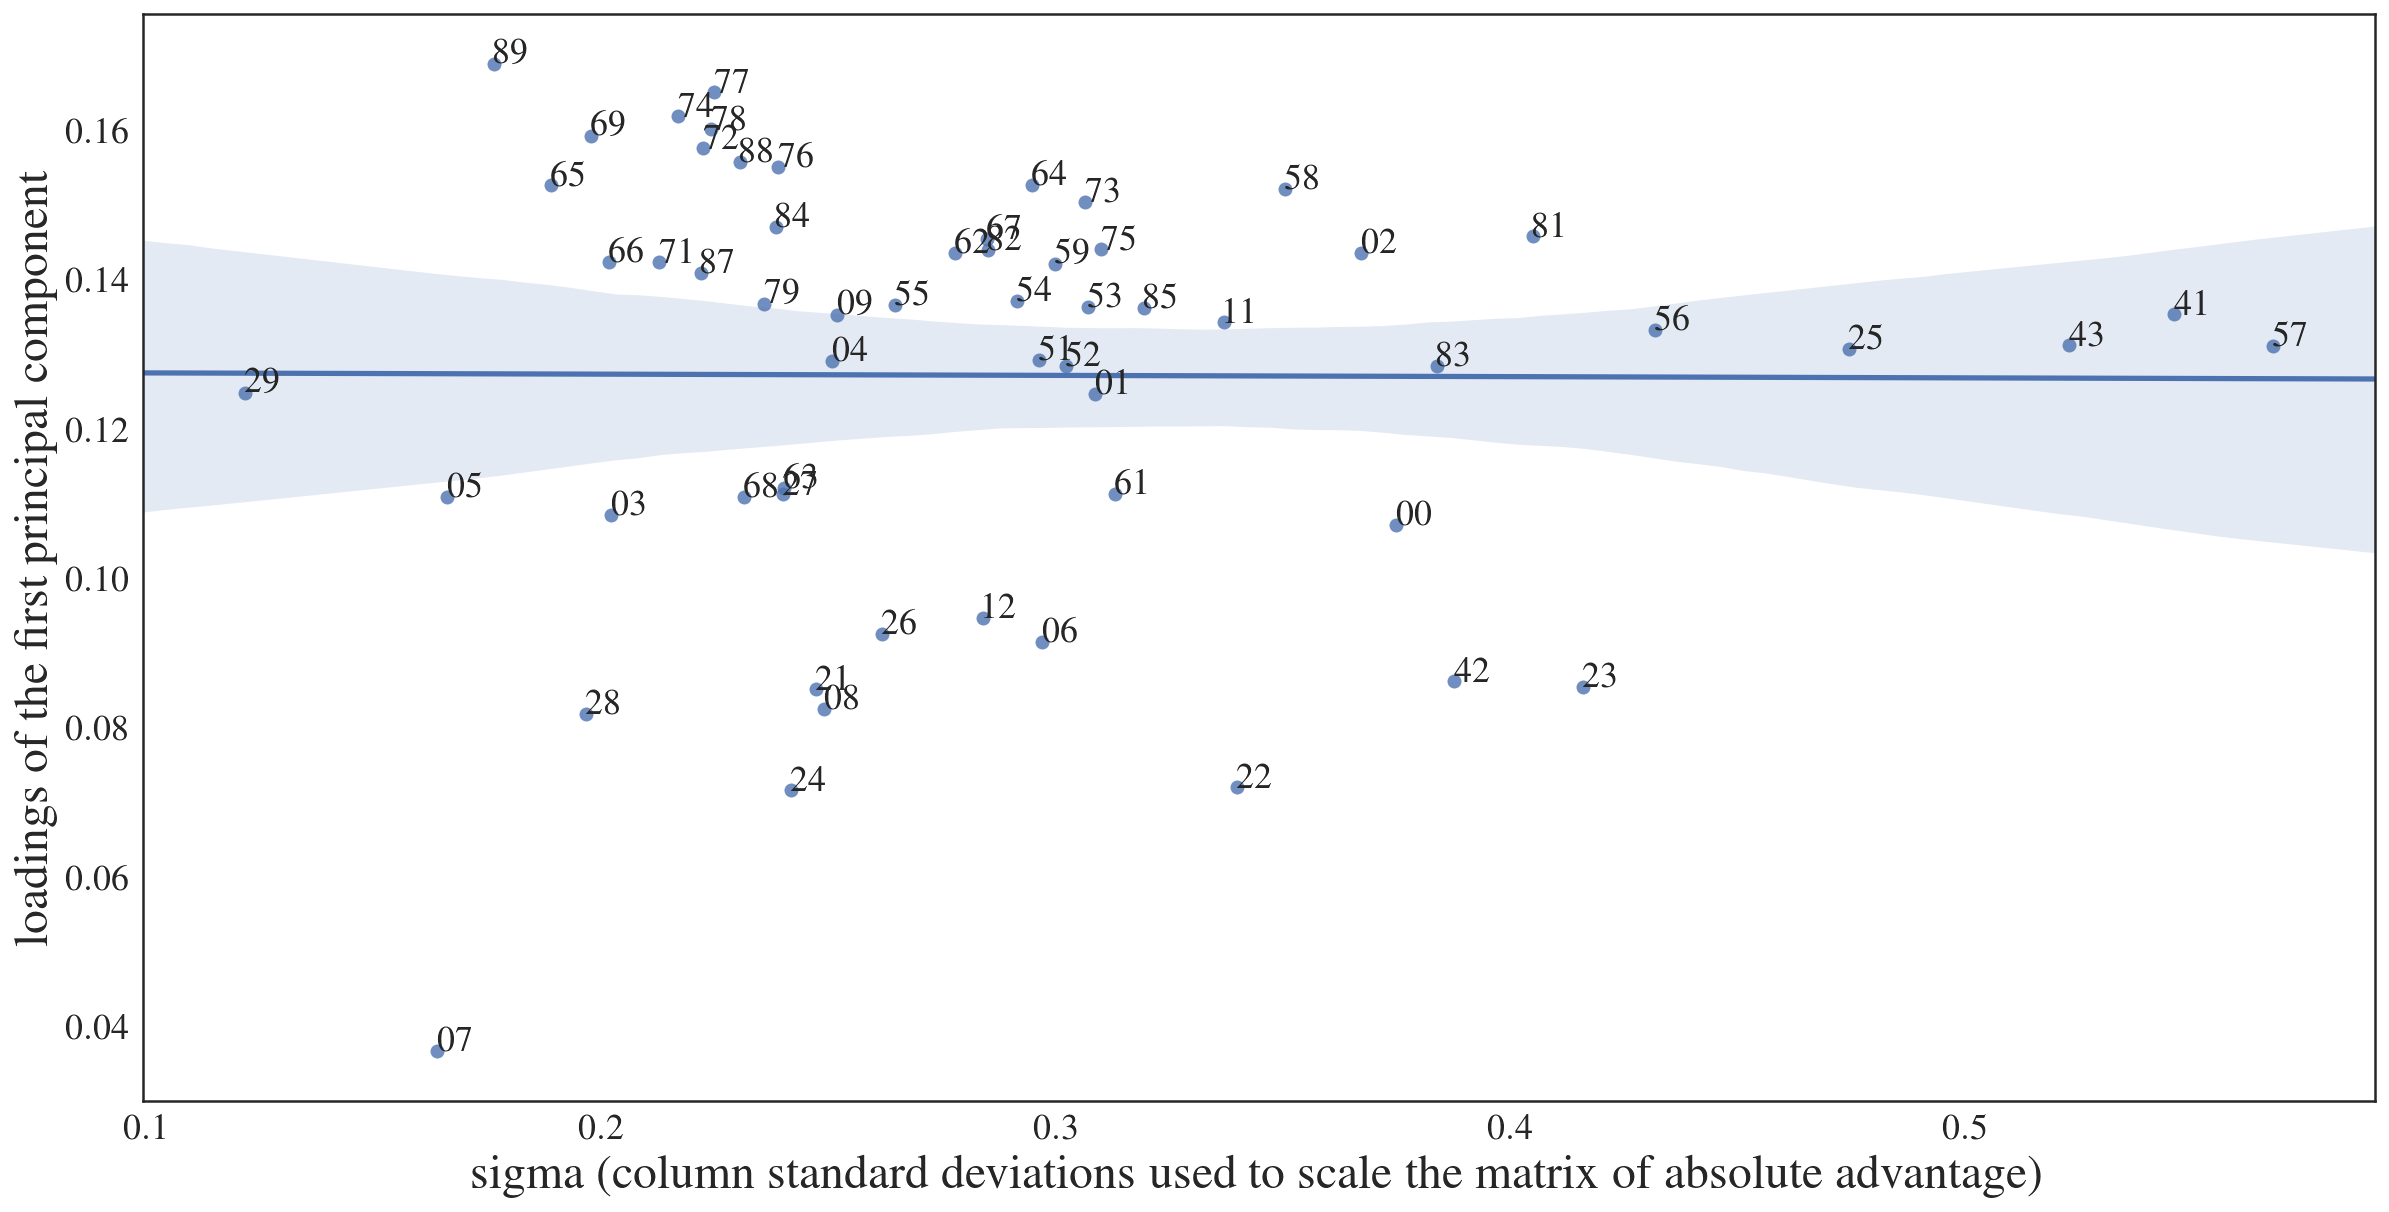

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.regplot(scaler.scale_, pca.components_[0], ax=ax)
for x, y, p in zip(scaler.scale_, pca.components_[0], rpop_df.columns):
    ax.annotate(s=p, xy=(x, y), fontsize=18)
ax.set_xlabel('sigma (column standard deviations used to scale the matrix of absolute advantage)', fontsize=24)
ax.set_ylabel('loadings of the first principal component', fontsize=24)
ax.tick_params(labelsize=18)

### Check whether phi_0 is proportional to the row means of the scaled data

In [102]:
row_means_phi_0 = pd.merge(
    rpop_df_logged_scaled.mean(1).to_frame().rename(columns={0: 'row_mean_of_scaled_data'}),
    pm.df_dim_reduced.loc[:, 'component_0'].to_frame(), left_index=True, right_index=True)

In [103]:
mod = smf.ols(formula='component_0 ~ row_mean_of_scaled_data', data=row_means_phi_0)
res = mod.fit()

In [104]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            component_0   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.679e+06
Date:                Sat, 25 Aug 2018   Prob (F-statistic):               0.00
Time:                        13:52:48   Log-Likelihood:                 84.164
No. Observations:                5446   AIC:                            -164.3
Df Residuals:                    5444   BIC:                            -151.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6827      0.003   -206.610      0.000      -0.689      -0.676
row_mean_of_scaled_data     7.7726      0.005   1636.850      0.000       7.763       7.782
==============================================================================
Omnibus:                      291.935   Durbin-Watson:                   0.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              528.529
Skew:                           0.411   Prob(JB):                    1.70e-115
Kurtosis:                       4.286   Cond. No.                         1.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

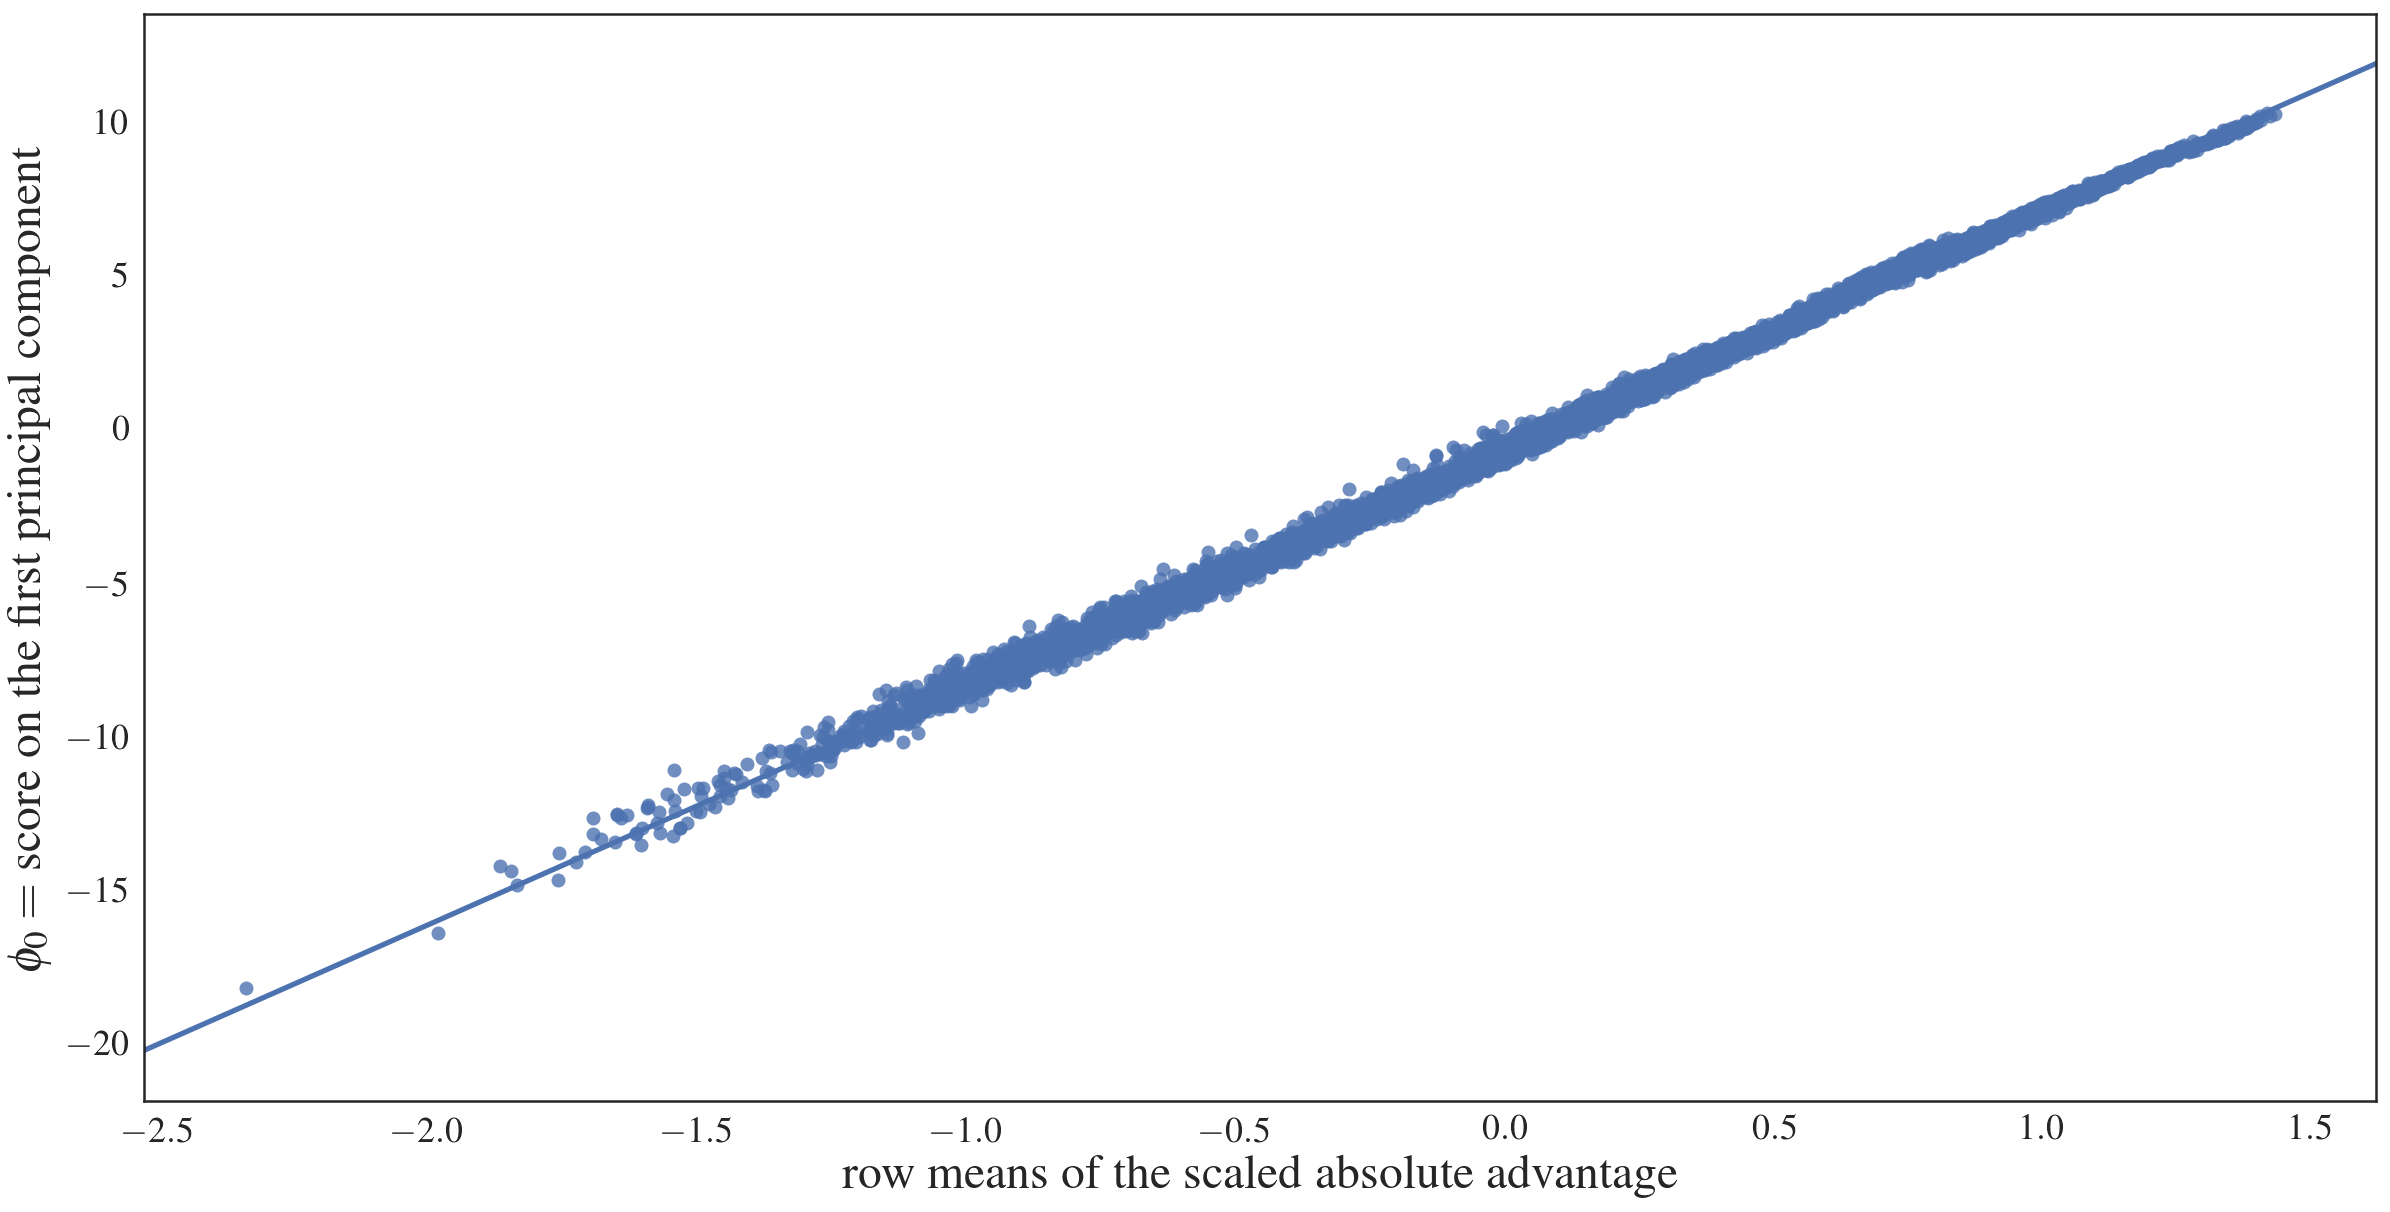

In [105]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.regplot(data=row_means_phi_0, x='row_mean_of_scaled_data', y='component_0', ax=ax)
# for x, y, p in zip(scaler.scale_, pca.components_[0], rpop_df.columns):
#     ax.annotate(s=p, xy=(x, y), fontsize=18)
ax.set_xlabel('row means of the scaled absolute advantage', fontsize=24)
ax.set_ylabel(r'$\phi_0 =$ score on the first principal component', fontsize=24)
ax.tick_params(labelsize=18)

## Watermark

In [135]:
%load_ext watermark

In [110]:
%watermark

2018-08-04T13:54:44-04:00

CPython 3.5.3
IPython 6.0.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [142]:
%watermark -p Cython,numpy,scipy,pandas,sklearn,matplotlib,sympy,seaborn,pygam,scipy,statsmodels,pandas_datareader,palettable,imageio,dill

Cython 0.25.2
numpy 1.12.1
scipy 1.1.0
pandas 0.19.2
sklearn 0.19.1
matplotlib 2.0.2
sympy 1.0
seaborn 0.7.1
pygam 0.2.17
scipy 1.1.0
statsmodels 0.8.0
pandas_datareader 0.2.1
palettable 2.1.1
imageio 2.1.2
dill 0.2.6
